In [1]:
import pandas as pd

pre = pd.read_csv("P1_V3/PRE_rede_coordenacao_final_07_60s.csv")
pos = pd.read_csv("P2/P2_rede_coordenacao_final_07_60s.csv")

# Conjunto de nós (Source ∪ Target)
pre_nodes = set(pre["Source"].astype(str)) | set(pre["Target"].astype(str))
pos_nodes = set(pos["Source"].astype(str)) | set(pos["Target"].astype(str))

# Interseções
common_nodes = pre_nodes & pos_nodes
only_pre = pre_nodes - pos_nodes
only_pos = pos_nodes - pre_nodes

# Métricas
jaccard = len(common_nodes) / len(pre_nodes | pos_nodes)

print("=== COMPARAÇÃO DE USUÁRIOS (Source ∪ Target) ===")
print(f"Usuários PRE: {len(pre_nodes)}")
print(f"Usuários PÓS: {len(pos_nodes)}")
print(f"Usuários em comum: {len(common_nodes)}")
print(f"Somente PRE: {len(only_pre)}")
print(f"Somente PÓS: {len(only_pos)}")
print(f"Índice de Jaccard: {jaccard:.3f}")


=== COMPARAÇÃO DE USUÁRIOS (Source ∪ Target) ===
Usuários PRE: 170
Usuários PÓS: 237
Usuários em comum: 36
Somente PRE: 134
Somente PÓS: 201
Índice de Jaccard: 0.097


In [2]:
import pandas as pd
import networkx as nx
import numpy as np

# === Arquivos ===
pre_edges = pd.read_csv("P1_V3/PRE_rede_coordenacao_final_07_60s.csv")
pos_edges = pd.read_csv("P2/P2_rede_coordenacao_final_07_60s.csv")
pre_nodes = pd.read_csv("P1_V3/P1_nos_e_comunidades.csv")   # Louvain PRE
pos_nodes = pd.read_csv("P2/p2_nos_e_comunidades.csv")   # Louvain POS

def build_graph(df):
    G = nx.Graph()
    for u, v, w in df[["Source","Target","Weight"]].itertuples(index=False):
        G.add_edge(str(u), str(v), weight=float(w))
    return G

G1 = build_graph(pre_edges)
G2 = build_graph(pos_edges)

# Persistentes (Source ∪ Target)
pre_users = set(pre_edges["Source"].astype(str)) | set(pre_edges["Target"].astype(str))
pos_users = set(pos_edges["Source"].astype(str)) | set(pos_edges["Target"].astype(str))
persist = pre_users & pos_users

def add_core_global(nodes_df, G):
    core = nx.core_number(G) if G.number_of_edges() > 0 else {}
    kmax = max(core.values()) if core else 0
    strength = dict(G.degree(weight="weight"))

    out = nodes_df.copy()
    out["user_id"] = out["user_id"].astype(str)
    out["coreness_global"] = out["user_id"].map(core).fillna(0).astype(int)
    out["is_core_global"] = out["coreness_global"].eq(kmax)  # núcleo = kmax
    out["strength"] = out["user_id"].map(strength).fillna(0.0)
    out["is_persistent"] = out["user_id"].isin(persist)
    return out, kmax

pre_out, kmax_pre = add_core_global(pre_nodes, G1)
pos_out, kmax_pos = add_core_global(pos_nodes, G2)

print("kmax PRE:", kmax_pre, "| kmax POS:", kmax_pos)
print("Persistentes:", len(persist))

def summarize(df, label):
    core_all = df["is_core_global"].mean()
    core_pers = df.loc[df["is_persistent"], "is_core_global"].mean()
    core_non  = df.loc[~df["is_persistent"], "is_core_global"].mean()
    print(f"\n[{label}] núcleo (k=kmax):")
    print("core_rate_all:", round(core_all, 4))
    print("core_rate_persistent:", round(core_pers, 4))
    print("core_rate_nonpersistent:", round(core_non, 4))

summarize(pre_out, "PRE")
summarize(pos_out, "POS")

# salvar
pre_out.to_csv("PRE_nodes_core_persist.csv", index=False)
pos_out.to_csv("POS_nodes_core_persist.csv", index=False)


kmax PRE: 3 | kmax POS: 2
Persistentes: 36

[PRE] núcleo (k=kmax):
core_rate_all: 0.0235
core_rate_persistent: 0.0833
core_rate_nonpersistent: 0.0075

[POS] núcleo (k=kmax):
core_rate_all: 0.1097
core_rate_persistent: 0.1944
core_rate_nonpersistent: 0.0945


In [1]:
import pandas as pd
import json

# ==============================================================================
# 1. CARREGUE SEU ARQUIVO DE MENSAGENS DO PÓS-ELEIÇÃO
# ==============================================================================
# Substitua pelo nome real do seu arquivo de mensagens (não o de rede/nós)
# Exemplo: 'mensagens_pos_eleicao.csv'
try:
    df = pd.read_csv('p1_v3/dataset_zap_1_preprocessado.csv') # <--- COLOQUE O NOME DO SEU ARQUIVO AQUI
except:
    # Criando dados fictícios apenas para você ver o código rodando se não tiver o arquivo agora
    data = {
        'group_id': ['Grupo A']*500 + ['Grupo B']*100 + ['Grupo C']*3000 + ['Grupo D']*200,
        'message_text': ['selva']*400 + ['bom dia']*100 +    # Grupo A: Muito tóxico
                        ['olá']*100 +                        # Grupo B: Limpo
                        ['intervenção']*200 + ['oi']*2800 +  # Grupo C: Grande, pouco tóxico
                        ['quartel']*180 + ['paz']*20         # Grupo D: Pequeno, muito tóxico
    }
    df = pd.DataFrame(data)
    print("⚠️ Usando dados de exemplo. Substitua pelo seu CSV real!")

# Garanta que o texto seja string
df['text_contnt_anonymous'] = df['text_contnt_anonymous'].astype(str).str.lower()

# ==============================================================================
# 2. DEFINA O "TERMÔMETRO" (Palavras que indicam radicalização)
# ==============================================================================
termos_radicais = [
    'selva', 'intervenção', 'quartel', 'fraude', 'ladrão', 
    'exército', 'artigo 142', 'bunker', 'guerra', 'resistência',
    'inconstitucional', 'censura', 'ditadura'
]

# Função para checar se a mensagem é "tóxica/radical"
def calcular_toxicidade(texto):
    return any(termo in texto for termo in termos_radicais)

# Aplica a verificação (cria uma coluna True/False)
df['is_radical'] = df['message_text'].apply(calcular_toxicidade)

# ==============================================================================
# 3. AGRUPA E CALCULA MÉTRICAS
# ==============================================================================
metrics = df.groupby('group_').agg(
    volume=('message_text', 'count'),          # Conta total de msgs
    msgs_radicais=('is_radical', 'sum')        # Soma quantas bateram nas palavras-chave
).reset_index()

# Calcula o Score (Porcentagem de msgs radicais no grupo)
# Multiplicamos por um fator para o score ficar entre 0 e 100 visualmente interessante
metrics['score'] = (metrics['msgs_radicais'] / metrics['volume']) * 100

# Arredonda
metrics['score'] = metrics['score'].round(1)

# ==============================================================================
# 4. FILTRA E FORMATA PARA O STORYTELLING
# ==============================================================================
# Pegamos os top 5 maiores + 5 mais radicais para ter variedade
top_vol = metrics.sort_values('volume', ascending=False).head(5)
top_score = metrics.sort_values('score', ascending=False).head(5)
final_df = pd.concat([top_vol, top_score]).drop_duplicates().head(10)

# Gera o JSON pronto para copiar
json_output = []
for _, row in final_df.iterrows():
    # Mascara o nome do grupo para caber na bolinha (ex: "Grupo 12ab...")
    group_name = str(row['group_id'])
    short_name = f"Grupo {group_name[:4]}" if len(group_name) > 5 else group_name
    
    json_output.append({
        "id": short_name,
        "volume": int(row['volume']),
        "score": float(row['score'])
    })

print("\n=== COPIE E COLE ISSO NO SEU scenes.js (dentro de 'data') ===\n")
print(json.dumps(json_output, indent=4))

KeyError: 'message_text'

In [3]:
import pandas as pd
import json

# 1. Carregue seu arquivo (Substitua pelo nome real do seu CSV)
df = pd.read_csv('p1_v3/dataset_zap_1_preprocessado.csv')

# --- Exemplo de como seus dados devem estar carregados ---
# df = pd.DataFrame({
#     'id_group_anonymous': ['hash1', 'hash1', 'hash2'],
#     'score_misinformation': [0.1, 0.9, 0.8],
#     'text_content_anonymous': ['msg1', 'msg2', 'msg3']
# })

# 2. Agrupa por Grupo e calcula as métricas
df_bubble = df.groupby('id_group_anonymous').agg(
    volume=('text_content_anonymous', 'count'),      # Tamanho da bolha
    avg_score=('score_misinformation', 'mean')       # Cor da bolha (Média do score)
).reset_index()

# 3. Ajustes de Escala
# Se o score original for de 0 a 1 (ex: 0.95), multiplicamos por 100.
# Se já for de 0 a 100, pode remover a multiplicação.
if df_bubble['avg_score'].max() <= 1.0:
    df_bubble['avg_score'] = df_bubble['avg_score'] * 100

df_bubble['avg_score'] = df_bubble['avg_score'].round(1)

# 4. Estratégia de Seleção para o Storytelling
# Não podemos mostrar 300 bolhas. Vamos pegar:
# - Os 5 maiores em volume (Os "Gigantes")
# - Os 5 maiores em score (Os "Radicais", mesmo que pequenos)

top_volume = df_bubble.sort_values('volume', ascending=False).head(6)
top_toxic  = df_bubble.sort_values('avg_score', ascending=False).head(6)

# Junta e remove duplicatas
final_df = pd.concat([top_volume, top_toxic]).drop_duplicates().head(12)

# 5. Formatar para JSON
bubble_data = []
for _, row in final_df.iterrows():
    # Encurta o ID para caber na bolha (ex: "Grupo a1b2...")
    short_id = f"Grupo {str(row['id_group_anonymous'])[:4]}"
    
    bubble_data.append({
        "id": short_id,
        "volume": int(row['volume']),
        "score": float(row['avg_score'])
    })

# 6. Imprime o resultado para você copiar
print("=== COPIE O CÓDIGO ABAIXO PARA O SEU scenes.js ===")
print(json.dumps(bubble_data, indent=4))

=== COPIE O CÓDIGO ABAIXO PARA O SEU scenes.js ===
[
    {
        "id": "Grupo ab6b",
        "volume": 6112,
        "score": 39.0
    },
    {
        "id": "Grupo 04cd",
        "volume": 3757,
        "score": 33.1
    },
    {
        "id": "Grupo 6fb2",
        "volume": 3719,
        "score": 41.3
    },
    {
        "id": "Grupo edcd",
        "volume": 3685,
        "score": 39.1
    },
    {
        "id": "Grupo 39b2",
        "volume": 3673,
        "score": 37.2
    },
    {
        "id": "Grupo 1ae4",
        "volume": 3529,
        "score": 35.8
    },
    {
        "id": "Grupo bce8",
        "volume": 5,
        "score": 75.0
    },
    {
        "id": "Grupo ed95",
        "volume": 3,
        "score": 68.3
    },
    {
        "id": "Grupo 5f76",
        "volume": 38,
        "score": 67.7
    },
    {
        "id": "Grupo 9a80",
        "volume": 27,
        "score": 65.7
    },
    {
        "id": "Grupo c088",
        "volume": 1,
        "score": 65.1
    },
   

In [4]:
import pandas as pd
import json

# 1. Carregue seu arquivo (Substitua pelo nome real do seu CSV)
df = pd.read_csv('P2/dataset_zap_2_preprocessado.csv')

# --- Exemplo de como seus dados devem estar carregados ---
# df = pd.DataFrame({
#     'id_group_anonymous': ['hash1', 'hash1', 'hash2'],
#     'score_misinformation': [0.1, 0.9, 0.8],
#     'text_content_anonymous': ['msg1', 'msg2', 'msg3']
# })

# 2. Agrupa por Grupo e calcula as métricas
df_bubble = df.groupby('id_group_anonymous').agg(
    volume=('text_content_anonymous', 'count'),      # Tamanho da bolha
    avg_score=('score_misinformation', 'mean')       # Cor da bolha (Média do score)
).reset_index()

# 3. Ajustes de Escala
# Se o score original for de 0 a 1 (ex: 0.95), multiplicamos por 100.
# Se já for de 0 a 100, pode remover a multiplicação.
if df_bubble['avg_score'].max() <= 1.0:
    df_bubble['avg_score'] = df_bubble['avg_score'] * 100

df_bubble['avg_score'] = df_bubble['avg_score'].round(1)

# 4. Estratégia de Seleção para o Storytelling
# Não podemos mostrar 300 bolhas. Vamos pegar:
# - Os 5 maiores em volume (Os "Gigantes")
# - Os 5 maiores em score (Os "Radicais", mesmo que pequenos)

top_volume = df_bubble.sort_values('volume', ascending=False).head(6)
top_toxic  = df_bubble.sort_values('avg_score', ascending=False).head(6)

# Junta e remove duplicatas
final_df = pd.concat([top_volume, top_toxic]).drop_duplicates().head(12)

# 5. Formatar para JSON
bubble_data = []
for _, row in final_df.iterrows():
    # Encurta o ID para caber na bolha (ex: "Grupo a1b2...")
    short_id = f"Grupo {str(row['id_group_anonymous'])[:4]}"
    
    bubble_data.append({
        "id": short_id,
        "volume": int(row['volume']),
        "score": float(row['avg_score'])
    })

# 6. Imprime o resultado para você copiar
print("=== COPIE O CÓDIGO ABAIXO PARA O SEU scenes.js ===")
print(json.dumps(bubble_data, indent=4))

C:\Users\nasci\AppData\Local\Temp\ipykernel_60136\1002969670.py:5: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('P2/dataset_zap_2_preprocessado.csv')


=== COPIE O CÓDIGO ABAIXO PARA O SEU scenes.js ===
[
    {
        "id": "Grupo ab6b",
        "volume": 11440,
        "score": 41.5
    },
    {
        "id": "Grupo 229c",
        "volume": 6234,
        "score": 32.0
    },
    {
        "id": "Grupo c14b",
        "volume": 5016,
        "score": 27.7
    },
    {
        "id": "Grupo 6441",
        "volume": 4412,
        "score": 34.6
    },
    {
        "id": "Grupo 6fb2",
        "volume": 4264,
        "score": 40.4
    },
    {
        "id": "Grupo 04cd",
        "volume": 4107,
        "score": 36.5
    },
    {
        "id": "Grupo ed95",
        "volume": 1,
        "score": 81.6
    },
    {
        "id": "Grupo c382",
        "volume": 3,
        "score": 77.8
    },
    {
        "id": "Grupo eee3",
        "volume": 2,
        "score": 77.8
    },
    {
        "id": "Grupo 0797",
        "volume": 44,
        "score": 60.8
    },
    {
        "id": "Grupo df21",
        "volume": 122,
        "score": 60.6
    },
 

In [18]:
import sys
import subprocess
import os
import json
import pandas as pd

# --- 1. INSTALAÇÃO AUTOMÁTICA ---
def install(package):
    try:
        __import__(package)
    except ImportError:
        print(f"📦 Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install("wordcloud")
install("pandas")
install("matplotlib")

from wordcloud import WordCloud

# --- CONFIGURAÇÃO DOS ARQUIVOS (Edite se necessário) ---

ARQUIVO_NOS_P1 = 'p1_v3/p1_nos_e_comunidades.csv'

ARQUIVO_ARESTAS_P1 = 'p1_v3/rede_coordenacao_final_07_60s.csv' # Renomeie seu arquivo se precisar

ARQUIVO_NOS_P2 = 'P2/p2_nos_e_comunidades.csv'

ARQUIVO_ARESTAS_P2 = 'P2/P2_rede_coordenacao_final_07_60s.csv'

ARQUIVO_MENSAGENS = 'P2/dataset_zap_2_preprocessado.csv' # Seu arquivo de textos

PASTA_IMAGENS = 'wordclouds_output'

# Mapeamento Manual das Colunas (Baseado no seu erro)
COL_USER_MSG = 'id_member_anonymous'      # ID do Usuário nas mensagens
COL_TEXT_MSG = 'text_content_anonymous'   # Texto da mensagem
COL_SCORE_MSG = 'score_misinformation'    # Score de desinformação

# Stopwords (Limpeza)
STOPWORDS_PT = set([
    'de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 
    'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 
    'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 
    'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 
    'quem', 'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 
    'suas', 'meu', 'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 
    'nós', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 
    'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 
    'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 
    'aquelas', 'isto', 'aquilo', 'estou', 'pra', 'pro', 'tá', 'né', 'aí', 'tbm', 'vc', 'vcs', 'pq', 
    'pode', 'vai', 'ser', 'sobre', 'então', 'assim', 'agora', 'lá', 'aqui', 'sim', 'coisa', 'fazer',
    'tudo', 'onde', 'porque', 'bom', 'bem', 'dia', 'boa', 'tarde', 'noite', 'hoje', 'amanhã', 'ontem',
    'http', 'https', 'www', 'com', 'br', 'whatsapp', 'grupo', 'todo'
])

# --- 3. GERAÇÃO DOS DADOS DA REDE ---
def gerar_json_rede():
    print("🔄 Gerando networkData.js...")
    try:
        df_nodes = pd.read_csv(ARQUIVO_NOS_P2)
        df_edges = pd.read_csv(ARQUIVO_ARESTAS_P2)
        
        # Limpeza IDs
        df_nodes['user_id'] = df_nodes['user_id'].astype(str).str.strip()
        df_edges['Source'] = df_edges['Source'].astype(str).str.strip()
        df_edges['Target'] = df_edges['Target'].astype(str).str.strip()
        
        nodes = []
        valid_ids = set()
        for _, row in df_nodes.iterrows():
            nodes.append({
                "id": row['user_id'],
                "group": int(row['community_id']),
                "val": int(row['degree'])
            })
            valid_ids.add(row['user_id'])
            
        links = []
        for _, row in df_edges.iterrows():
            if row['Source'] in valid_ids and row['Target'] in valid_ids:
                links.append({
                    "source": row['Source'],
                    "target": row['Target'],
                    "value": int(row['Weight'])
                })
        
        full_data = { "p2": {"nodes": nodes, "links": links} }
        
        with open("networkData.js", "w", encoding="utf-8") as f:
            f.write(f"export const networkData = {json.dumps(full_data, indent=2)};")
        print("✅ networkData.js criado!")
        return valid_ids
        
    except Exception as e:
        print(f"❌ Erro ao gerar JSON: {e}")
        return set()

# --- 4. GERAÇÃO DAS NUVENS POR USUÁRIO ---
def gerar_nuvens(usuarios_da_rede):
    print("\n🔄 Iniciando geração de Nuvens...")
    
    if not os.path.exists(ARQUIVO_MENSAGENS):
        print(f"❌ Arquivo '{ARQUIVO_MENSAGENS}' não encontrado.")
        return

    os.makedirs(PASTA_IMAGENS, exist_ok=True)
    
    print("   Carregando CSV de mensagens...")
    # Carrega apenas colunas úteis para economizar memória
    cols_to_load = [COL_USER_MSG, COL_TEXT_MSG, COL_SCORE_MSG]
    try:
        df = pd.read_csv(ARQUIVO_MENSAGENS, usecols=cols_to_load)
    except ValueError:
        print(f"❌ Erro nas colunas. Verifique se {cols_to_load} existem no CSV.")
        return

    # Padroniza ID do usuário para cruzar com a rede
    df[COL_USER_MSG] = df[COL_USER_MSG].astype(str).str.strip()

    # 1. Filtra mensagens APENAS dos usuários que estão na rede (Economia gigante de tempo)
    df_rede = df[df[COL_USER_MSG].isin(usuarios_da_rede)].copy()
    print(f"   Mensagens de usuários da rede: {len(df_rede)}")

    # 2. Filtra por Score > 0.7
    df_rede[COL_SCORE_MSG] = pd.to_numeric(df_rede[COL_SCORE_MSG], errors='coerce')
    df_toxico = df_rede[df_rede[COL_SCORE_MSG] > 0.7].copy()
    print(f"   Mensagens Tóxicas (Score > 0.7): {len(df_toxico)}")

    # 3. Agrupa texto por usuário
    df_toxico[COL_TEXT_MSG] = df_toxico[COL_TEXT_MSG].astype(str).fillna('')
    agrupado = df_toxico.groupby(COL_USER_MSG)[COL_TEXT_MSG].apply(' '.join).reset_index()

    # 4. Gera Imagens
    wc = WordCloud(
        width=300, height=300, 
        background_color='black', 
        colormap='spring', # Vermelho/Quente
        stopwords=STOPWORDS_PT, 
        max_words=40,
        min_word_length=3
    )

    count = 0
    print(f"   Gerando nuvens para {len(agrupado)} usuários...")
    
    for _, row in agrupado.iterrows():
        user_id = row[COL_USER_MSG]
        texto = row[COL_TEXT_MSG]
        
        if len(texto.split()) < 3: continue # Ignora se tiver muito pouco texto
        
        try:
            wc.generate(texto)
            wc.to_file(os.path.join(PASTA_IMAGENS, f"user_{user_id}.png"))
            count += 1
        except:
            pass

    print(f"✅ Sucesso! {count} imagens geradas em '{PASTA_IMAGENS}'.")
    print("👉 Mova as imagens para 'public/img/clouds/' no seu site.")

# --- EXECUÇÃO ---
usuarios = gerar_json_rede()
if len(usuarios) > 0:
    gerar_nuvens(usuarios)

🔄 Gerando networkData.js...
✅ networkData.js criado!

🔄 Iniciando geração de Nuvens...
   Carregando CSV de mensagens...
   Mensagens de usuários da rede: 44334
   Mensagens Tóxicas (Score > 0.7): 1693
   Gerando nuvens para 159 usuários...
✅ Sucesso! 159 imagens geradas em 'wordclouds_output'.
👉 Mova as imagens para 'public/img/clouds/' no seu site.


In [19]:
import pandas as pd
import json
import os

# --- CONFIGURAÇÃO DOS ARQUIVOS ---
# Ajuste os caminhos conforme onde seus arquivos estão salvos
# P1 (Pré-Eleição)
ARQUIVO_NOS_P1 = 'p1_v3/P1_nos_e_comunidades.csv'
ARQUIVO_ARESTAS_P1 = 'p1_v3/p1_rede_coordenacao_final_07_60s (2).csv'

# P2 (Pós-Eleição)
ARQUIVO_NOS_P2 = 'P2/p2_nos_e_comunidades.csv'        # Ou apenas 'p2_nos_e_comunidades.csv' se estiver na mesma pasta
ARQUIVO_ARESTAS_P2 = 'P2/P2_rede_coordenacao_final_07_60s.csv'

SAIDA_JS = 'networkData.js'

def processar_rede(arquivo_nos, arquivo_arestas, label):
    print(f"🔄 Processando {label}...")
    
    if not os.path.exists(arquivo_nos) or not os.path.exists(arquivo_arestas):
        print(f"❌ ERRO: Arquivos de {label} não encontrados.\n   Procurando: {arquivo_nos} e {arquivo_arestas}")
        return None

    try:
        # Carrega CSVs
        df_nodes = pd.read_csv(arquivo_nos)
        df_edges = pd.read_csv(arquivo_arestas)
        
        # Padroniza IDs para string (evita erro de tipo)
        df_nodes['user_id'] = df_nodes['user_id'].astype(str).str.strip()
        df_edges['Source'] = df_edges['Source'].astype(str).str.strip()
        df_edges['Target'] = df_edges['Target'].astype(str).str.strip()
        
        # Processa Nós
        nodes = []
        valid_ids = set()
        for _, row in df_nodes.iterrows():
            nodes.append({
                "id": row['user_id'],
                "group": int(row['community_id']),
                "val": int(row['degree'])
            })
            valid_ids.add(row['user_id'])
            
        # Processa Arestas (Links)
        links = []
        for _, row in df_edges.iterrows():
            # Só adiciona aresta se os dois nós existirem na lista de nós
            if row['Source'] in valid_ids and row['Target'] in valid_ids:
                links.append({
                    "source": row['Source'],
                    "target": row['Target'],
                    "value": int(row['Weight'])
                })
        
        print(f"   ✅ {label}: {len(nodes)} nós e {len(links)} conexões processadas.")
        return {"nodes": nodes, "links": links}

    except Exception as e:
        print(f"❌ Erro crítico ao processar {label}: {e}")
        return None

# --- EXECUÇÃO PRINCIPAL ---
print("=== GERADOR DE REDE COMPLETA (P1 + P2) ===")

data_p1 = processar_rede(ARQUIVO_NOS_P1, ARQUIVO_ARESTAS_P1, "P1 (Pré)")
data_p2 = processar_rede(ARQUIVO_NOS_P2, ARQUIVO_ARESTAS_P2, "P2 (Pós)")

if data_p1 and data_p2:
    # Monta o objeto final com as duas chaves minúsculas (padrão do código JS)
    full_data = {
        "p1": data_p1,
        "p2": data_p2
    }
    
    # Salva o arquivo JS
    conteudo_js = f"export const networkData = {json.dumps(full_data, indent=2)};"
    
    with open(SAIDA_JS, "w", encoding="utf-8") as f:
        f.write(conteudo_js)
        
    print(f"\n✅ SUCESSO! Arquivo '{SAIDA_JS}' gerado.")
    print("👉 Mova este arquivo para a pasta 'src/data/' do seu projeto.")
else:
    print("\n❌ FALHA: Não foi possível gerar o arquivo completo pois faltam dados.")

=== GERADOR DE REDE COMPLETA (P1 + P2) ===
🔄 Processando P1 (Pré)...
   ✅ P1 (Pré): 170 nós e 129 conexões processadas.
🔄 Processando P2 (Pós)...
   ✅ P2 (Pós): 237 nós e 176 conexões processadas.

✅ SUCESSO! Arquivo 'networkData.js' gerado.
👉 Mova este arquivo para a pasta 'src/data/' do seu projeto.


In [20]:
import pandas as pd
import json
import os

# --- ARQUIVOS ---
FILE_EDGES_P1 = 'p1_rede_coordenacao_final_07_60s (2).csv'
FILE_EDGES_P2 = 'P2/P2_rede_coordenacao_final_07_60s.csv'
FILE_MSGS = 'P2/dataset_zap_2_preprocessado.csv' # Para tentar achar o UF

OUTPUT_FILE = 'leaderData.js'

def calcular_ranking(path_edges, label):
    print(f"📊 Calculando ranking para {label}...")
    if not os.path.exists(path_edges):
        print(f"   ❌ Arquivo {path_edges} não encontrado.")
        return []

    df = pd.read_csv(path_edges)
    df['Source'] = df['Source'].astype(str).str.strip()
    df['Target'] = df['Target'].astype(str).str.strip()
    
    # Soma peso de saída e entrada (Grau Ponderado)
    out_degree = df.groupby('Source')['Weight'].sum()
    in_degree = df.groupby('Target')['Weight'].sum()
    
    # Junta tudo (Total Influence)
    total_degree = out_degree.add(in_degree, fill_value=0).sort_values(ascending=False)
    
    ranking = []
    for uid, val in total_degree.head(20).items(): # Pega Top 20
        ranking.append({
            "id": uid,
            "value": int(val),
            "label": f"Perfil: {uid[:4]}..." # Label provisório
        })
    return ranking

# --- TENTA MAPEAR UF (ESTADO) ---
def mapear_ufs(ranking_p1, ranking_p2):
    print("🗺️  Mapeando UFs através das mensagens...")
    if not os.path.exists(FILE_MSGS):
        print("   ⚠️ Arquivo de mensagens não encontrado. UFs ficarão vazios.")
        return

    # Tenta ler colunas de ID e Estado para economizar memória
    try:
        df = pd.read_csv(FILE_MSGS, usecols=['id_member_anonymous', 'state'], low_memory=False)
        df = df.dropna().drop_duplicates(subset=['id_member_anonymous'])
        
        # Cria dicionário { id: 'SP' }
        user_uf_map = dict(zip(df.id_member_anonymous.astype(str).str.strip(), df.state))
        
        # Atualiza os rankings
        for r in ranking_p1 + ranking_p2:
            uf = user_uf_map.get(r['id'], "BR") # Padrão BR se não achar
            r['label'] = f"Perfil: {r['id'][:4]}... UF:{uf}"
            r['uf'] = uf
            
    except Exception as e:
        print(f"   ⚠️ Erro ao ler UFs: {e}")

# --- EXECUÇÃO ---
rank_p1 = calcular_ranking(FILE_EDGES_P1, "P1")
rank_p2 = calcular_ranking(FILE_EDGES_P2, "P2")

mapear_ufs(rank_p1, rank_p2)

final_data = {
    "p1": rank_p1,
    "p2": rank_p2
}

js_content = f"export const leaderData = {json.dumps(final_data, indent=2)};"

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    f.write(js_content)

print(f"\n✅ Arquivo '{OUTPUT_FILE}' gerado! Mova para 'src/data/'.")

📊 Calculando ranking para P1...
   ❌ Arquivo p1_rede_coordenacao_final_07_60s (2).csv não encontrado.
📊 Calculando ranking para P2...
🗺️  Mapeando UFs através das mensagens...

✅ Arquivo 'leaderData.js' gerado! Mova para 'src/data/'.


In [21]:
import pandas as pd
import json
import os

# --- CONFIGURAÇÃO DOS ARQUIVOS (Ajuste se necessário) ---
# Arquivo de arestas do P1 (que você fez upload)
FILE_EDGES_P1 = 'p1_v3/p1_rede_coordenacao_final_07_60s (2).csv'

# Arquivo de arestas do P2 (que você já tinha)
FILE_EDGES_P2 = 'P2/P2_rede_coordenacao_final_07_60s.csv'

# Tenta achar o arquivo P2 em subpasta se não estiver na raiz
if not os.path.exists(FILE_EDGES_P2) and os.path.exists('P2/P2_rede_coordenacao_final_07_60s.csv'):
    FILE_EDGES_P2 = 'P2/P2_rede_coordenacao_final_07_60s.csv'

# Arquivo de Mensagens (Opcional, apenas para pegar o UF/Estado)
# Se não encontrar, ele vai deixar o UF em branco sem dar erro.
FILE_MSGS = 'dataset_zap_2_preprocessado.csv'
if not os.path.exists(FILE_MSGS) and os.path.exists('P2/dataset_zap_2_preprocessado.csv'):
    FILE_MSGS = 'P2/dataset_zap_2_preprocessado.csv'

OUTPUT_FILE = 'leaderData.js'

def calcular_ranking(path_edges, label):
    print(f"📊 Processando {label}...")
    
    if not os.path.exists(path_edges):
        print(f"   ❌ Arquivo não encontrado: {path_edges}")
        return []

    try:
        df = pd.read_csv(path_edges)
        
        # Limpeza básica
        df['Source'] = df['Source'].astype(str).str.strip()
        df['Target'] = df['Target'].astype(str).str.strip()
        
        # O "Poder" do líder é a soma dos pesos de todas as conexões (entrada + saída)
        # Grau de Saída (Quem ele coordena)
        out_degree = df.groupby('Source')['Weight'].sum()
        # Grau de Entrada (Quem coordena ele - opcional, mas bom para autoridade)
        in_degree = df.groupby('Target')['Weight'].sum()
        
        # Soma tudo
        total_influence = out_degree.add(in_degree, fill_value=0).sort_values(ascending=False)
        
        ranking = []
        # Pega os Top 20 para deixar guardado no JSON (o site exibe só 5)
        for uid, val in total_influence.head(20).items():
            ranking.append({
                "id": uid,
                "value": int(val),
                "label": f"Perfil: {uid[:4]}...",
                "uf": "--" # Placeholder
            })
            
        print(f"   ✅ {label}: Top 1 encontrado ({ranking[0]['id'][:6]}... com {ranking[0]['value']} interações)")
        return ranking
        
    except Exception as e:
        print(f"   ❌ Erro ao ler {label}: {e}")
        return []

def adicionar_ufs(ranking_p1, ranking_p2):
    print("🗺️  Buscando UFs (Estados) no arquivo de mensagens...")
    
    if not os.path.exists(FILE_MSGS):
        print("   ⚠️ Arquivo de mensagens não encontrado. Os UFs ficarão como '--'.")
        return

    try:
        # Lê apenas colunas necessárias para ser rápido
        cols = ['id_member_anonymous', 'state'] 
        # Verifica nomes das colunas (às vezes muda)
        df_sample = pd.read_csv(FILE_MSGS, nrows=1)
        if 'id_user_anonymous' in df_sample.columns: cols[0] = 'id_user_anonymous'
        
        df = pd.read_csv(FILE_MSGS, usecols=cols, low_memory=False)
        
        # Cria um mapa { ID_USUARIO : UF }
        # Remove duplicatas e nulos
        df = df.dropna().drop_duplicates(subset=[cols[0]])
        user_uf_map = dict(zip(df[cols[0]].astype(str).str.strip(), df['state']))
        
        # Atualiza os rankings
        count = 0
        for r in ranking_p1 + ranking_p2:
            if r['id'] in user_uf_map:
                r['uf'] = user_uf_map[r['id']]
                count += 1
                
        print(f"   ✅ {count} UFs identificados e atualizados.")
        
    except Exception as e:
        print(f"   ⚠️ Erro ao processar UFs: {e}")

# --- EXECUÇÃO ---
print("=== GERADOR DE LEADER DATA ===")

rank_p1 = calcular_ranking(FILE_EDGES_P1, "P1 (Pré-Eleição)")
rank_p2 = calcular_ranking(FILE_EDGES_P2, "P2 (Pós-Eleição)")

# Tenta preencher os estados se possível
if rank_p1 or rank_p2:
    adicionar_ufs(rank_p1, rank_p2)

# Monta o JSON final
final_data = {
    "p1": rank_p1,
    "p2": rank_p2
}

js_content = f"export const leaderData = {json.dumps(final_data, indent=2)};"

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    f.write(js_content)

print(f"\n✅ Arquivo '{OUTPUT_FILE}' gerado com sucesso!")
print("👉 Mova para 'src/data/' e recarregue o site.")

=== GERADOR DE LEADER DATA ===
📊 Processando P1 (Pré-Eleição)...
   ✅ P1 (Pré-Eleição): Top 1 encontrado (4ea1b3... com 260 interações)
📊 Processando P2 (Pós-Eleição)...
   ✅ P2 (Pós-Eleição): Top 1 encontrado (ef4961... com 764 interações)
🗺️  Buscando UFs (Estados) no arquivo de mensagens...
   ✅ 35 UFs identificados e atualizados.

✅ Arquivo 'leaderData.js' gerado com sucesso!
👉 Mova para 'src/data/' e recarregue o site.


In [24]:
import pandas as pd
import json
import os

# --- ARQUIVOS DE ENTRADA ---
FILE_PRE = 'P1_V3/PRE_topicos_por_comunidade.csv'
FILE_POS = 'P2/POS_topicos_por_comunidade.csv'
OUTPUT_FILE = 'butterflyData.js'


# --- LISTA DE TERMOS POLÊMICOS (WHITELIST) ---
# O script SÓ vai contar palavras que contenham estes radicais
TERMOS_POLEMICOS = set([
    # Instituições / Poder
    'quartel', 'exercito', 'forças', 'armadas', 'intervenção', 'artigo', '142', 
    'stm', 'stf', 'xandão', 'moraes', 'alexandre', 'tse', 'congresso',
    
    # Ação / Conflito
    'guerra', 'selva', 'luta', 'invadir', 'invasão', 'quebrar', 'parar', 'greve', 
    'paralisação', 'resistência', 'resisitr', 'lutar', 'tomar', 'derrubar', 'Datafolha',
    
    # Rotulagem / Ataque
    'ladrão', 'presidiário', 'bandido', 'corrupto', 'quadrilha', 'rato', 'Mito', 'Voto', 'Votação', 'Votar',
    'comunista', 'esquerdista', 'petista', 'pt', 'fraude', 'roubo', 'roubado',
    
    # Mobilização
    'brasilia', 'qg', 'acampamento', 'patriota', 'patriotas', 'manifestação', 'pesquisa', 'debate'
    'festa', 'selma', 'código', 'sos', 'socorro', 'urgente', 'pesquisa', 'resultado'
])

def eh_polemico(palavra):
    # Verifica se a palavra contém algum dos termos polêmicos
    # Ex: "intervençãozinha" contém "intervenção" -> True
    p = palavra.lower().strip()
    for termo in TERMOS_POLEMICOS:
        if termo in p:
            return True
    return False

def processar_topicos(arquivo, label):
    print(f"🔥 Buscando termos polêmicos em {label}...")
    
    if not os.path.exists(arquivo):
        print(f"   ❌ Arquivo não encontrado: {arquivo}")
        return []

    try:
        df = pd.read_csv(arquivo)
        word_counts = {}
        
        for index, row in df.iterrows():
            if row.get('topic', 0) == -1: continue # Ignora ruído
            
            freq_topico = row['frequency']
            # O campo 'Words' tem as palavras do tópico
            # O campo 'top_words' tem as palavras mais representativas. Vamos usar 'top_words' para ser mais preciso
            palavras_raw = str(row['top_words']).split(',') 
            
            for p in palavras_raw:
                p_limpa = p.strip().lower()
                
                # --- O FILTRO DE OURO ---
                if eh_polemico(p_limpa):
                    if p_limpa in word_counts:
                        word_counts[p_limpa] += freq_topico
                    else:
                        word_counts[p_limpa] = freq_topico
                    
        # Formata para JSON
        ranking = []
        for word, count in word_counts.items():
            ranking.append({"label": word.upper(), "value": int(count)}) # Upper para destaque
            
        # Ordena e Pega Top 10
        ranking.sort(key=lambda x: x['value'], reverse=True)
        top_10 = ranking[:10]
        
        print(f"   ✅ Encontrados {len(ranking)} termos polêmicos. Top 1: {top_10[0]['label'] if top_10 else 'Nenhum'}")
        return top_10
        
    except Exception as e:
        print(f"   ❌ Erro ao ler {label}: {e}")
        return []

# --- EXECUÇÃO ---
top_pre = processar_topicos(FILE_PRE, "PRÉ-ELEIÇÃO")
top_pos = processar_topicos(FILE_POS, "PÓS-ELEIÇÃO")

final_data = {
    "p1": top_pre,
    "p2": top_pos
}

js_content = f"export const butterflyData = {json.dumps(final_data, indent=2)};"

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    f.write(js_content)

print(f"\n✅ Arquivo '{OUTPUT_FILE}' gerado! Mova para 'src/data/'.")

🔥 Buscando termos polêmicos em PRÉ-ELEIÇÃO...
   ✅ Encontrados 84 termos polêmicos. Top 1: BANDIDOS
🔥 Buscando termos polêmicos em PÓS-ELEIÇÃO...
   ✅ Encontrados 88 termos polêmicos. Top 1: FRAUDE

✅ Arquivo 'butterflyData.js' gerado! Mova para 'src/data/'.


In [28]:
import pandas as pd
from collections import Counter
import re
import os
import sys

# --- CONFIGURAÇÃO ---
# Coloque aqui o nome exato dos seus arquivos de mensagens
ARQUIVO_PRE = 'p1_v3/dataset_zap_1_preprocessado.csv' # Ajuste para o nome do seu arquivo P1
ARQUIVO_POS = 'P2/dataset_zap_2_preprocessado.csv' # Ajuste para o nome do seu arquivo P2

# Nome da coluna que tem o texto da mensagem
COLUNA_TEXTO = 'clean_text' # Geralmente é 'clean_text', 'message' ou 'text'

def carregar_e_contar(caminho_arquivo, label):
    print(f"🔄 Carregando {label} ({caminho_arquivo})...")
    
    if not os.path.exists(caminho_arquivo):
        print(f"❌ Arquivo não encontrado: {caminho_arquivo}")
        return Counter(), 0

    try:
        # Lê o CSV
        df = pd.read_csv(caminho_arquivo, usecols=[COLUNA_TEXTO], dtype=str)
        
        # Remove vazios
        df = df.dropna(subset=[COLUNA_TEXTO])
        
        print(f"   Processando {len(df)} mensagens...")
        
        # Junta todo o texto em uma string gigante para tokenizar
        # (Isso é muito mais rápido do que iterar linha por linha em Python puro)
        texto_completo = " ".join(df[COLUNA_TEXTO].tolist()).lower()
        
        # Tokenização simples (separa por espaços e remove pontuação básica)
        # Se seus dados já estão pré-processados, split() deve bastar.
        # Se tiver pontuação, usamos regex:
        palavras = re.findall(r'\b\w+\b', texto_completo)
        
        contador = Counter(palavras)
        print(f"✅ {label} indexado! ({len(contador)} palavras únicas)")
        
        return contador, len(df)
        
    except Exception as e:
        print(f"❌ Erro ao ler {label}: {e}")
        # Tenta listar colunas para ajudar no debug
        try:
            df_err = pd.read_csv(caminho_arquivo, nrows=1)
            print(f"   Dica - Colunas disponíveis: {list(df_err.columns)}")
        except:
            pass
        return Counter(), 0

# --- EXECUÇÃO PRINCIPAL ---
print("=== BUSCADOR DE FREQUÊNCIA TEMPORAL ===")

# 1. Carrega os dados na memória RAM
count_pre, total_msgs_pre = carregar_e_contar(ARQUIVO_PRE, "PRÉ-ELEIÇÃO")
count_pos, total_msgs_pos = carregar_e_contar(ARQUIVO_POS, "PÓS-ELEIÇÃO")

if total_msgs_pre == 0 and total_msgs_pos == 0:
    print("\n⚠️ Nenhum dado carregado. Verifique os nomes dos arquivos no script.")
    sys.exit()

print("\n" + "="*50)
print("SISTEMA PRONTO. Digite uma palavra para pesquisar.")
print("Digite 'sair' para encerrar.")
print("="*50 + "\n")

# 2. Loop Interativo
while True:
    termo = input(">> Digite a palavra: ").strip().lower()
    
    if termo in ['sair', 'exit', 'quit']:
        break
    
    if not termo:
        continue
        
    freq_pre = count_pre.get(termo, 0)
    freq_pos = count_pos.get(termo, 0)
    
    # Cálculo de variação percentual
    if freq_pre > 0:
        variacao = ((freq_pos - freq_pre) / freq_pre) * 100
        str_var = f"{variacao:+.1f}%"
    else:
        str_var = "Novo (Infinito%)" if freq_pos > 0 else "0%"

    print(f"\nResultados para '{termo.upper()}':")
    print(f"   📅 PRÉ-Eleição: {freq_pre} ocorrências")
    print(f"   📅 PÓS-Eleição: {freq_pos} ocorrências")
    print(f"   📈 Variação:    {str_var}")
    
    # Análise rápida
    if freq_pos > freq_pre * 1.5:
        print("   🔥 ALERTA: Crescimento explosivo no Pós-Eleição.")
    elif freq_pre > freq_pos * 1.5:
        print("   📉 NOTA: Termo perdeu força após a eleição.")
    
    print("-" * 30)

=== BUSCADOR DE FREQUÊNCIA TEMPORAL ===
🔄 Carregando PRÉ-ELEIÇÃO (p1_v3/dataset_zap_1_preprocessado.csv)...
   Processando 122817 mensagens...
✅ PRÉ-ELEIÇÃO indexado! (81185 palavras únicas)
🔄 Carregando PÓS-ELEIÇÃO (P2/dataset_zap_2_preprocessado.csv)...
   Processando 150074 mensagens...
✅ PÓS-ELEIÇÃO indexado! (88833 palavras únicas)

SISTEMA PRONTO. Digite uma palavra para pesquisar.
Digite 'sair' para encerrar.



>> Digite a palavra:  Pesquisa



Resultados para 'PESQUISA':
   📅 PRÉ-Eleição: 3547 ocorrências
   📅 PÓS-Eleição: 257 ocorrências
   📈 Variação:    -92.8%
   📉 NOTA: Termo perdeu força após a eleição.
------------------------------


>> Digite a palavra:  Voto



Resultados para 'VOTO':
   📅 PRÉ-Eleição: 3198 ocorrências
   📅 PÓS-Eleição: 905 ocorrências
   📈 Variação:    -71.7%
   📉 NOTA: Termo perdeu força após a eleição.
------------------------------


>> Digite a palavra:  Debate



Resultados para 'DEBATE':
   📅 PRÉ-Eleição: 2293 ocorrências
   📅 PÓS-Eleição: 115 ocorrências
   📈 Variação:    -95.0%
   📉 NOTA: Termo perdeu força após a eleição.
------------------------------


>> Digite a palavra:  Datafolha



Resultados para 'DATAFOLHA':
   📅 PRÉ-Eleição: 550 ocorrências
   📅 PÓS-Eleição: 10 ocorrências
   📈 Variação:    -98.2%
   📉 NOTA: Termo perdeu força após a eleição.
------------------------------


>> Digite a palavra:  Mito



Resultados para 'MITO':
   📅 PRÉ-Eleição: 499 ocorrências
   📅 PÓS-Eleição: 270 ocorrências
   📈 Variação:    -45.9%
   📉 NOTA: Termo perdeu força após a eleição.
------------------------------


>> Digite a palavra:  Selva



Resultados para 'SELVA':
   📅 PRÉ-Eleição: 68 ocorrências
   📅 PÓS-Eleição: 157 ocorrências
   📈 Variação:    +130.9%
   🔥 ALERTA: Crescimento explosivo no Pós-Eleição.
------------------------------


>> Digite a palavra:  Quartel



Resultados para 'QUARTEL':
   📅 PRÉ-Eleição: 15 ocorrências
   📅 PÓS-Eleição: 1183 ocorrências
   📈 Variação:    +7786.7%
   🔥 ALERTA: Crescimento explosivo no Pós-Eleição.
------------------------------


>> Digite a palavra:  Intervenção



Resultados para 'INTERVENÇÃO':
   📅 PRÉ-Eleição: 103 ocorrências
   📅 PÓS-Eleição: 2502 ocorrências
   📈 Variação:    +2329.1%
   🔥 ALERTA: Crescimento explosivo no Pós-Eleição.
------------------------------


>> Digite a palavra:  Ladrão



Resultados para 'LADRÃO':
   📅 PRÉ-Eleição: 2999 ocorrências
   📅 PÓS-Eleição: 2360 ocorrências
   📈 Variação:    -21.3%
------------------------------


>> Digite a palavra:  Invasão



Resultados para 'INVASÃO':
   📅 PRÉ-Eleição: 75 ocorrências
   📅 PÓS-Eleição: 446 ocorrências
   📈 Variação:    +494.7%
   🔥 ALERTA: Crescimento explosivo no Pós-Eleição.
------------------------------


>> Digite a palavra:  fraude



Resultados para 'FRAUDE':
   📅 PRÉ-Eleição: 1369 ocorrências
   📅 PÓS-Eleição: 1327 ocorrências
   📈 Variação:    -3.1%
------------------------------


>> Digite a palavra:  Invadir



Resultados para 'INVADIR':
   📅 PRÉ-Eleição: 136 ocorrências
   📅 PÓS-Eleição: 494 ocorrências
   📈 Variação:    +263.2%
   🔥 ALERTA: Crescimento explosivo no Pós-Eleição.
------------------------------


>> Digite a palavra:  Brasília



Resultados para 'BRASÍLIA':
   📅 PRÉ-Eleição: 593 ocorrências
   📅 PÓS-Eleição: 3766 ocorrências
   📈 Variação:    +535.1%
   🔥 ALERTA: Crescimento explosivo no Pós-Eleição.
------------------------------


>> Digite a palavra:  Eleição



Resultados para 'ELEIÇÃO':
   📅 PRÉ-Eleição: 2101 ocorrências
   📅 PÓS-Eleição: 1325 ocorrências
   📈 Variação:    -36.9%
   📉 NOTA: Termo perdeu força após a eleição.
------------------------------


>> Digite a palavra:  Ruas



Resultados para 'RUAS':
   📅 PRÉ-Eleição: 927 ocorrências
   📅 PÓS-Eleição: 2358 ocorrências
   📈 Variação:    +154.4%
   🔥 ALERTA: Crescimento explosivo no Pós-Eleição.
------------------------------


>> Digite a palavra:  Bolsonaro



Resultados para 'BOLSONARO':
   📅 PRÉ-Eleição: 28174 ocorrências
   📅 PÓS-Eleição: 14456 ocorrências
   📈 Variação:    -48.7%
   📉 NOTA: Termo perdeu força após a eleição.
------------------------------


>> Digite a palavra:  Lula



Resultados para 'LULA':
   📅 PRÉ-Eleição: 21031 ocorrências
   📅 PÓS-Eleição: 17559 ocorrências
   📈 Variação:    -16.5%
------------------------------


>> Digite a palavra:  Jair



Resultados para 'JAIR':
   📅 PRÉ-Eleição: 1988 ocorrências
   📅 PÓS-Eleição: 984 ocorrências
   📈 Variação:    -50.5%
   📉 NOTA: Termo perdeu força após a eleição.
------------------------------


KeyboardInterrupt: Interrupted by user

In [30]:
import pandas as pd
import os

# --- CONFIGURAÇÃO DOS ARQUIVOS ---
# Ajuste os caminhos se necessário
ARQUIVO_NOS_P1 = 'p1_v3/P1_nos_e_comunidades.csv'
# Caso não tenha o arquivo de nós do P2, podemos usar o de arestas
ARQUIVO_ARESTAS_P2 = 'P2/P2_rede_coordenacao_final_07_60s.csv' 
# Se tiver o de nós do P2, coloque aqui (é mais rápido):
ARQUIVO_NOS_P2 = 'P2/p2_nos_e_comunidades.csv'

def obter_usuarios_unicos(caminho_nos=None, caminho_arestas=None, label="Rede"):
    usuarios = set()
    
    # Tenta ler pelo arquivo de NÓS (Preferencial)
    if caminho_nos and os.path.exists(caminho_nos):
        print(f"📖 Lendo nós de {label} via {caminho_nos}...")
        try:
            df = pd.read_csv(caminho_nos)
            if 'user_id' in df.columns:
                usuarios.update(df['user_id'].astype(str).str.strip().tolist())
            elif 'Id' in df.columns:
                usuarios.update(df['Id'].astype(str).str.strip().tolist())
            else:
                print(f"   ⚠️ Coluna de ID não encontrada no arquivo de nós.")
        except Exception as e:
            print(f"   ❌ Erro ao ler nós: {e}")

    # Se não achou nós ou arquivo não existe, tenta pelas ARESTAS
    if len(usuarios) == 0 and caminho_arestas and os.path.exists(caminho_arestas):
        print(f"📖 Lendo nós de {label} via Arestas ({caminho_arestas})...")
        try:
            df = pd.read_csv(caminho_arestas)
            # Normaliza nomes de colunas
            cols = [c.lower() for c in df.columns]
            df.columns = cols
            
            if 'source' in cols and 'target' in cols:
                sources = df['source'].astype(str).str.strip().unique()
                targets = df['target'].astype(str).str.strip().unique()
                usuarios.update(sources)
                usuarios.update(targets)
        except Exception as e:
            print(f"   ❌ Erro ao ler arestas: {e}")
            
    print(f"   ✅ {label}: {len(usuarios)} usuários únicos encontrados.")
    return usuarios

# --- EXECUÇÃO ---
print("=== CONTAGEM DE USUÁRIOS DA REDE DE COORDENAÇÃO ===")

# 1. Carrega Usuários P1
# Tenta achar o arquivo de arestas P1 se o de nós falhar
ARQUIVO_ARESTAS_P1 = 'p1_rede_coordenacao_final_07_60s (2).csv'
users_p1 = obter_usuarios_unicos(ARQUIVO_NOS_P1, ARQUIVO_ARESTAS_P1, "PRÉ-ELEIÇÃO")

# 2. Carrega Usuários P2
# Tenta achar o arquivo P2 em subpasta ou raiz
path_p2_edges = ARQUIVO_ARESTAS_P2
if not os.path.exists(path_p2_edges) and os.path.exists('P2/' + path_p2_edges):
    path_p2_edges = 'P2/' + path_p2_edges
    
users_p2 = obter_usuarios_unicos(ARQUIVO_NOS_P2, path_p2_edges, "PÓS-ELEIÇÃO")

# 3. Análise Comparativa
if users_p1 and users_p2:
    total_unicos = len(users_p1.union(users_p2))
    remanescentes = len(users_p1.intersection(users_p2))
    novos_p2 = len(users_p2 - users_p1)
    saida_p1 = len(users_p1 - users_p2)
    
    print("\n" + "="*40)
    print("📊 RESULTADO FINAL")
    print("="*40)
    print(f"1. Total Geral (P1 U P2):      {total_unicos} usuários distintos envolveram-se na rede.")
    print(f"2. Apenas no Pré (P1):         {len(users_p1)}")
    print(f"3. Apenas no Pós (P2):         {len(users_p2)}")
    print("-" * 40)
    print(f"4. Permanência (Interseção):   {remanescentes} usuários atuaram nos DOIS períodos.")
    print(f"5. Renovação:                  {novos_p2} novos usuários entraram no Pós.")
    print(f"6. Abandono:                   {saida_p1} usuários do Pré não atuaram no Pós.")
    
    taxa_renovacao = (novos_p2 / len(users_p2) * 100) if len(users_p2) > 0 else 0
    print(f"\n>> Taxa de Renovação da Rede Pós: {taxa_renovacao:.1f}%")
else:
    print("\n❌ Não foi possível comparar pois faltam dados de um dos períodos.")

=== CONTAGEM DE USUÁRIOS DA REDE DE COORDENAÇÃO ===
📖 Lendo nós de PRÉ-ELEIÇÃO via p1_v3/P1_nos_e_comunidades.csv...
   ✅ PRÉ-ELEIÇÃO: 170 usuários únicos encontrados.
📖 Lendo nós de PÓS-ELEIÇÃO via P2/p2_nos_e_comunidades.csv...
   ✅ PÓS-ELEIÇÃO: 237 usuários únicos encontrados.

📊 RESULTADO FINAL
1. Total Geral (P1 U P2):      371 usuários distintos envolveram-se na rede.
2. Apenas no Pré (P1):         170
3. Apenas no Pós (P2):         237
----------------------------------------
4. Permanência (Interseção):   36 usuários atuaram nos DOIS períodos.
5. Renovação:                  201 novos usuários entraram no Pós.
6. Abandono:                   134 usuários do Pré não atuaram no Pós.

>> Taxa de Renovação da Rede Pós: 84.8%


In [33]:
import pandas as pd
import json
import os

# --- ARQUIVOS DE ESTATÍSTICA (Define Tamanho e Cor da Bolha) ---
FILE_STATS_PRE = 'p1_v3/pre_relatorio_desinformacao_comunidades.csv'
FILE_STATS_POS = 'P2/pos_relatorio_desinformacao_comunidades.csv'

# --- ARQUIVOS DE LÍDERES (Define o Tooltip - Quem são os nós importantes) ---
FILE_LIDERES_PRE = 'p1_v3/PRE_relatorio_lideres_comunidades.csv'
FILE_LIDERES_POS = 'P2/POS_relatorio_lideres_comunidades.csv'

OUTPUT_FILE = 'bubbleData.js'

def carregar_top_usuarios(arquivo):
    """
    Lê o arquivo de líderes e cria um dicionário:
    { 'ID_DA_COMUNIDADE': ['User1 (Peso)', 'User2 (Peso)', ...] }
    """
    if not os.path.exists(arquivo):
        print(f"⚠️ Arquivo de líderes não encontrado: {arquivo}")
        return {}

    try:
        df = pd.read_csv(arquivo)
        # Garante nomes de colunas
        if 'Comunidade' not in df.columns: 
            # Tenta achar a coluna certa se o nome variar
            df.rename(columns={'community_id': 'Comunidade', 'id': 'Comunidade'}, inplace=True)
            
        mapa_users = {}
        
        # Agrupa por comunidade
        for comm_id, group in df.groupby('Comunidade'):
            # Pega os 3 usuários com maior Peso de Coordenação (ou Score)
            # Ordena por Peso_Coord se existir, senão usa o primeiro que aparecer
            col_sort = 'Peso_Coord' if 'Peso_Coord' in df.columns else 'User_ID'
            top_3 = group.sort_values(col_sort, ascending=False).head(3)
            
            lista_users = []
            for _, row in top_3.iterrows():
                uid = str(row['User_ID'])[:6] # Encurta o hash
                peso = row.get('Peso_Coord', 0)
                lista_users.append(f"{uid}... (P:{peso})")
            
            mapa_users[str(comm_id)] = lista_users
            
        return mapa_users
    except Exception as e:
        print(f"❌ Erro ao ler líderes ({arquivo}): {e}")
        return {}

def processar_periodo(file_stats, mapa_users, periodo):
    print(f"📊 Processando estatísticas de {periodo}...")
    
    if not os.path.exists(file_stats):
        print(f"❌ Arquivo de estatísticas não encontrado: {file_stats}")
        return []

    data = []
    try:
        df = pd.read_csv(file_stats)
        # O arquivo tem as colunas: community_id, mean, count, std
        
        for _, row in df.iterrows():
            comm_id = str(int(row['community_id'])) # Garante que é string sem .0
            volume = int(row['count'])
            score_medio = float(row['mean']) # Esse é o Score de Desinformação (0 a 1)
            
            # Busca os usuários desse grupo no mapa que carregamos antes
            top_users = mapa_users.get(comm_id, [])
            
            # Filtro opcional: Só mostra grupos com algum volume relevante
            if volume < 5: continue 

            data.append({
                "id": f"Comunidade {comm_id}",
                "volume": volume,
                "score": round(score_medio, 3), # Arredonda para 3 casas
                "period": periodo,
                "top_users": top_users
            })
            
        # Ordena: Maiores volumes primeiro
        data.sort(key=lambda x: x['volume'], reverse=True)
        print(f"   ✅ {len(data)} comunidades processadas.")
        return data

    except Exception as e:
        print(f"❌ Erro ao processar estatísticas: {e}")
        return []

# --- EXECUÇÃO ---

# 1. Carrega os Usuários (Nós) na memória
print("1. Mapeando Líderes/Nós...")
users_pre = carregar_top_usuarios(FILE_LIDERES_PRE)
users_pos = carregar_top_usuarios(FILE_LIDERES_POS)

# 2. Cruza com as Estatísticas das Comunidades (Bolhas)
print("\n2. Gerando Bolhas...")
data_p1 = processar_periodo(FILE_STATS_PRE, users_pre, "p1")
data_p2 = processar_periodo(FILE_STATS_POS, users_pos, "p2")

final_data = {
    "p1": data_p1,
    "p2": data_p2
}

# Salva
with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    f.write(f"export const bubbleData = {json.dumps(final_data, indent=2)};")

print(f"\n✅ '{OUTPUT_FILE}' gerado com sucesso!")
print("👉 Agora as bolhas representam as Comunidades reais e o Tooltip mostra os Líderes (Nós).")

1. Mapeando Líderes/Nós...

2. Gerando Bolhas...
📊 Processando estatísticas de p1...
   ✅ 50 comunidades processadas.
📊 Processando estatísticas de p2...
   ✅ 65 comunidades processadas.

✅ 'bubbleData.js' gerado com sucesso!
👉 Agora as bolhas representam as Comunidades reais e o Tooltip mostra os Líderes (Nós).


In [34]:
import pandas as pd
import json
import os

# --- ARQUIVOS DE ENTRADA (Exatamente os que você enviou) ---
FILE_PRE = 'p1_v3/PRE_usuarios_core_periferia_por_comunidade_p1.csv'
FILE_POS = 'P2/POS_usuarios_core_periferia_por_comunidade_p1.csv'
OUTPUT_FILE = 'targetData.js'

def carregar_papeis(arquivo):
    print(f"🔄 Processando {arquivo}...")
    if not os.path.exists(arquivo):
        print(f"❌ Arquivo não encontrado: {arquivo}")
        return {}

    try:
        df = pd.read_csv(arquivo)
        # O arquivo tem a coluna 'is_core_global' (True/False)
        # Vamos criar um dicionário: { user_id: "Core" ou "Periphery" }
        roles = {}
        
        for _, row in df.iterrows():
            uid = str(row['user_id']).strip()
            # Verifica se é True (string ou booleano)
            is_core = str(row['is_core_global']).lower() == 'true'
            
            roles[uid] = "Core" if is_core else "Periphery"
            
        return roles

    except Exception as e:
        print(f"❌ Erro ao ler {arquivo}: {e}")
        return {}

# --- EXECUÇÃO ---
roles_p1 = carregar_papeis(FILE_PRE)
roles_p2 = carregar_papeis(FILE_POS)

# Lista de todos os usuários únicos (União de P1 e P2)
all_users = set(roles_p1.keys()) | set(roles_p2.keys())

data = []
# Limitador para não travar o navegador se tiver 50 mil nós
# Vamos priorizar quem é CORE em pelo menos um dos períodos
count = 0
MAX_NODES = 2000 

for uid in all_users:
    r1 = roles_p1.get(uid, "Periphery") # Se não existia, assume Periferia
    r2 = roles_p2.get(uid, "Periphery") # Se saiu, assume Periferia (ou Exit, mas manteremos Periferia para visual)
    
    # Lógica de Prioridade para Visualização:
    # Inclui todos que são Core em algum momento.
    # Se sobrar espaço, inclui quem é sempre Periferia.
    is_vip = (r1 == "Core" or r2 == "Core")
    
    if is_vip or count < MAX_NODES:
        data.append({
            "id": uid,
            "p1": r1,
            "p2": r2
        })
        count += 1

print(f"✅ Processados {len(data)} usuários para a animação.")

# Salva o JSON
js_content = f"export const targetData = {json.dumps(data, indent=2)};"
with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    f.write(js_content)

print(f"📂 Arquivo '{OUTPUT_FILE}' gerado! Mova para 'src/data/'.")

🔄 Processando p1_v3/PRE_usuarios_core_periferia_por_comunidade_p1.csv...
🔄 Processando P2/POS_usuarios_core_periferia_por_comunidade_p1.csv...
✅ Processados 371 usuários para a animação.
📂 Arquivo 'targetData.js' gerado! Mova para 'src/data/'.


In [35]:
import pandas as pd
import json
import os

# --- ARQUIVOS ---
FILE_GEO_PRE = 'p1_v3/PRE_dados_geograficos_rede.csv'
FILE_GEO_POS = 'P2/POS_dados_geograficos_rede.csv'
OUTPUT_FILE = 'mapData.js'

# Lista de Polos Tradicionais (para pintar de uma cor diferente)
POLOS_TRADICIONAIS = ['SP', 'RJ', 'DF', 'MG']

def processar_geo(arquivo, label):
    print(f"🌍 Processando geografia de {label}...")
    
    if not os.path.exists(arquivo):
        print(f"❌ Arquivo não encontrado: {arquivo}")
        return []

    try:
        df = pd.read_csv(arquivo)
        
        # Normaliza nome da coluna de estado
        cols = [c.lower() for c in df.columns]
        df.columns = cols
        if 'state' not in cols:
            print("⚠️ Coluna 'state' não encontrada.")
            return []
            
        # Limpeza
        df = df.dropna(subset=['state'])
        df['state'] = df['state'].astype(str).str.upper().str.strip()
        
        # Conta usuários únicos por estado
        state_counts = df.groupby('state')['user_id'].nunique().reset_index()
        state_counts.columns = ['sigla', 'value']
        
        data = []
        for _, row in state_counts.iterrows():
            sigla = row['sigla']
            # Ignora siglas inválidas (ex: 'NAN', 'BRASIL')
            if len(sigla) != 2: continue
            
            tipo = "old" if sigla in POLOS_TRADICIONAIS else "new"
            
            data.append({
                "sigla": sigla,
                "value": int(row['value']),
                "type": tipo
            })
            
        # Ordena por valor
        data.sort(key=lambda x: x['value'], reverse=True)
        print(f"   ✅ {len(data)} estados processados.")
        return data

    except Exception as e:
        print(f"❌ Erro ao processar {arquivo}: {e}")
        return []

# --- EXECUÇÃO ---
data_p1 = processar_geo(FILE_GEO_PRE, "P1")
data_p2 = processar_geo(FILE_GEO_POS, "P2")

final_data = {
    "p1": data_p1,
    "p2": data_p2
}

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    f.write(f"export const mapData = {json.dumps(final_data, indent=2)};")

print(f"\n✅ '{OUTPUT_FILE}' gerado com sucesso!")

🌍 Processando geografia de P1...
   ✅ 22 estados processados.
🌍 Processando geografia de P2...
   ✅ 23 estados processados.

✅ 'mapData.js' gerado com sucesso!


Carregando dados...
Rede com 237 nós e 176 arestas.
Calculando layout (pode demorar)...
✅ Imagem salva: rede_artigo_python.png


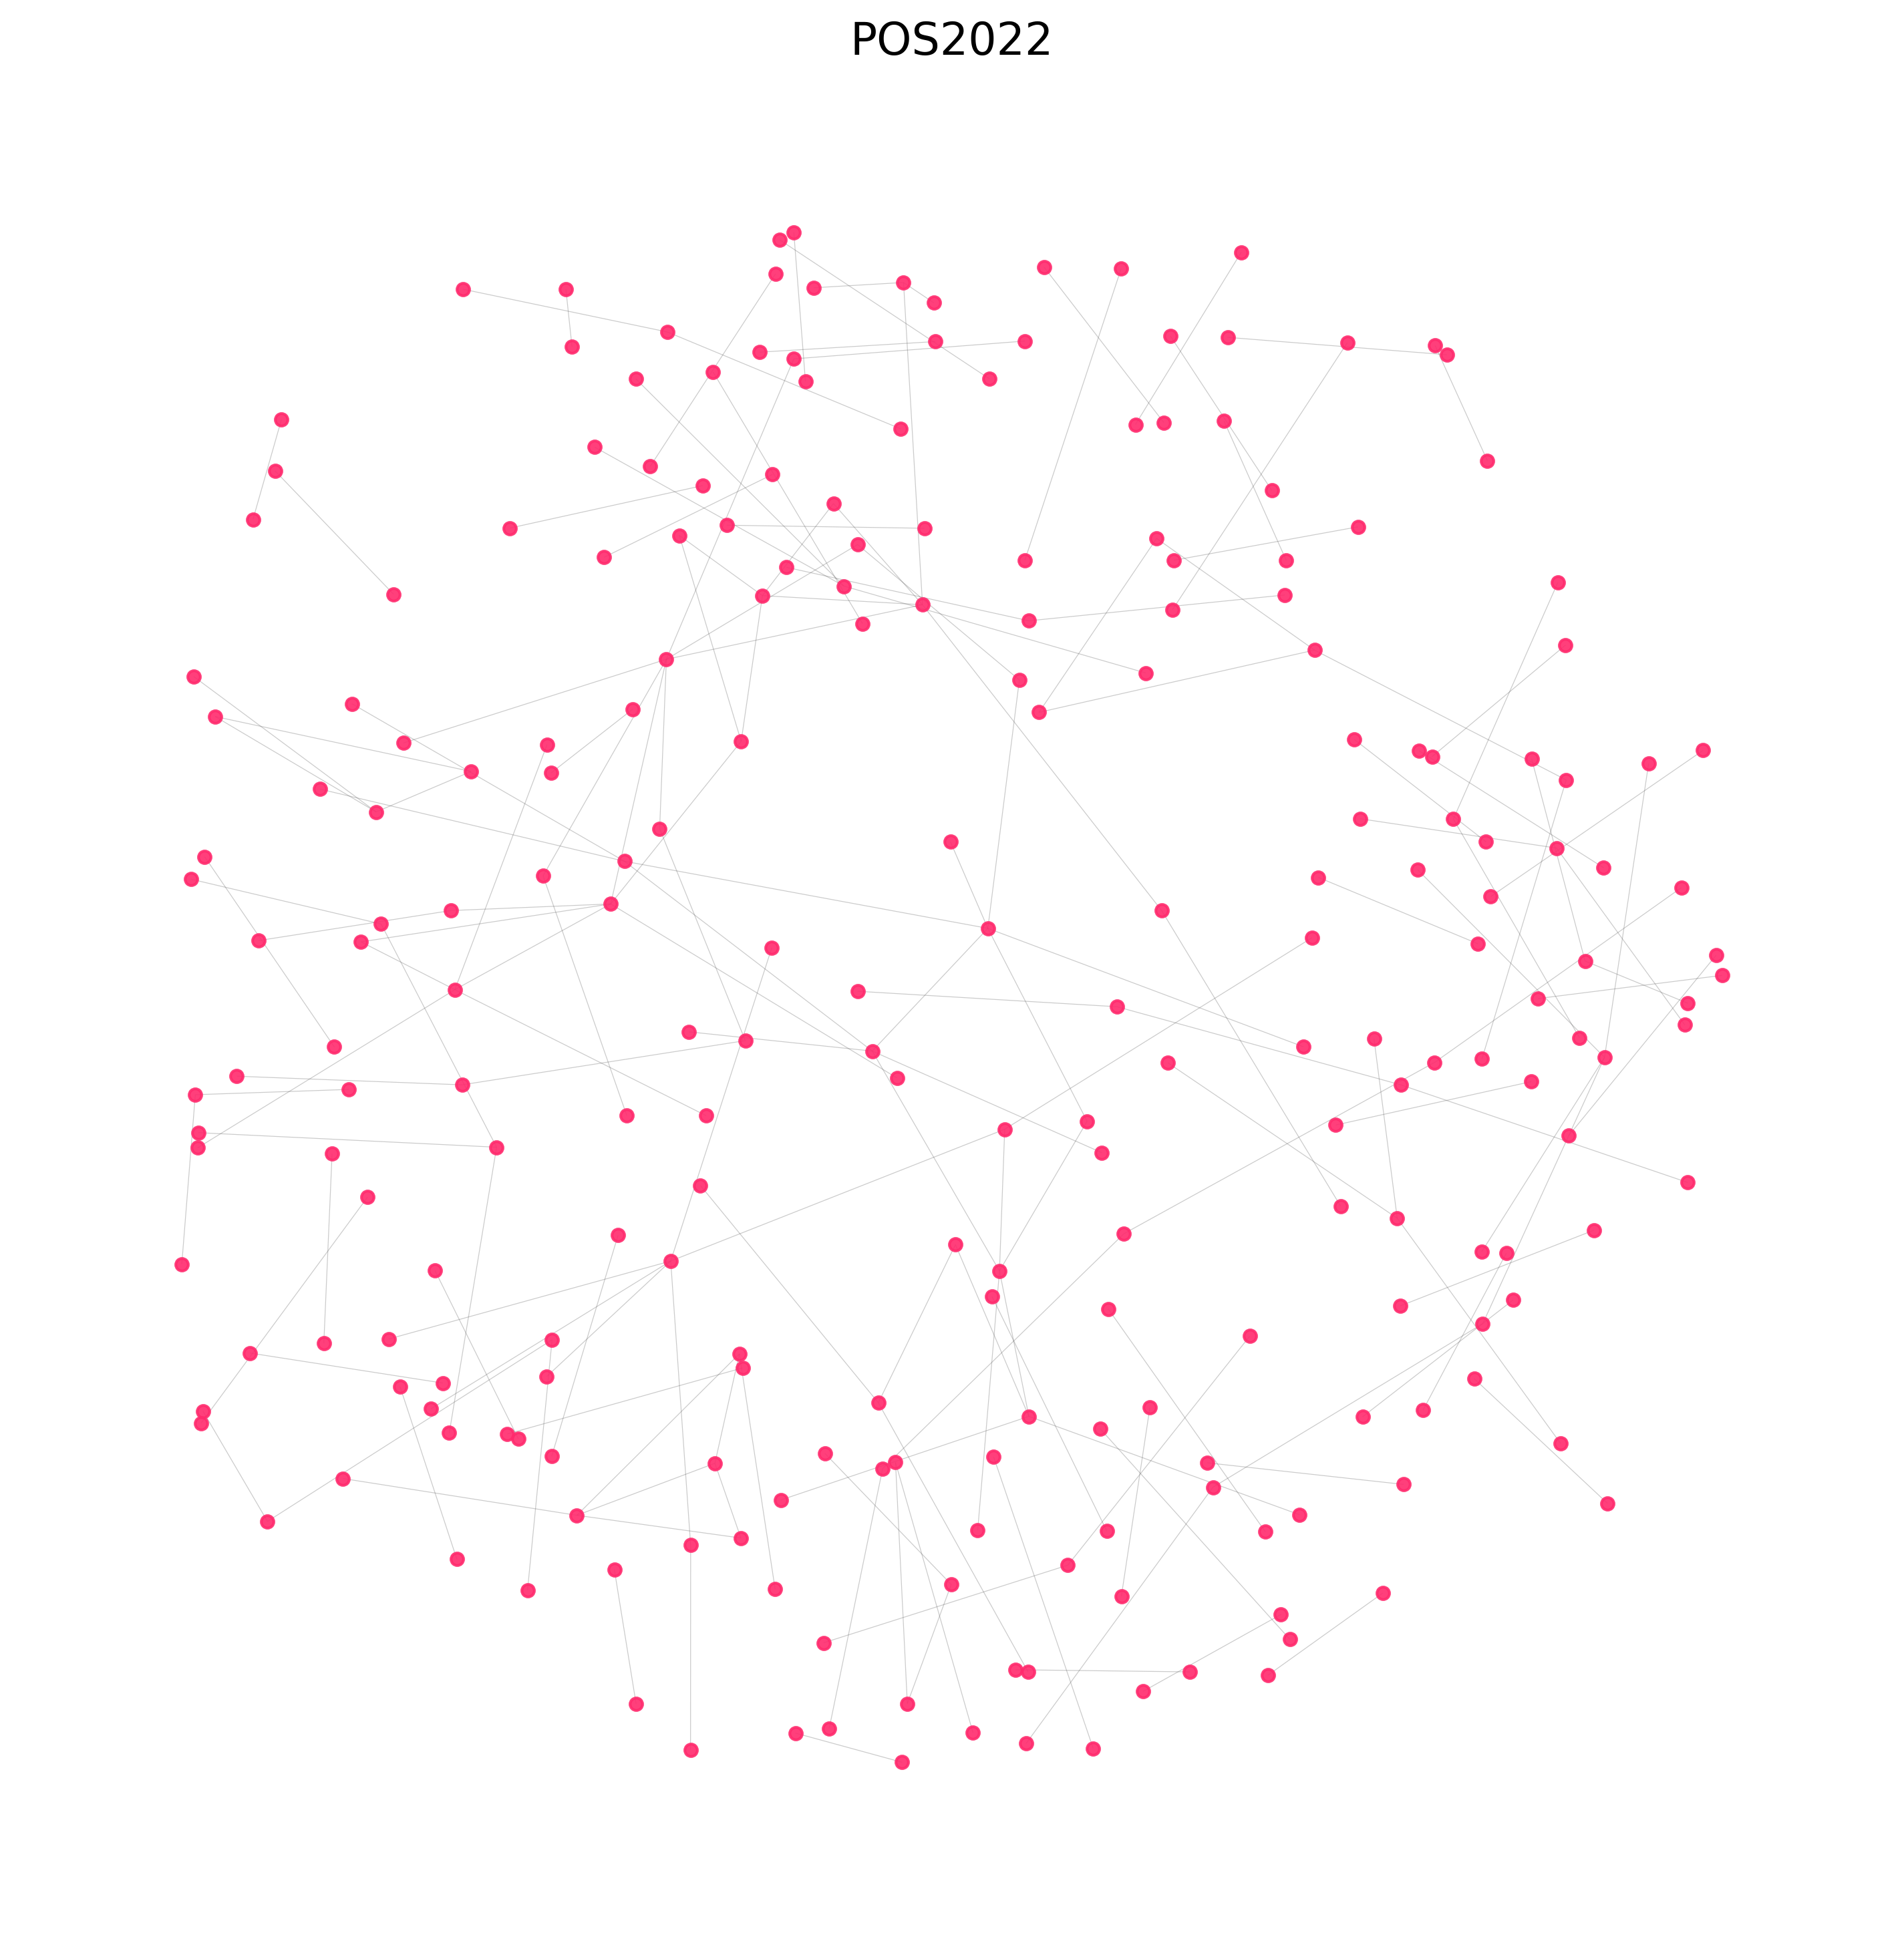

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- CONFIGURAÇÃO ---
ARQUIVO_ARESTAS = 'P2/P2_rede_coordenacao_final_07_60s.csv' # Ou o arquivo de arestas do P1
ARQUIVO_NOS = 'P2/p2_nos_e_comunidades.csv'

print("Carregando dados...")

# 1. Carregar Arestas
try:
    df_edges = pd.read_csv(ARQUIVO_ARESTAS)
    # Ajuste os nomes das colunas conforme seu CSV real (ex: Source, Target, Weight)
    # Se não tiver cabeçalho, use: header=None, names=['source', 'target', 'weight']
except:
    print("Erro: Verifique o nome do arquivo de arestas.")
    exit()

# 2. Criar o Grafo
G = nx.from_pandas_edgelist(df_edges, source='Source', target='Target', edge_attr='Weight')

# 3. Filtrar para limpar a visualização (Opcional: remove nós isolados ou muito pequenos)
# G = nx.k_core(G, k=2) # Mantém apenas quem tem pelo menos 2 conexões
print(f"Rede com {len(G.nodes())} nós e {len(G.edges())} arestas.")

# 4. Layout (Posicionamento dos nós) - Demora um pouco
print("Calculando layout (pode demorar)...")
# spring_layout é o mais comum. k ajusta a distância (maior = mais espaçado)
pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42) 

# 5. Desenhar
plt.figure(figsize=(12, 12), dpi=300) # 300 DPI é qualidade de impressão

# Desenha Nós
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='#ff2a6d', alpha=0.9)

# Desenha Arestas
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.3, edge_color='#555')

plt.axis('off') # Remove eixos
plt.title("POS2022", fontsize=16)

# 6. Salvar
plt.savefig("rede1_artigo_python.png", format="PNG", bbox_inches='tight', transparent=True)
print("✅ Imagem salva: rede_artigo_python.png")

Carregando dados...
Rede com 170 nós e 129 arestas.
Calculando layout (pode demorar)...
✅ Imagem salva: rede_artigo_python.png


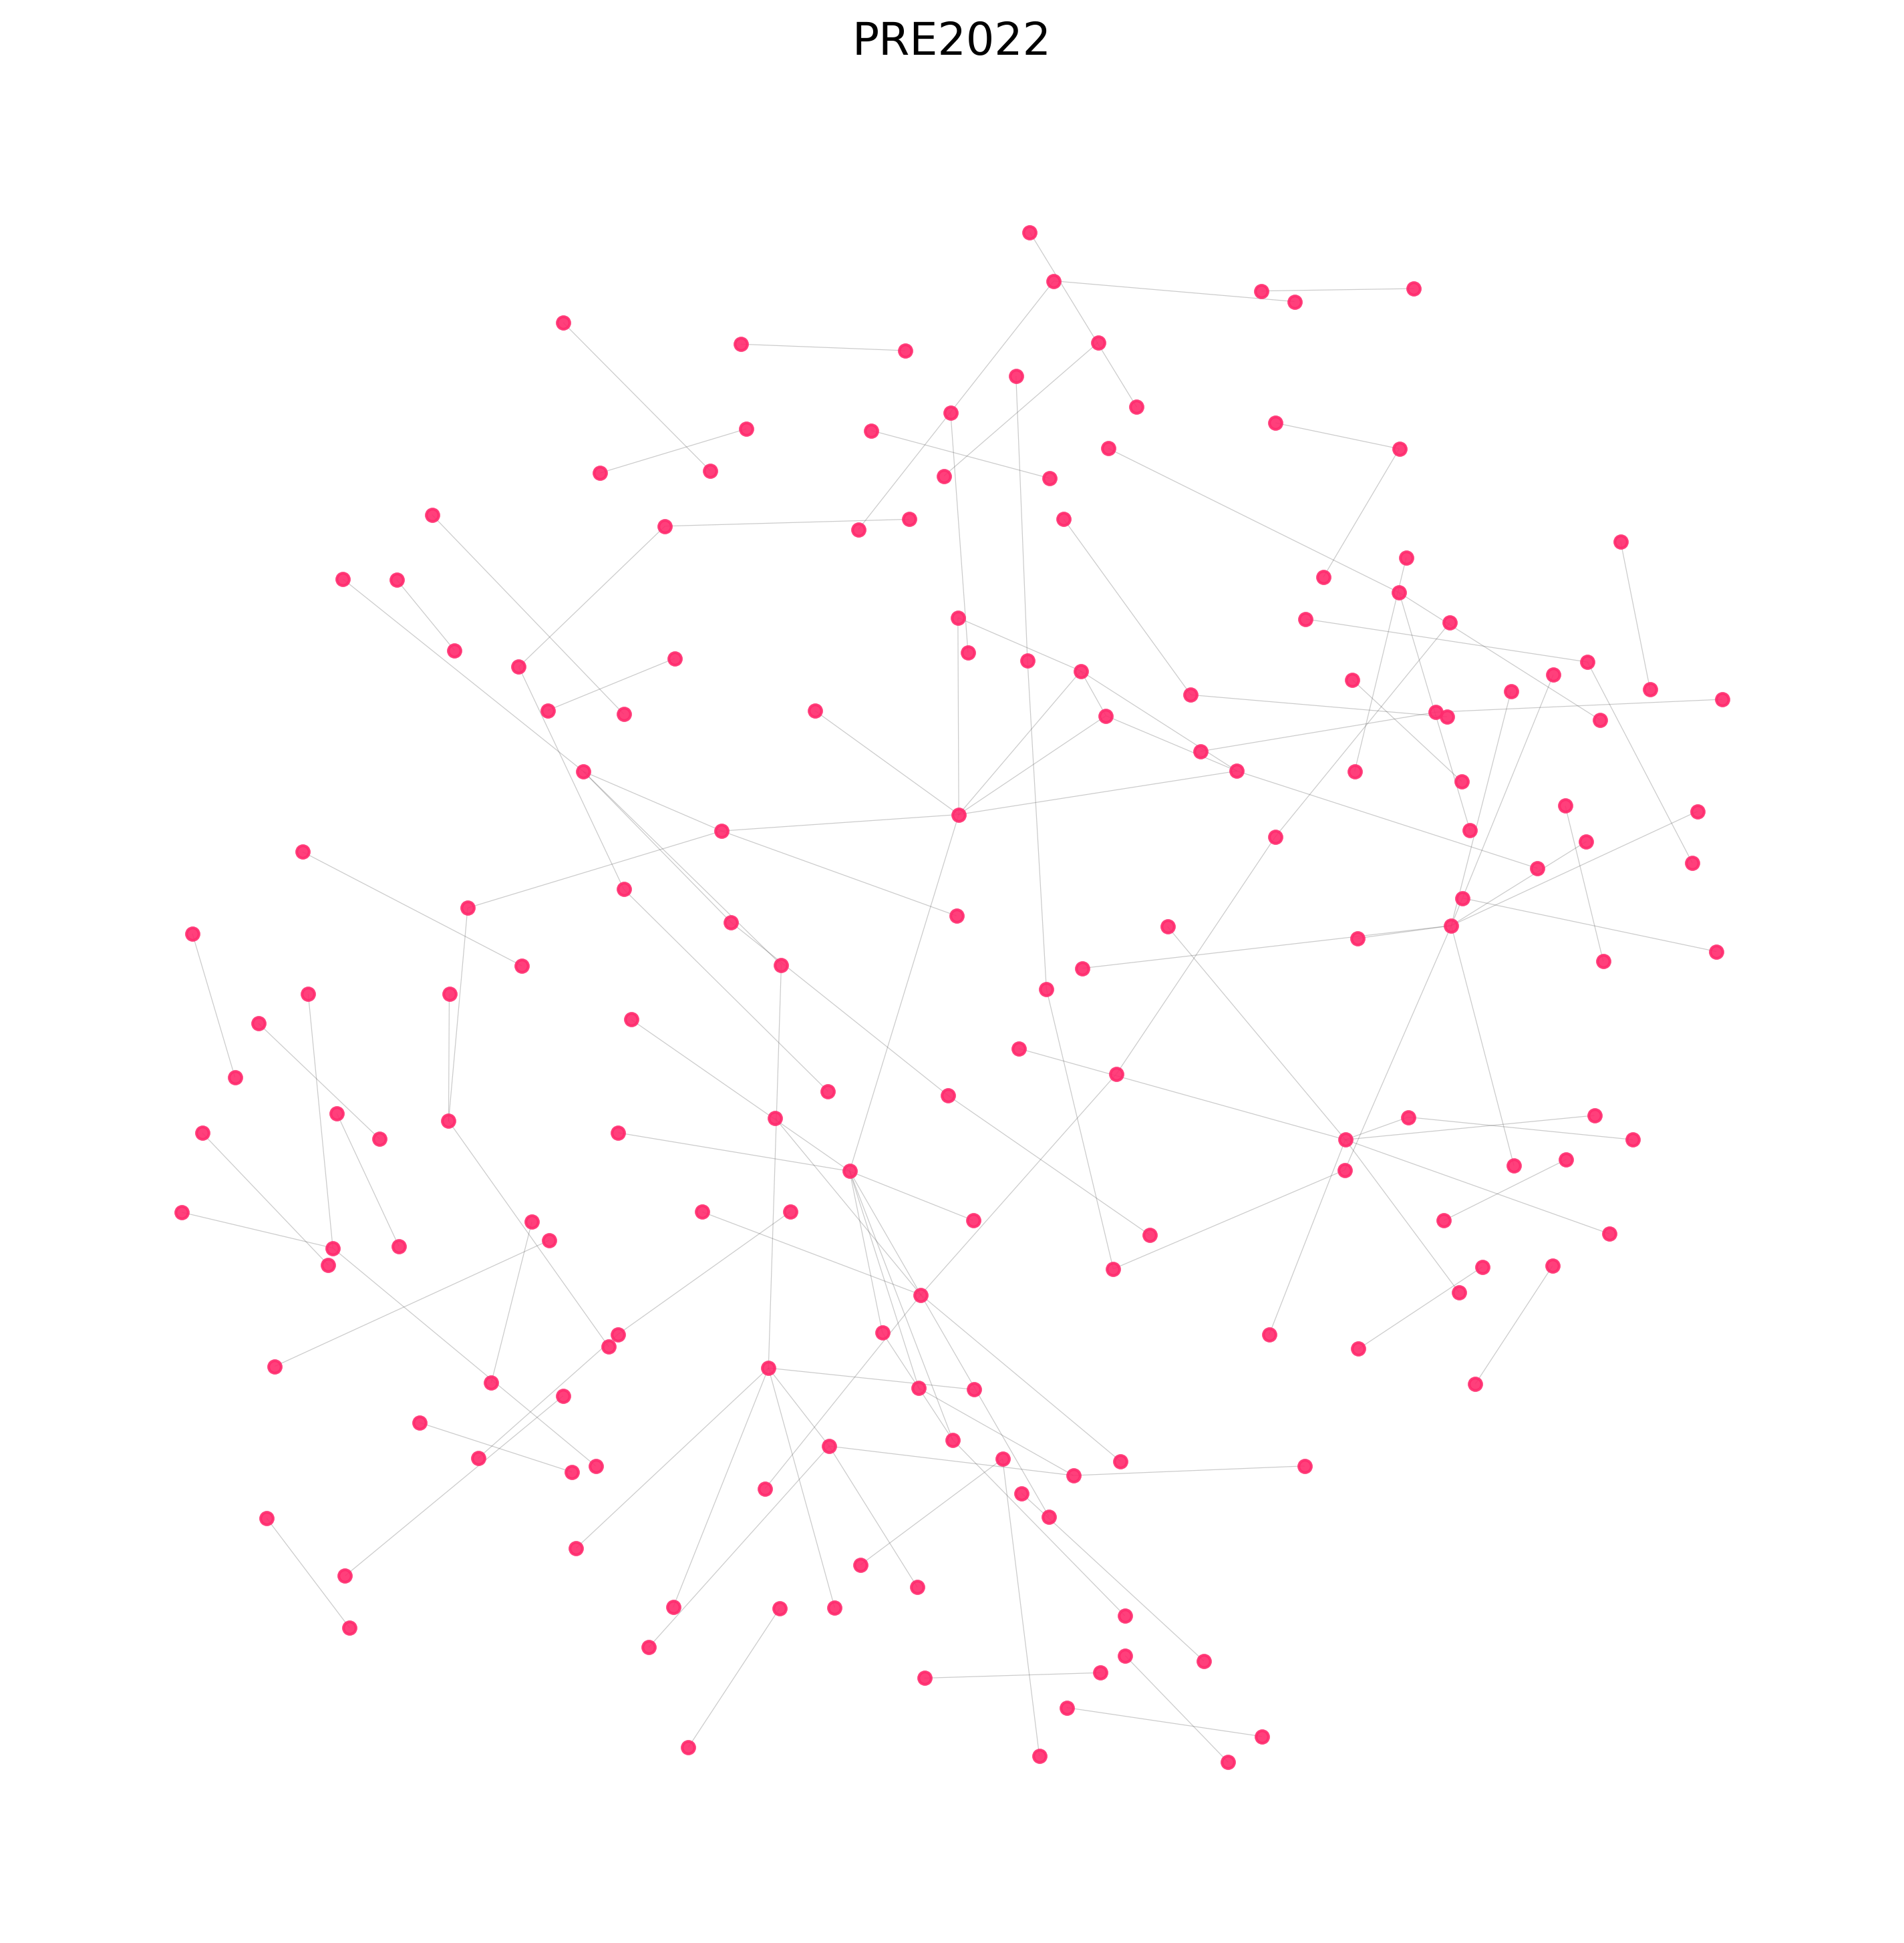

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- CONFIGURAÇÃO ---
ARQUIVO_ARESTAS = 'p1_v3/p1_rede_coordenacao_final_07_60s.csv' # Ou o arquivo de arestas do P1
ARQUIVO_NOS = 'p1_v3/p1_nos_e_comunidades.csv'

print("Carregando dados...")

# 1. Carregar Arestas
try:
    df_edges = pd.read_csv(ARQUIVO_ARESTAS)
    # Ajuste os nomes das colunas conforme seu CSV real (ex: Source, Target, Weight)
    # Se não tiver cabeçalho, use: header=None, names=['source', 'target', 'weight']
except:
    print("Erro: Verifique o nome do arquivo de arestas.")
    exit()

# 2. Criar o Grafo
G = nx.from_pandas_edgelist(df_edges, source='Source', target='Target', edge_attr='Weight')

# 3. Filtrar para limpar a visualização (Opcional: remove nós isolados ou muito pequenos)
# G = nx.k_core(G, k=2) # Mantém apenas quem tem pelo menos 2 conexões
print(f"Rede com {len(G.nodes())} nós e {len(G.edges())} arestas.")

# 4. Layout (Posicionamento dos nós) - Demora um pouco
print("Calculando layout (pode demorar)...")
# spring_layout é o mais comum. k ajusta a distância (maior = mais espaçado)
pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42) 

# 5. Desenhar
plt.figure(figsize=(12, 12), dpi=300) # 300 DPI é qualidade de impressão

# Desenha Nós
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='#ff2a6d', alpha=0.9)

# Desenha Arestas
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.3, edge_color='#555')

plt.axis('off') # Remove eixos
plt.title("PRE2022", fontsize=16)

# 6. Salvar
plt.savefig("rede2_artigo_python.png", format="PNG", bbox_inches='tight', transparent=True)
print("✅ Imagem salva: rede_artigo_python.png")

✅ Imagem salva: bubble_chart_artigo.png


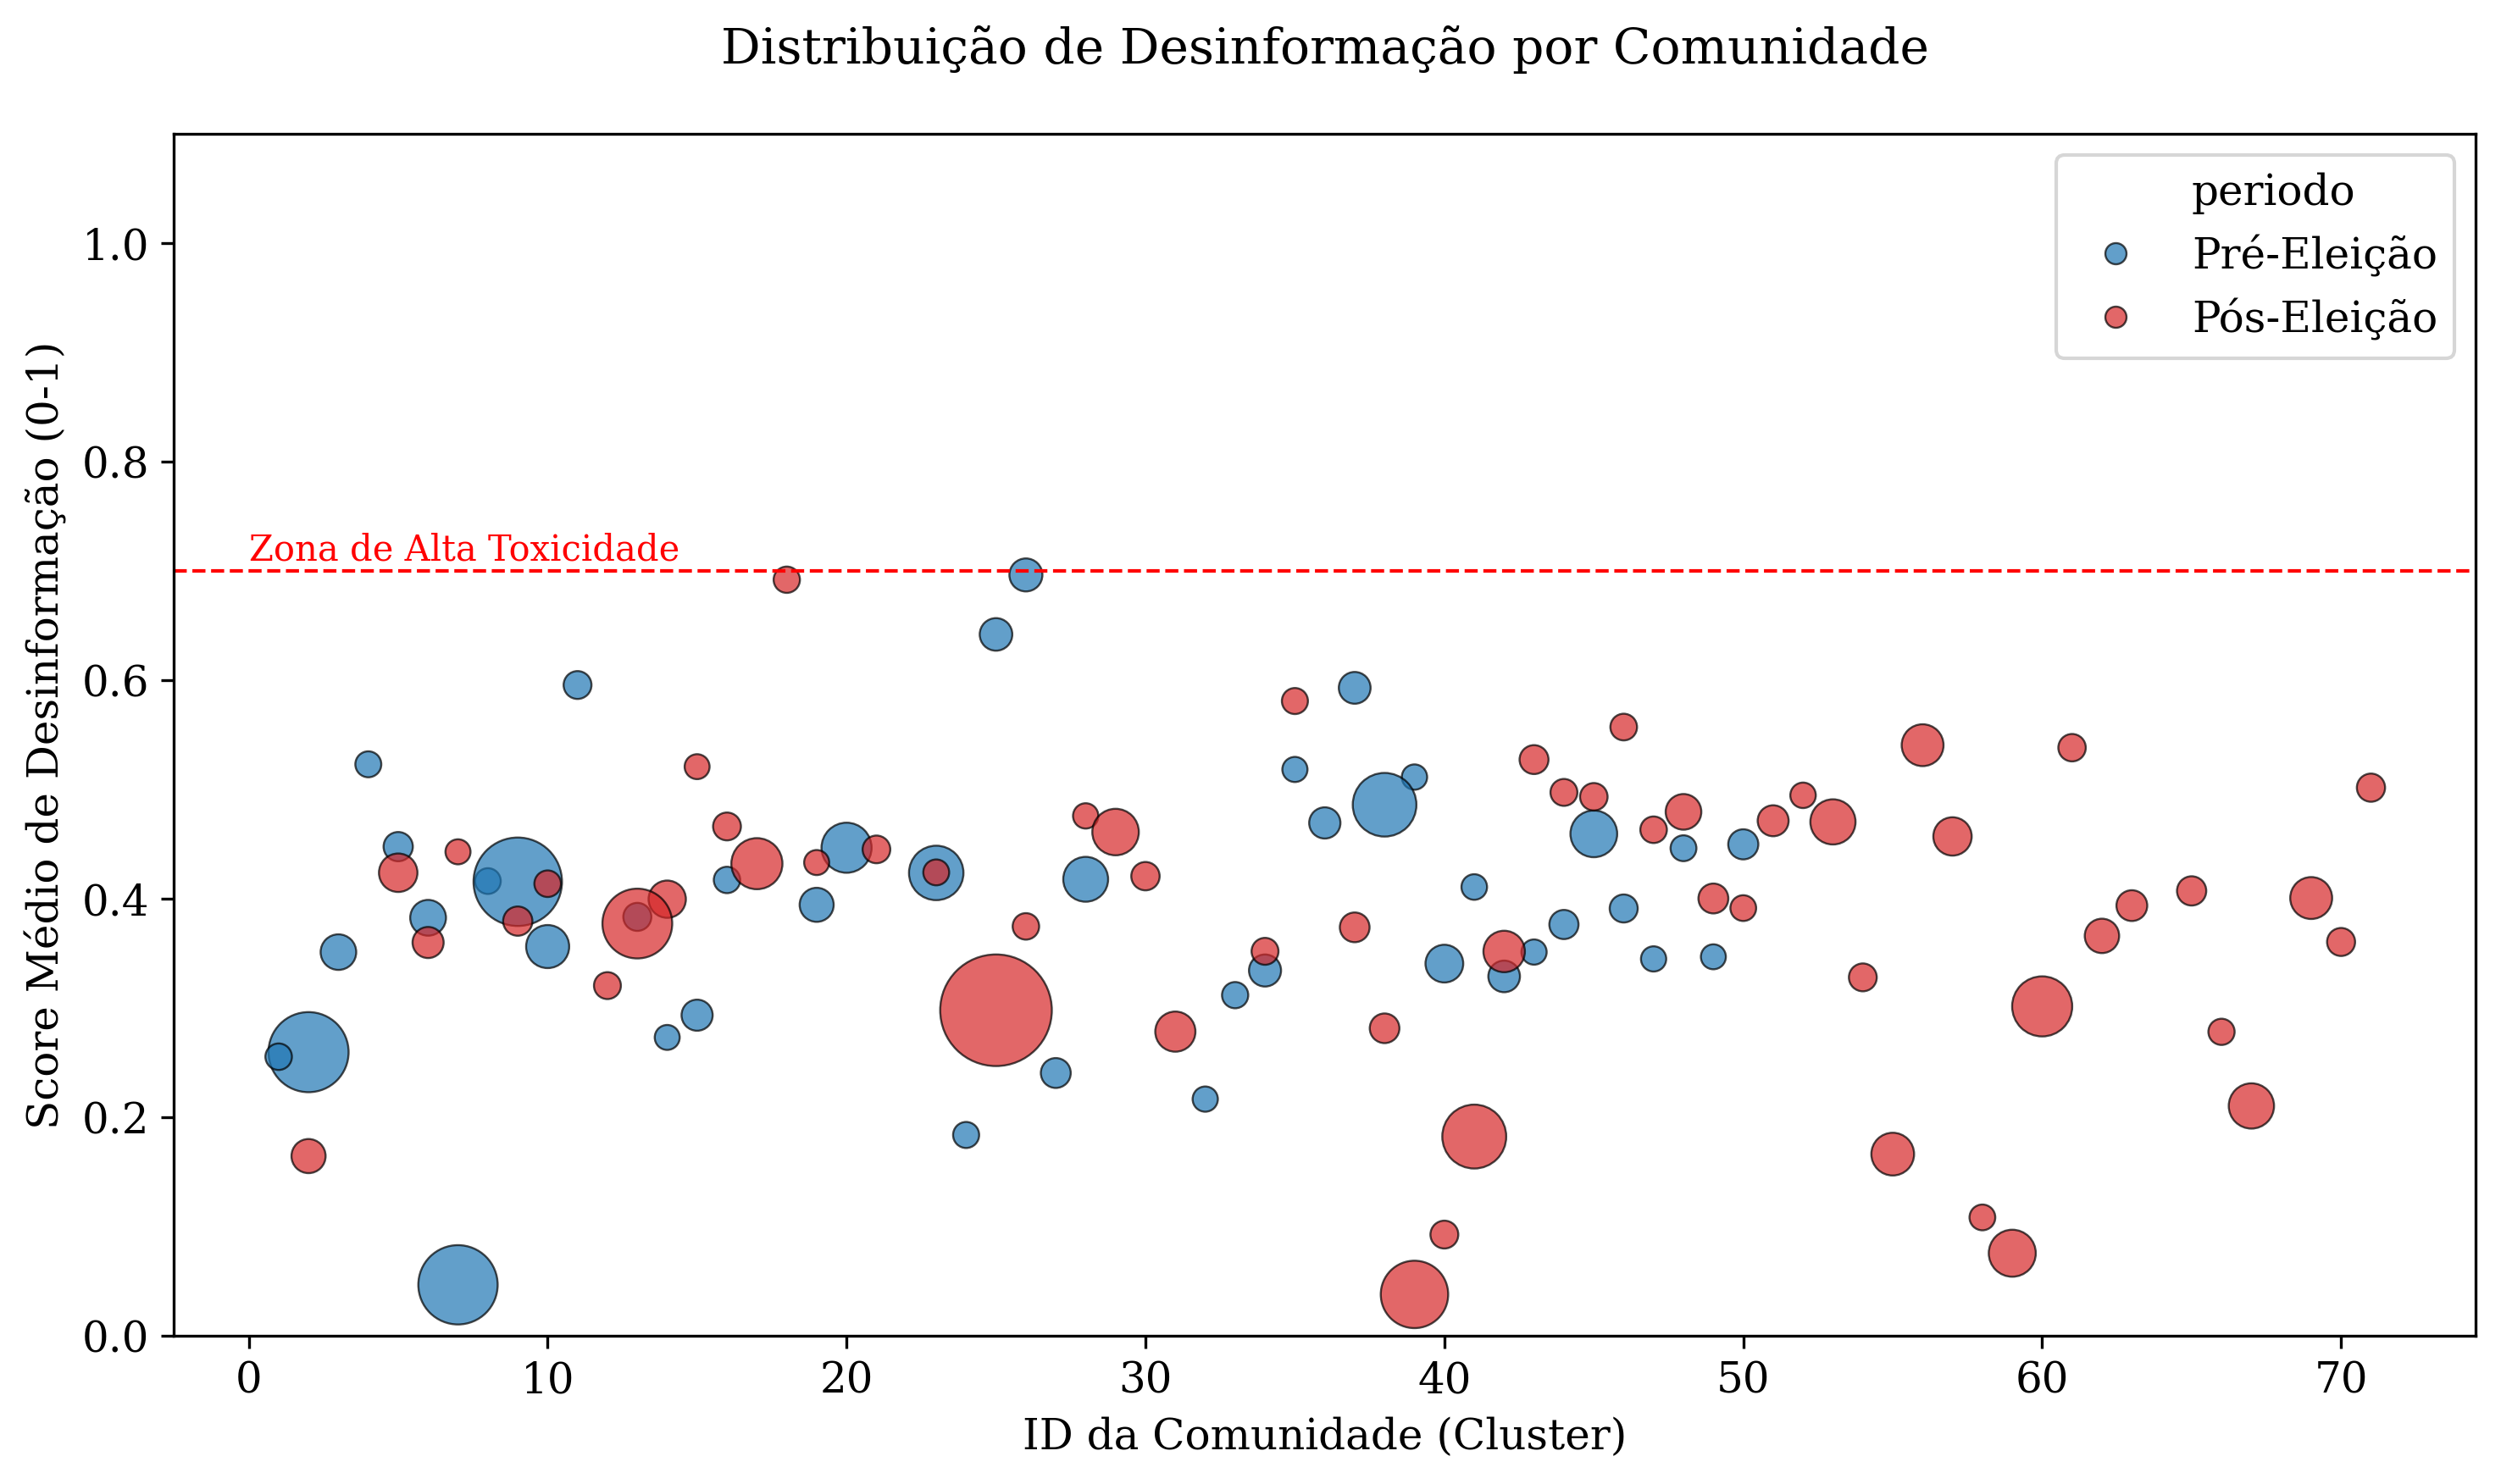

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- DADOS ---
# Usando os dados calculados anteriormente ou carregando dos CSVs
FILE_STATS_PRE = 'p1_v3/pre_relatorio_desinformacao_comunidades.csv'
FILE_STATS_POS = 'P2/pos_relatorio_desinformacao_comunidades.csv'

# Configuração de Estilo Acadêmico
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

def carregar_dados(caminho, label):
    try:
        df = pd.read_csv(caminho)
        df['periodo'] = label
        return df
    except:
        return pd.DataFrame()

df_pre = carregar_dados(FILE_STATS_PRE, 'Pré-Eleição')
df_pos = carregar_dados(FILE_STATS_POS, 'Pós-Eleição')
df_final = pd.concat([df_pre, df_pos])

if df_final.empty:
    print("❌ Arquivos não encontrados. Verifique os nomes.")
    exit()

# Filtrar ruído (comunidades muito pequenas)
df_final = df_final[df_final['count'] > 10]

# --- PLOTAGEM ---
fig, ax = plt.subplots(figsize=(10, 6), dpi=300) # 300 DPI para impressão

# Cores: Azul (Pré) e Vermelho (Pós)
palette = {'Pré-Eleição': '#1f77b4', 'Pós-Eleição': '#d62728'}

# Scatter Plot
# X = Comunidade ID (ou pode ser aleatório para espalhar), Y = Score Médio
# Tamanho da bolha = Volume
sns.scatterplot(
    data=df_final, 
    x='community_id', 
    y='mean', 
    size='count', 
    hue='periodo',
    sizes=(50, 1000), # Tamanho mínimo e máximo das bolhas
    palette=palette,
    alpha=0.7, # Transparência
    edgecolor='k', # Borda preta nas bolhas
    ax=ax
)

# Linha de corte perigoso
ax.axhline(0.7, color='red', linestyle='--', linewidth=1, label='Limiar Crítico (0.7)')
ax.text(0, 0.71, 'Zona de Alta Toxicidade', color='red', fontsize=10)

# Ajustes
ax.set_title('Distribuição de Desinformação por Comunidade', fontsize=14, pad=20)
ax.set_xlabel('ID da Comunidade (Cluster)', fontsize=12)
ax.set_ylabel('Score Médio de Desinformação (0-1)', fontsize=12)
ax.set_ylim(0, 1.1)

# Legenda limpa
handles, labels = ax.get_legend_handles_labels()
# Ajusta legenda para não ficar gigante por causa dos tamanhos
ax.legend(handles[0:3], labels[0:3], loc='upper right', frameon=True)

plt.tight_layout()
plt.savefig('bubble_chart_artigo.png', dpi=300)
print("✅ Imagem salva: bubble_chart_artigo.png")

In [5]:
pip install python-louvain networkx matplotlib pandas

  Using cached python-louvain-0.16.tar.gz (204 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9473 sha256=64109ca417ca233cf37bd9d4895c456e83f75c9864914279c29c0d0cd939451c
  Stored in directory: c:\users\nasci\appdata\local\pip\cache\wheels\ee\52\54\7ecd0f1ebf5f5a8466f70a27ed2b94d20b955376879d6159c5
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'python-louvain' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'python-louvain'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\nasci\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain # Caso precise recalcular, mas usaremos seus dados
import matplotlib.cm as cm
import numpy as np

# --- CONFIGURAÇÃO DOS ARQUIVOS ---
# Substitua pelos nomes exatos dos seus arquivos de ARESTAS (Source, Target)
ARQUIVO_ARESTAS_PRE = 'p1_v3/P1_rede_coordenacao_final_07_60s.csv' # Exemplo: nome do seu csv de arestas P1
ARQUIVO_ARESTAS_POS = 'P2/P2_rede_coordenacao_final_07_60s.csv' # Exemplo P2

# Substitua pelos arquivos de NÓS que contêm a coluna 'community_id' ou 'modularity_class'
ARQUIVO_NOS_PRE = 'p1_v3/P1_nos_e_comunidades.csv'
ARQUIVO_NOS_POS = 'P2/p2_nos_e_comunidades.csv'

def plotar_rede(arquivo_arestas, arquivo_nos, titulo, output_file):
    print(f"🔄 Processando: {titulo}...")
    
    try:
        # 1. Carregar Arestas
        df_edges = pd.read_csv(arquivo_arestas)
        # Ajuste para nomes comuns de colunas
        if 'Source' in df_edges.columns: 
            edges = df_edges[['Source', 'Target']]
        else:
            edges = df_edges.iloc[:, 0:2] # Pega as duas primeiras colunas
            edges.columns = ['Source', 'Target']

        # 2. Carregar Nós e Comunidades
        df_nodes = pd.read_csv(arquivo_nos)
        # Padronizar colunas
        cols = [c.lower() for c in df_nodes.columns]
        df_nodes.columns = cols
        
        # Identificar ID e Comunidade
        col_id = 'user_id' if 'user_id' in cols else 'id'
        col_comm = 'community_id' if 'community_id' in cols else 'modularity_class'
        
        if col_comm not in df_nodes.columns:
            print(f"⚠️ Coluna de comunidade não achada em {arquivo_nos}. Pulando.")
            return

        # Criar Dicionário de Comunidades
        partition = dict(zip(df_nodes[col_id].astype(str), df_nodes[col_comm]))

        # 3. Criar Grafo
        G = nx.from_pandas_edgelist(edges, source='Source', target='Target')
        
        # Filtrar nós: Manter apenas os que têm comunidade definida
        nodes_to_keep = [n for n in G.nodes() if str(n) in partition]
        G = G.subgraph(nodes_to_keep)
        
        print(f"   ℹ️ Rede com {len(G.nodes())} nós e {len(G.edges())} arestas.")
        
        # 4. Layout (Posicionamento espacial dos clusters)
        # spring_layout aproxima clusters conectados. k=0.1 controla o espaçamento.
        print("   ... Calculando layout (pode demorar)...")
        pos = nx.spring_layout(G, k=0.15, iterations=30, seed=42)
        
        # 5. Configurar Cores
        # Pega as comunidades únicas
        communities = list(set(partition.values()))
        num_communities = len(communities)
        
        # Gera uma paleta de cores (tab20 é boa para categorias distintas)
        cmap = cm.get_cmap('tab20', num_communities)
        
        # Atribui cor a cada nó
        node_colors = []
        for n in G.nodes():
            comm_id = partition[str(n)]
            # Mapeia o ID da comunidade para um índice de cor
            color_idx = communities.index(comm_id)
            node_colors.append(cmap(color_idx))

        # 6. Desenhar
        plt.figure(figsize=(12, 12), dpi=300) # Alta resolução
        plt.axis('off') # Remove bordas
        
        # Desenha Arestas (Cinza claro, finas, transparentes)
        nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='#999999', width=0.5)
        
        # Desenha Nós (Coloridos por comunidade)
        nx.draw_networkx_nodes(G, pos, 
                               node_size=30, 
                               node_color=node_colors, 
                               alpha=0.9, 
                               linewidths=0)
        
        plt.title(titulo, fontsize=18, fontfamily='serif')
        
        # Salvar
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
        plt.close()
        print(f"   ✅ Salvo: {output_file}")

    except Exception as e:
        print(f"   ❌ Erro ao gerar {titulo}: {e}")

# --- EXECUÇÃO ---
# Verifique se os nomes dos arquivos CSV correspondem aos seus
plotar_rede(ARQUIVO_ARESTAS_PRE, ARQUIVO_NOS_PRE, "Estrutura de Clusters: Pré-Eleição", "rede_clusters_pre.png")
plotar_rede(ARQUIVO_ARESTAS_POS, ARQUIVO_NOS_POS, "Estrutura de Clusters: Pós-Eleição", "rede_clusters_pos.png")

🔄 Processando: Estrutura de Clusters: Pré-Eleição...
   ℹ️ Rede com 170 nós e 129 arestas.
   ... Calculando layout (pode demorar)...


C:\Users\nasci\AppData\Local\Temp\ipykernel_28136\2865808055.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_communities)


   ✅ Salvo: rede_clusters_pre.png
🔄 Processando: Estrutura de Clusters: Pós-Eleição...
   ℹ️ Rede com 237 nós e 176 arestas.
   ... Calculando layout (pode demorar)...


C:\Users\nasci\AppData\Local\Temp\ipykernel_28136\2865808055.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_communities)


   ✅ Salvo: rede_clusters_pos.png


1. Carregando dados...
2. Calculando layout 'Ilhas' para 170 nós...
3. Desenhando...
✅ Sucesso! Imagem salva: rede_pre_agrupada.png


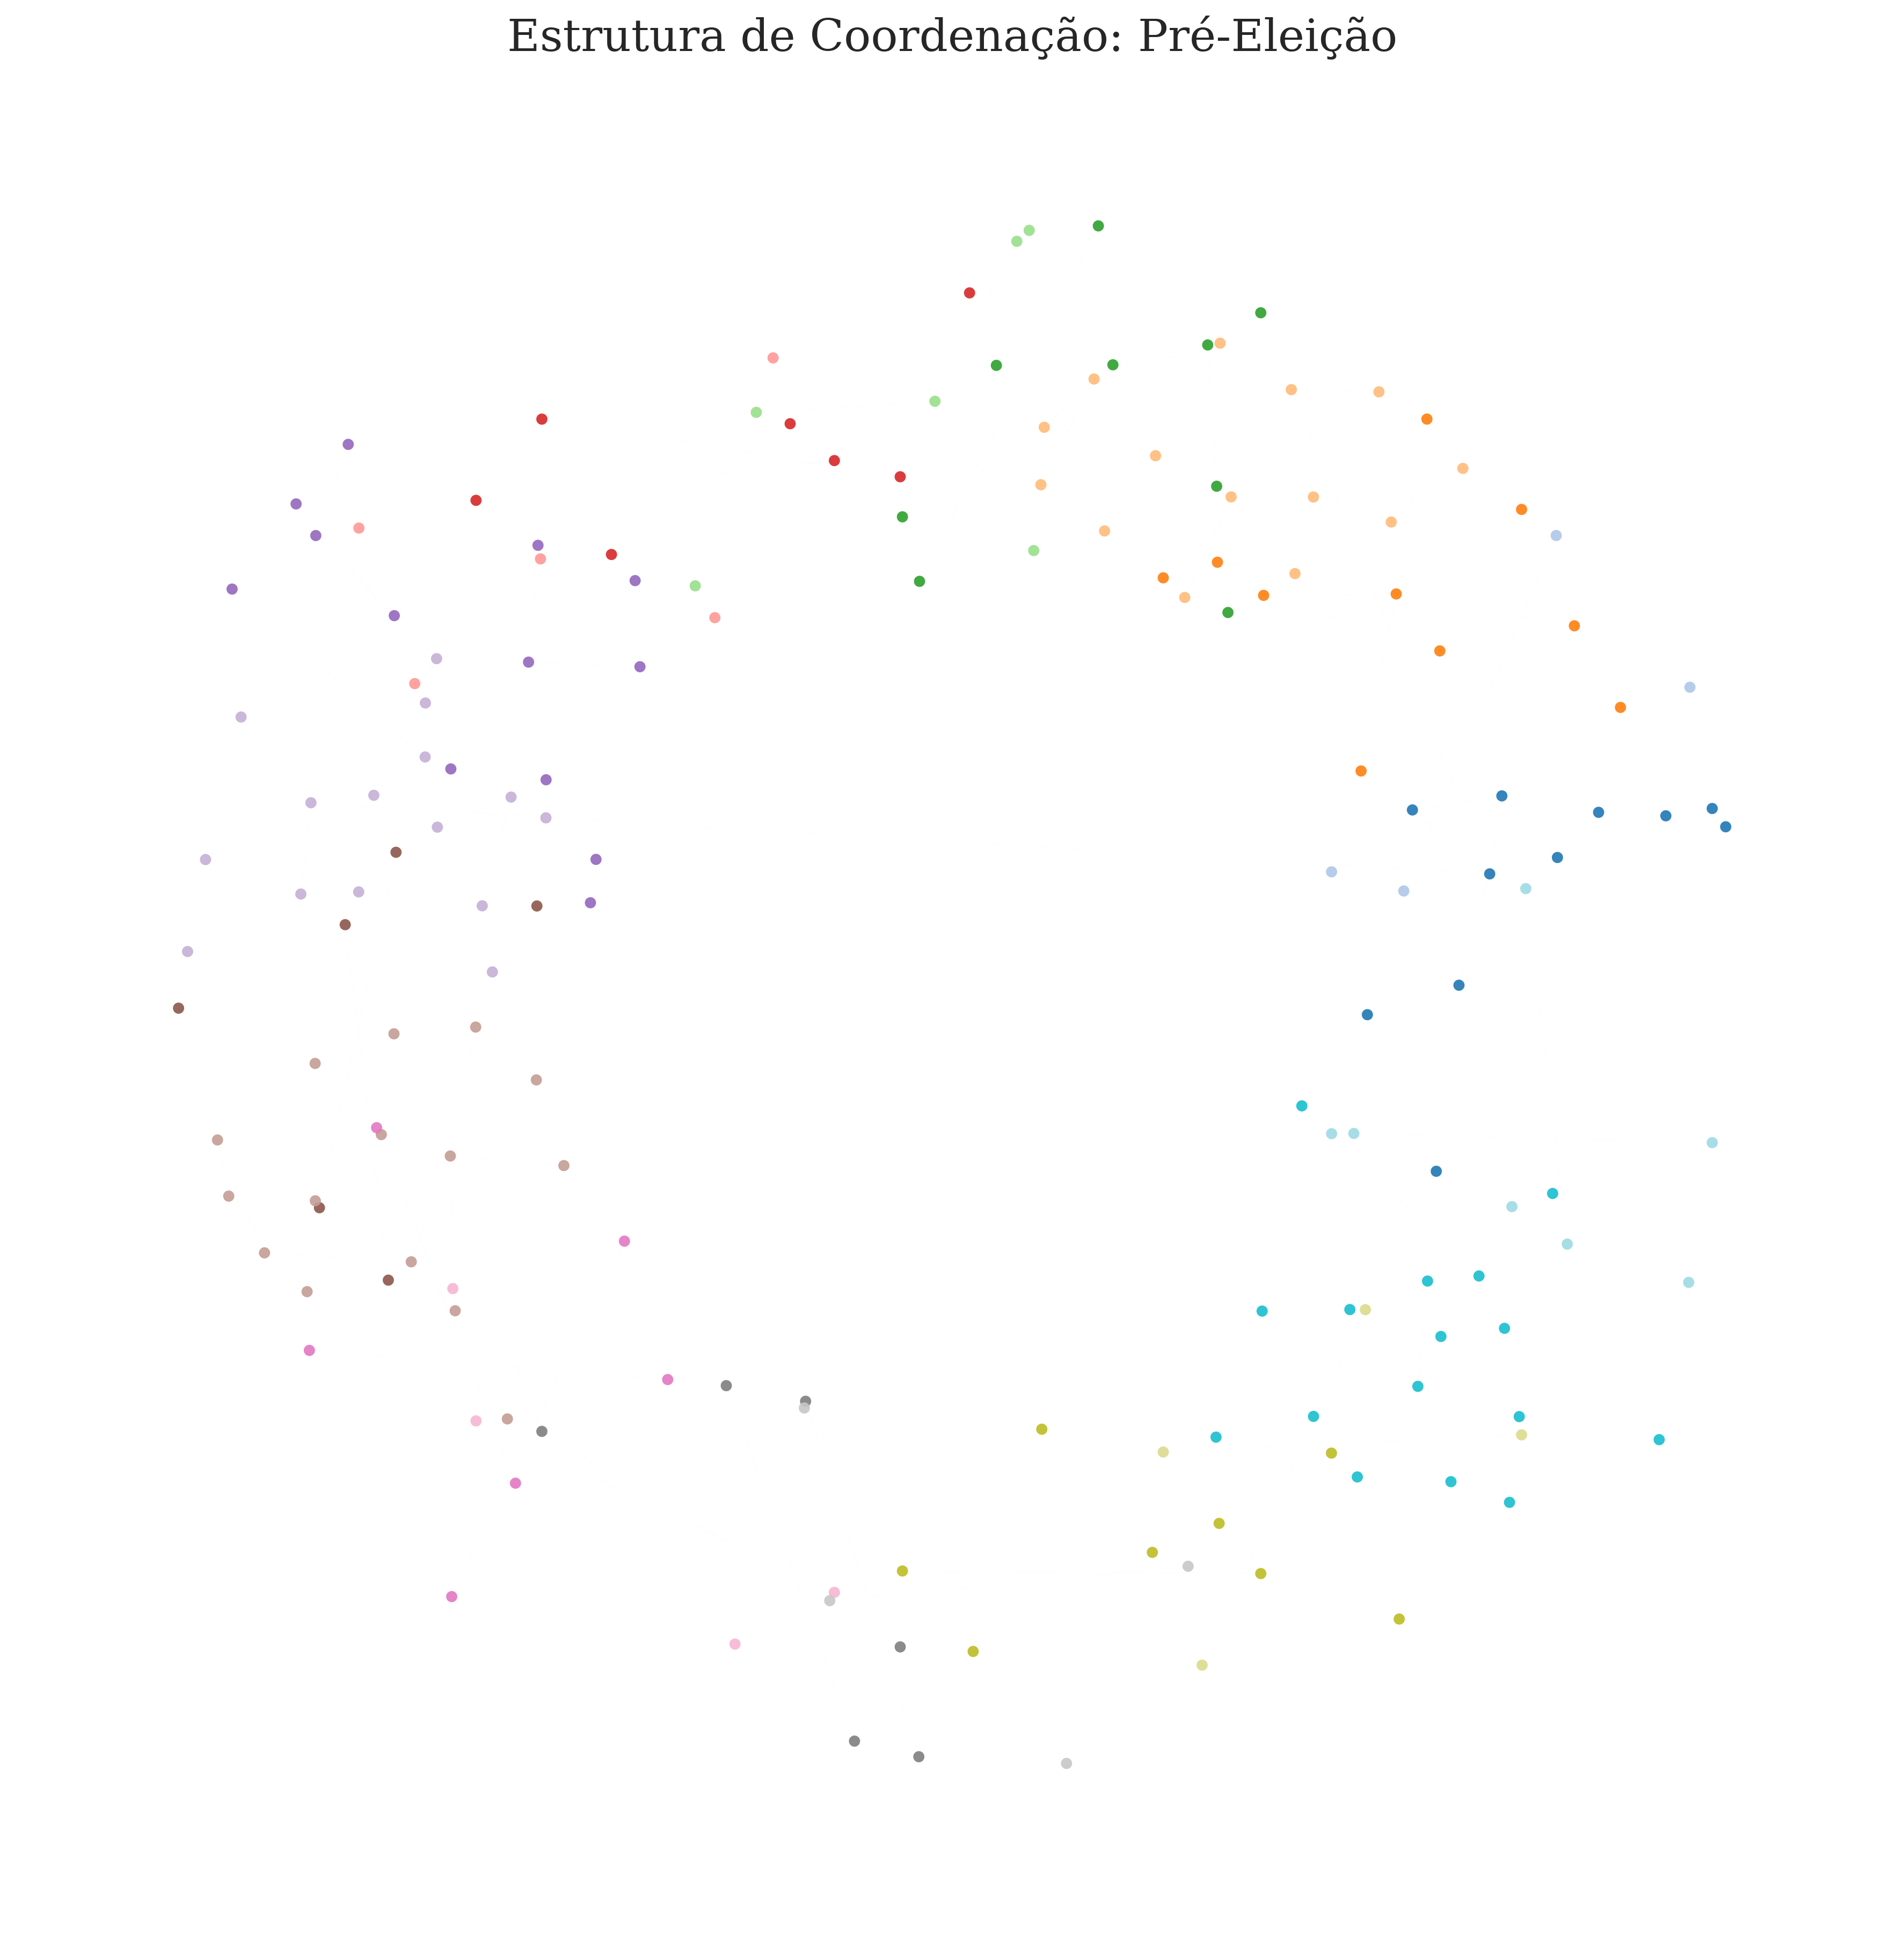

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# --- SEUS ARQUIVOS ---
# Ajuste os nomes conforme necessário
ARQUIVO_ARESTAS = 'p1_v3/P1_rede_coordenacao_final_07_60s.csv' 
ARQUIVO_NOS = 'p1_v3/P1_nos_e_comunidades.csv'
TITULO = "Estrutura de Coordenação: Pré-Eleição"
OUTPUT = "rede_pre_agrupada.png"

def plotar_rede_separada():
    print("1. Carregando dados...")
    # Carregar Arestas
    df_edges = pd.read_csv(ARQUIVO_ARESTAS)
    source_col = df_edges.columns[0]
    target_col = df_edges.columns[1]
    
    # Carregar Nós e Comunidades
    df_nodes = pd.read_csv(ARQUIVO_NOS)
    df_nodes.columns = [c.lower() for c in df_nodes.columns] # Normaliza colunas
    
    # Achar colunas certas
    col_id = 'user_id' if 'user_id' in df_nodes.columns else 'id'
    # Tenta achar a coluna de comunidade (vários nomes possíveis)
    possiveis = ['community_id', 'modularity_class', 'comunidade', 'cluster']
    col_comm = next((c for c in possiveis if c in df_nodes.columns), None)
    
    if not col_comm:
        print("Erro: Coluna de comunidade não encontrada!")
        return

    # Dicionário ID -> Comunidade
    partition = dict(zip(df_nodes[col_id].astype(str), df_nodes[col_comm]))
    
    # Criar Grafo
    G = nx.from_pandas_edgelist(df_edges, source=source_col, target=target_col)
    
    # Manter apenas nós com comunidade definida
    nodes_to_keep = [n for n in G.nodes() if str(n) in partition]
    G = G.subgraph(nodes_to_keep)
    
    print(f"2. Calculando layout 'Ilhas' para {len(G.nodes())} nós...")
    
    # --- O PULO DO GATO: Layout Setorial ---
    pos = {}
    comunidades = list(set(partition.values()))
    # Remove comunidades minúsculas (ruído) para limpar o gráfico
    # comunidades = [c for c in comunidades if list(partition.values()).count(c) > 10]
    
    num_comunidades = len(comunidades)
    raio_maior = 10  # Raio do círculo onde ficam os centros das comunidades
    raio_menor = 3   # Raio de dispersão dos nós dentro da comunidade
    
    for i, comm_id in enumerate(comunidades):
        # 1. Define o centro da comunidade no círculo maior
        angulo = 2 * np.pi * i / num_comunidades
        centro_x = raio_maior * np.cos(angulo)
        centro_y = raio_maior * np.sin(angulo)
        
        # 2. Pega nós dessa comunidade
        nods_comm = [n for n in G.nodes() if partition[str(n)] == comm_id]
        if not nods_comm: continue
            
        # 3. Cria subgrafo só para calcular layout interno
        subG = G.subgraph(nods_comm)
        
        # 4. Calcula posição relativa (layout spring local)
        pos_local = nx.spring_layout(subG, k=0.5, iterations=20)
        
        # 5. Translada para o centro da comunidade
        for node, coords in pos_local.items():
            pos[node] = (coords[0] * raio_menor + centro_x, coords[1] * raio_menor + centro_y)

    print("3. Desenhando...")
    plt.figure(figsize=(15, 15), dpi=300) # Alta resolução
    
    # Cores
    colors = [partition[str(n)] for n in G.nodes()]
    
    # Arestas (Muito finas para não poluir)
    nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color='#cccccc', width=0.2)
    
    # Nós
    nx.draw_networkx_nodes(G, pos, 
                           node_size=25, 
                           node_color=colors, 
                           cmap=plt.cm.tab20, # Paleta de cores distintas
                           alpha=0.9, 
                           linewidths=0)
    
    plt.axis('off')
    plt.title(TITULO, fontsize=20, fontfamily='serif')
    plt.savefig(OUTPUT, bbox_inches='tight')
    print(f"✅ Sucesso! Imagem salva: {OUTPUT}")

# Rode a função
plotar_rede_separada()

1. Carregando dados...
2. Calculando layout 'Ilhas' para 237 nós...
3. Desenhando...
✅ Sucesso! Imagem salva: rede_pre_agrupada.png


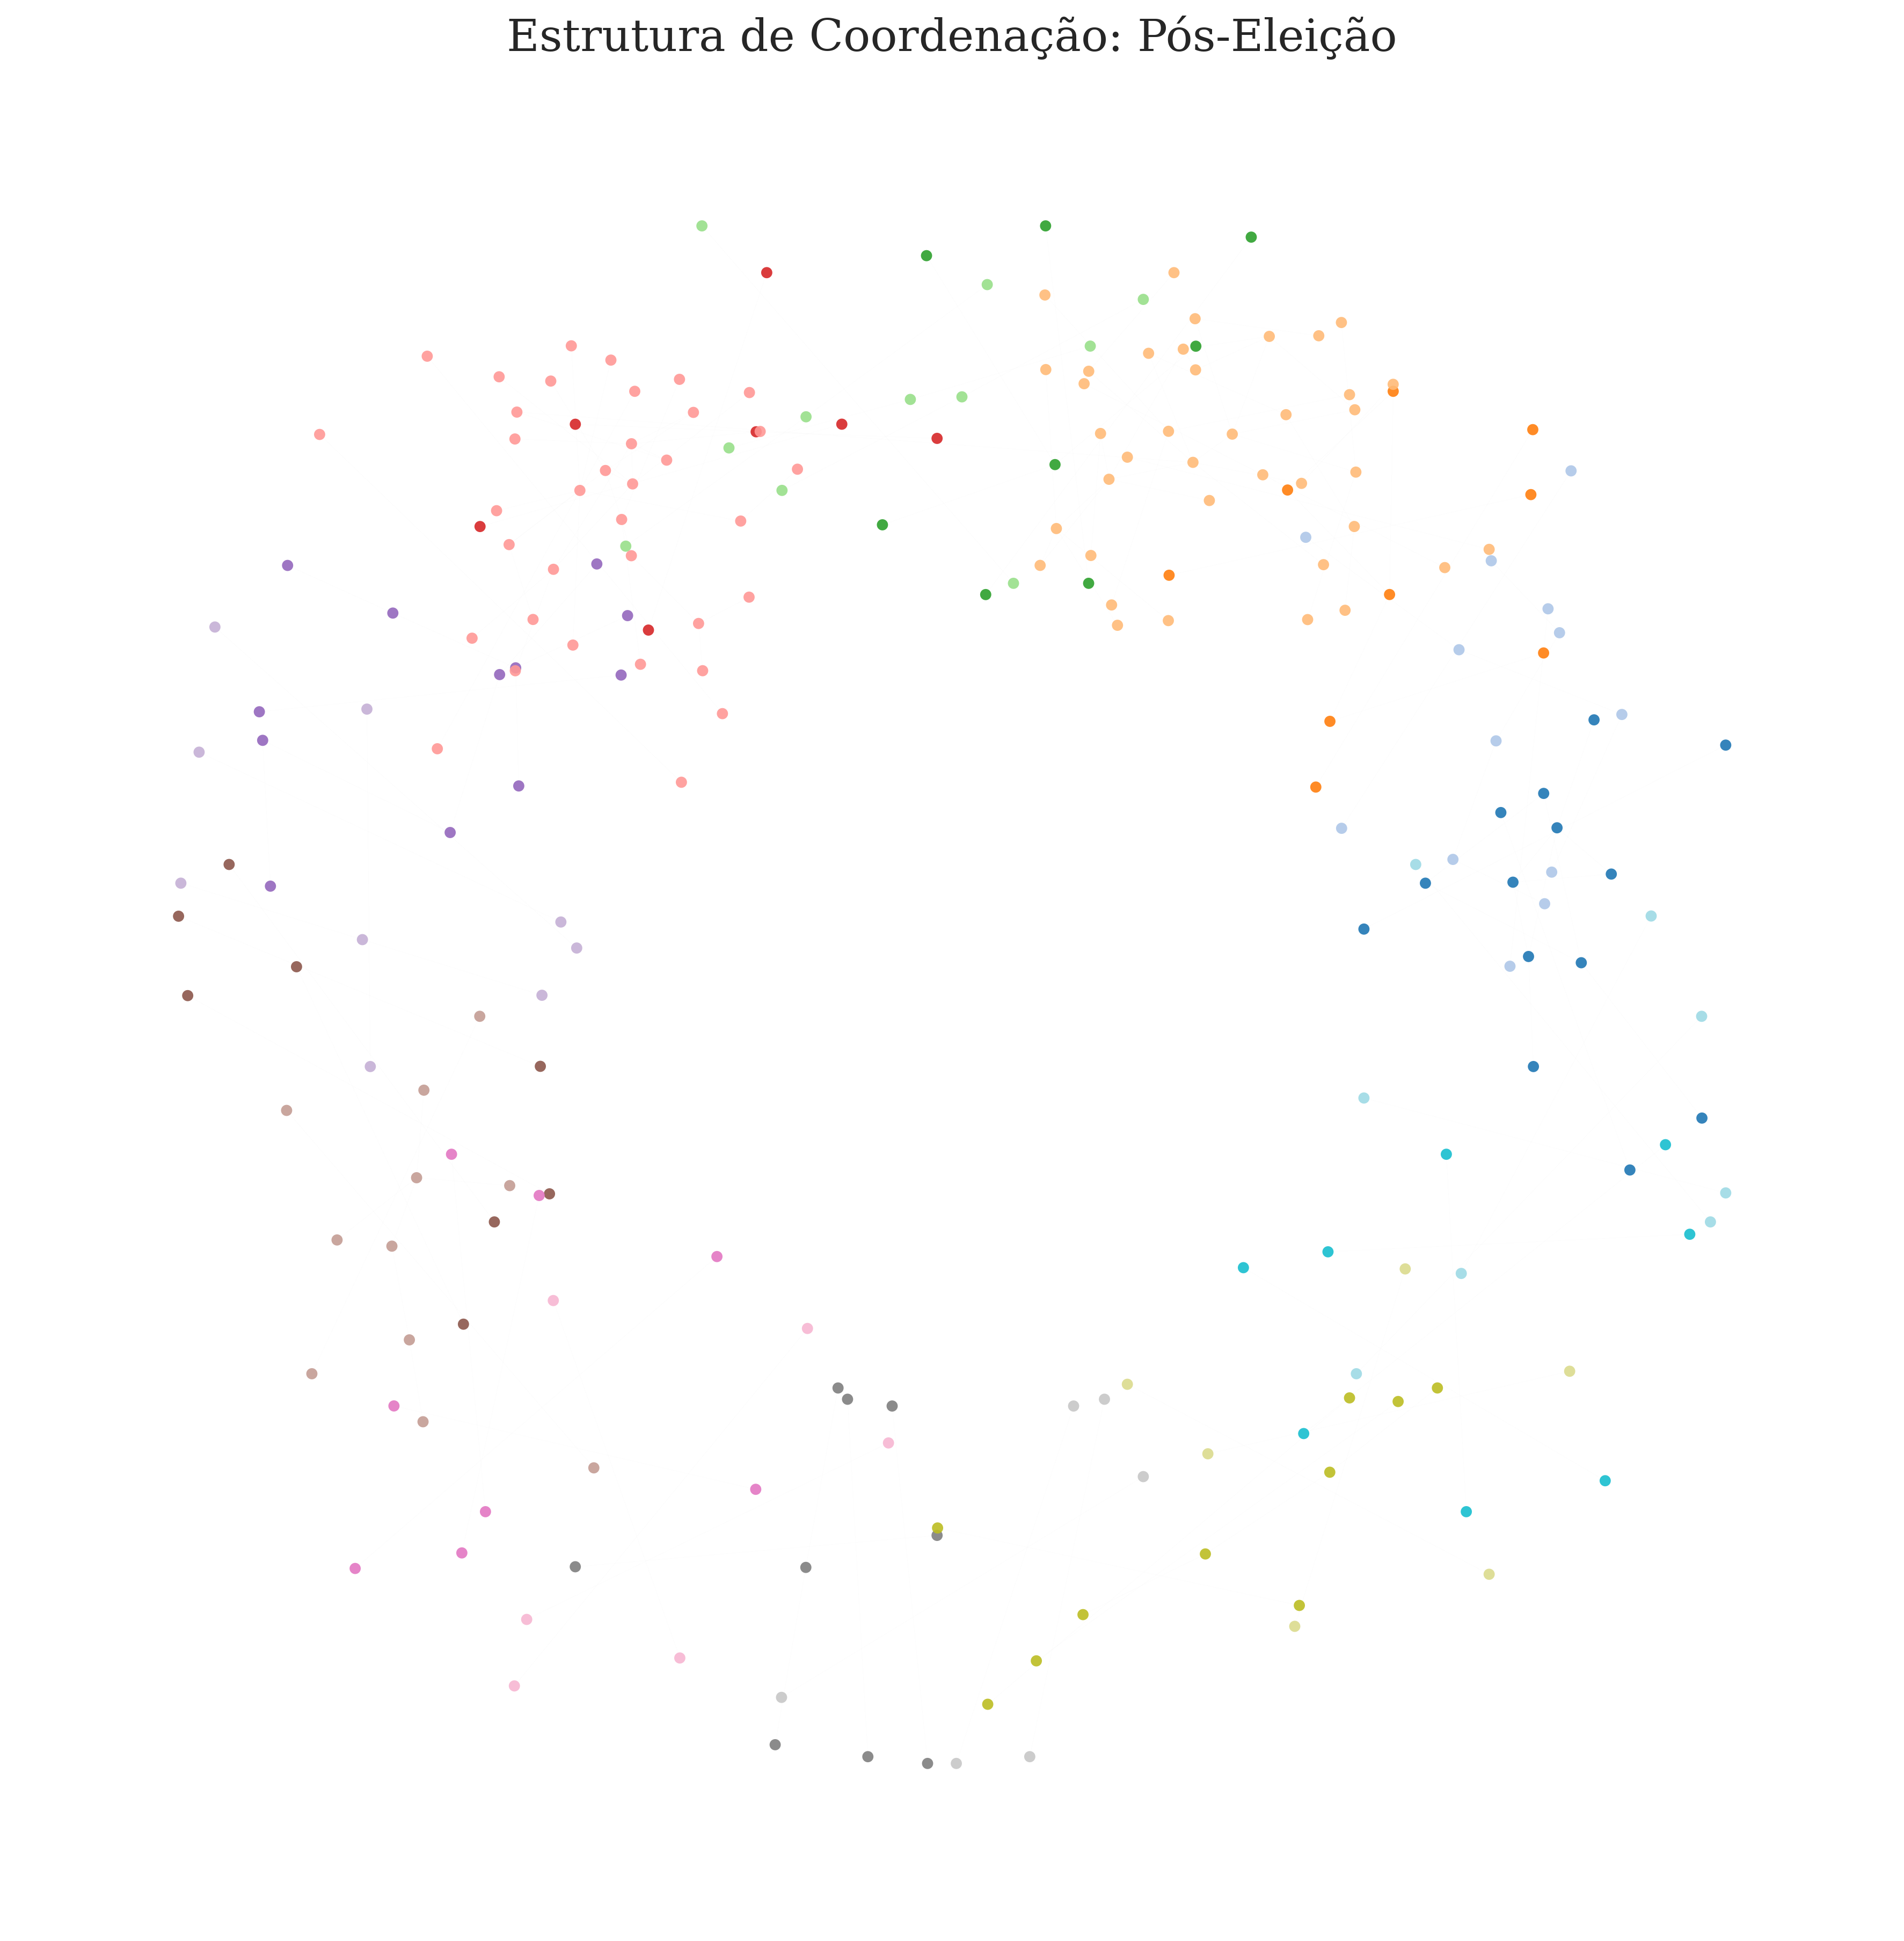

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# --- SEUS ARQUIVOS ---
# Ajuste os nomes conforme necessário
ARQUIVO_ARESTAS = 'P2/P2_rede_coordenacao_final_07_60s.csv' 
ARQUIVO_NOS = 'P2/P2_nos_e_comunidades.csv'
TITULO = "Estrutura de Coordenação: Pós-Eleição"
OUTPUT = "rede_pre_agrupada.png"

def plotar_rede_separada():
    print("1. Carregando dados...")
    # Carregar Arestas
    df_edges = pd.read_csv(ARQUIVO_ARESTAS)
    source_col = df_edges.columns[0]
    target_col = df_edges.columns[1]
    
    # Carregar Nós e Comunidades
    df_nodes = pd.read_csv(ARQUIVO_NOS)
    df_nodes.columns = [c.lower() for c in df_nodes.columns] # Normaliza colunas
    
    # Achar colunas certas
    col_id = 'user_id' if 'user_id' in df_nodes.columns else 'id'
    # Tenta achar a coluna de comunidade (vários nomes possíveis)
    possiveis = ['community_id', 'modularity_class', 'comunidade', 'cluster']
    col_comm = next((c for c in possiveis if c in df_nodes.columns), None)
    
    if not col_comm:
        print("Erro: Coluna de comunidade não encontrada!")
        return

    # Dicionário ID -> Comunidade
    partition = dict(zip(df_nodes[col_id].astype(str), df_nodes[col_comm]))
    
    # Criar Grafo
    G = nx.from_pandas_edgelist(df_edges, source=source_col, target=target_col)
    
    # Manter apenas nós com comunidade definida
    nodes_to_keep = [n for n in G.nodes() if str(n) in partition]
    G = G.subgraph(nodes_to_keep)
    
    print(f"2. Calculando layout 'Ilhas' para {len(G.nodes())} nós...")
    
    # --- O PULO DO GATO: Layout Setorial ---
    pos = {}
    comunidades = list(set(partition.values()))
    # Remove comunidades minúsculas (ruído) para limpar o gráfico
    # comunidades = [c for c in comunidades if list(partition.values()).count(c) > 10]
    
    num_comunidades = len(comunidades)
    raio_maior = 10  # Raio do círculo onde ficam os centros das comunidades
    raio_menor = 3   # Raio de dispersão dos nós dentro da comunidade
    
    for i, comm_id in enumerate(comunidades):
        # 1. Define o centro da comunidade no círculo maior
        angulo = 2 * np.pi * i / num_comunidades
        centro_x = raio_maior * np.cos(angulo)
        centro_y = raio_maior * np.sin(angulo)
        
        # 2. Pega nós dessa comunidade
        nods_comm = [n for n in G.nodes() if partition[str(n)] == comm_id]
        if not nods_comm: continue
            
        # 3. Cria subgrafo só para calcular layout interno
        subG = G.subgraph(nods_comm)
        
        # 4. Calcula posição relativa (layout spring local)
        pos_local = nx.spring_layout(subG, k=0.5, iterations=20)
        
        # 5. Translada para o centro da comunidade
        for node, coords in pos_local.items():
            pos[node] = (coords[0] * raio_menor + centro_x, coords[1] * raio_menor + centro_y)

    print("3. Desenhando...")
    plt.figure(figsize=(15, 15), dpi=300) # Alta resolução
    
    # Cores
    colors = [partition[str(n)] for n in G.nodes()]
    
    # Arestas (Muito finas para não poluir)
    nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color='#cccccc', width=0.2)
    
    # Nós
    nx.draw_networkx_nodes(G, pos, 
                           node_size=25, 
                           node_color=colors, 
                           cmap=plt.cm.tab20, # Paleta de cores distintas
                           alpha=0.9, 
                           linewidths=0)
    
    plt.axis('off')
    plt.title(TITULO, fontsize=20, fontfamily='serif')
    plt.savefig(OUTPUT, bbox_inches='tight')
    print(f"✅ Sucesso! Imagem salva: {OUTPUT}")

# Rode a função
plotar_rede_separada()

Sucesso! Gráfico salvo como: p1_correlation_matrix_english_full_square.png


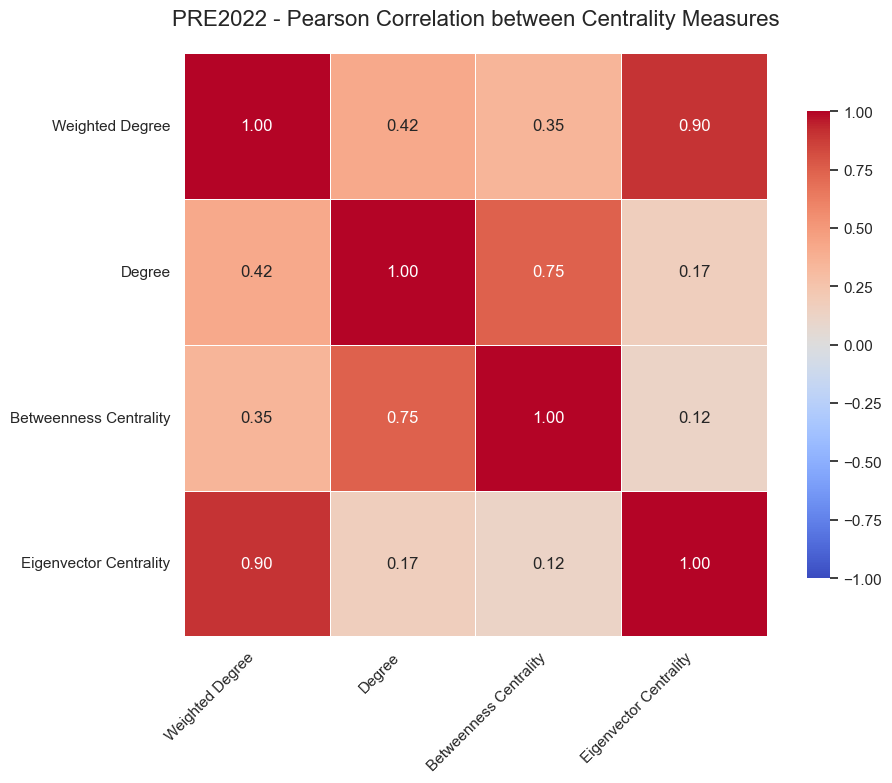

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURAÇÃO ---
file_name = 'p1_v3/p1_tabela_centralidades_completa.csv'
output_name = 'p1_correlation_matrix_english_full_square.png'

# Mapeamento: Chave = Nome exato no seu CSV (PT) -> Valor = Nome desejado no gráfico (EN)
# A ordem deste dicionário definirá a ordem das linhas/colunas no gráfico.
translation_map = {
    'Força (Weighted Degree)': 'Weighted Degree',
    'Grau (Degree)': 'Degree',
    'Intermediação (Betweenness)': 'Betweenness Centrality',
    'Influência (Eigenvector)': 'Eigenvector Centrality'
}
# --------------------

# 1. Carregar dados
try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"Erro: O arquivo '{file_name}' não foi encontrado.")
    exit()

# 2. Verificar e selecionar colunas
cols_pt = list(translation_map.keys())
missing = [c for c in cols_pt if c not in df.columns]
if missing:
    print(f"Erro: Colunas não encontradas no CSV: {missing}")
    exit()

# Seleciona as colunas em português e renomeia para inglês imediatamente
df_plot = df[cols_pt].rename(columns=translation_map)

# 3. Limpeza e conversão numérica
# Garante que o Python entenda os números, mesmo se vierem com vírgula decimal
for col in df_plot.columns:
    # Se for lido como texto (object), tenta substituir vírgula por ponto
    if pd.api.types.is_object_dtype(df_plot[col]):
        df_plot[col] = df_plot[col].str.replace(',', '.', regex=False)
    # Converte para numérico, forçando NaN em caso de erro
    df_plot[col] = pd.to_numeric(df_plot[col], errors='coerce')

# Remove linhas com NaNs para o cálculo correto da correlação
df_plot = df_plot.dropna()

if df_plot.empty:
     print("Erro: O DataFrame ficou vazio após a limpeza de dados numéricos.")
     exit()

# 4. Calcular Correlação de Pearson
corr_matrix = df_plot.corr(method='pearson')

# 5. Gerar o Heatmap (Layout Quadrado Completo em Inglês)
plt.figure(figsize=(10, 8))
sns.set_theme(style="white")

# O segredo para o layout quadrado é NÃO usar o argumento 'mask'
heatmap = sns.heatmap(corr_matrix,
            annot=True,       # Mostra os valores
            fmt=".2f",        # Formato 0.00
            cmap='coolwarm',  # Escala de cores
            vmin=-1, vmax=1,  # Limites da escala
            center=0,         # Zero é branco
            square=True,      # Força células quadradas
            linewidths=.5,    # Linhas divisórias
            cbar_kws={"shrink": .8}
           )

# Título em Inglês
plt.title('PRE2022 - Pearson Correlation between Centrality Measures', fontsize=16, pad=20)

# Ajuste dos rótulos dos eixos (agora já estão em inglês devido ao rename no passo 2)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11) # Rótulos horizontais no eixo Y

plt.tight_layout()

# 6. Salvar
plt.savefig(output_name, dpi=300, bbox_inches='tight')
print(f"Sucesso! Gráfico salvo como: {output_name}")

# plt.show() # Descomente se rodar localmente e quiser ver a janela

Sucesso! Gráfico salvo como: p2_correlation_matrix_english_full_square.png


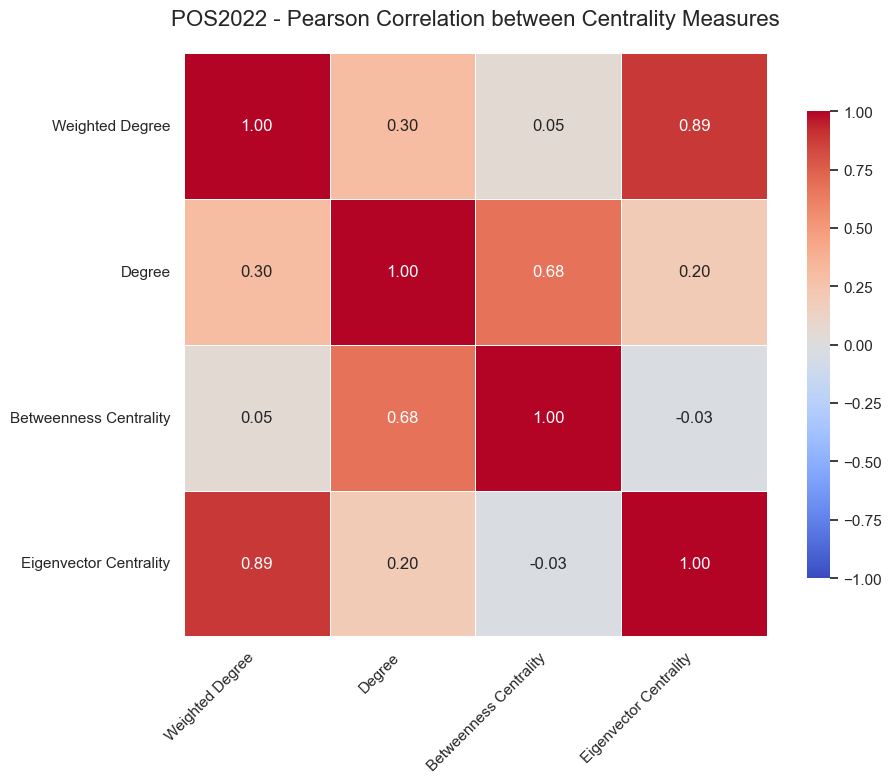

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURAÇÃO ---
file_name = 'P2/p2_tabela_centralidades_completa.csv'
output_name = 'p2_correlation_matrix_english_full_square.png'

# Mapeamento: Chave = Nome exato no seu CSV (PT) -> Valor = Nome desejado no gráfico (EN)
# A ordem deste dicionário definirá a ordem das linhas/colunas no gráfico.
translation_map = {
    'Força (Weighted Degree)': 'Weighted Degree',
    'Grau (Degree)': 'Degree',
    'Intermediação (Betweenness)': 'Betweenness Centrality',
    'Influência (Eigenvector)': 'Eigenvector Centrality'
}
# --------------------

# 1. Carregar dados
try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"Erro: O arquivo '{file_name}' não foi encontrado.")
    exit()

# 2. Verificar e selecionar colunas
cols_pt = list(translation_map.keys())
missing = [c for c in cols_pt if c not in df.columns]
if missing:
    print(f"Erro: Colunas não encontradas no CSV: {missing}")
    exit()

# Seleciona as colunas em português e renomeia para inglês imediatamente
df_plot = df[cols_pt].rename(columns=translation_map)

# 3. Limpeza e conversão numérica
# Garante que o Python entenda os números, mesmo se vierem com vírgula decimal
for col in df_plot.columns:
    # Se for lido como texto (object), tenta substituir vírgula por ponto
    if pd.api.types.is_object_dtype(df_plot[col]):
        df_plot[col] = df_plot[col].str.replace(',', '.', regex=False)
    # Converte para numérico, forçando NaN em caso de erro
    df_plot[col] = pd.to_numeric(df_plot[col], errors='coerce')

# Remove linhas com NaNs para o cálculo correto da correlação
df_plot = df_plot.dropna()

if df_plot.empty:
     print("Erro: O DataFrame ficou vazio após a limpeza de dados numéricos.")
     exit()

# 4. Calcular Correlação de Pearson
corr_matrix = df_plot.corr(method='pearson')

# 5. Gerar o Heatmap (Layout Quadrado Completo em Inglês)
plt.figure(figsize=(10, 8))
sns.set_theme(style="white")

# O segredo para o layout quadrado é NÃO usar o argumento 'mask'
heatmap = sns.heatmap(corr_matrix,
            annot=True,       # Mostra os valores
            fmt=".2f",        # Formato 0.00
            cmap='coolwarm',  # Escala de cores
            vmin=-1, vmax=1,  # Limites da escala
            center=0,         # Zero é branco
            square=True,      # Força células quadradas
            linewidths=.5,    # Linhas divisórias
            cbar_kws={"shrink": .8}
           )

# Título em Inglês
plt.title('POS2022 - Pearson Correlation between Centrality Measures', fontsize=16, pad=20)

# Ajuste dos rótulos dos eixos (agora já estão em inglês devido ao rename no passo 2)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11) # Rótulos horizontais no eixo Y

plt.tight_layout()

# 6. Salvar
plt.savefig(output_name, dpi=300, bbox_inches='tight')
print(f"Sucesso! Gráfico salvo como: {output_name}")

# plt.show() # Descomente se rodar localmente e quiser ver a janela

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- CONFIGURAÇÃO ---
# Se tiver um CSV real, carregue ele. Ex: 'target_data.csv'
# O CSV precisa ter colunas: id, p1 (role), p2 (role)
# Onde role é 'Core' ou 'Periphery'
ARQUIVO_DADOS = None # Coloque o nome do arquivo aqui, ex: 'meus_dados.csv'

# Se não tiver CSV agora, vou gerar dados falsos para você testar o visual
GERAR_DADOS_EXEMPLO = True 

def gerar_posicao_circular(n_pontos, raio_min, raio_max):
    """Gera coordenadas x,y aleatórias dentro de um anel (ou círculo)"""
    angulos = np.random.uniform(0, 2*np.pi, n_pontos)
    # A raiz quadrada garante distribuição uniforme na área
    raios = np.sqrt(np.random.uniform(raio_min**2, raio_max**2, n_pontos))
    
    x = raios * np.cos(angulos)
    y = raios * np.sin(angulos)
    return x, y

def plotar_alvo(df, periodo_col, titulo, output_file):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # --- 1. DESENHAR O ALVO (ESTRUTURA) ---
    # Raio do Core e da Periferia
    R_CORE = 1.0
    R_PERIF_MIN = 1.5
    R_PERIF_MAX = 3.0
    
    # Círculo Core (Tracejado Vermelho)
    core_circle = plt.Circle((0, 0), R_CORE, color='#d62728', fill=False, 
                             linestyle='--', linewidth=1.5, alpha=0.5)
    ax.add_artist(core_circle)
    ax.text(0, 0, 'CORE', ha='center', va='center', fontsize=12, 
            fontweight='bold', color='#d62728', alpha=0.3)
    
    # Círculo Periferia (Tracejado Azul)
    # Desenhamos dois círculos para formar o anel
    perif_inner = plt.Circle((0, 0), R_PERIF_MIN, color='#1f77b4', fill=False, 
                             linestyle=':', linewidth=1, alpha=0.3)
    perif_outer = plt.Circle((0, 0), R_PERIF_MAX, color='#1f77b4', fill=False, 
                             linestyle=':', linewidth=1, alpha=0.5)
    ax.add_artist(perif_inner)
    ax.add_artist(perif_outer)
    ax.text(0, -R_PERIF_MAX - 0.3, 'PERIPHERY', ha='center', va='center', 
            fontsize=10, color='#1f77b4', alpha=0.5)

    # --- 2. PLOTAR OS PONTOS ---
    # Separar quem é Core e quem é Periferia neste período
    core_users = df[df[periodo_col] == 'Core']
    perif_users = df[df[periodo_col] != 'Core'] # Assume Periphery ou outros
    
    # Gerar posições aleatórias para o Core
    if not core_users.empty:
        xc, yc = gerar_posicao_circular(len(core_users), 0, R_CORE * 0.9)
        ax.scatter(xc, yc, s=15, c='#d62728', alpha=0.7, edgecolors='none', label='Núcleo')

    # Gerar posições aleatórias para a Periferia
    if not perif_users.empty:
        xp, yp = gerar_posicao_circular(len(perif_users), R_PERIF_MIN, R_PERIF_MAX)
        ax.scatter(xp, yp, s=15, c='#1f77b4', alpha=0.5, edgecolors='none', label='Periferia')

    # --- 3. ESTILIZAÇÃO ---
    ax.set_aspect('equal')
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)
    ax.axis('off') # Remove eixos quadrados
    
    plt.title(titulo, fontsize=14, fontfamily='serif', pad=20)
    
    # Legenda
    # plt.legend(loc='upper right', frameon=True)
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Imagem salva: {output_file}")

# --- EXECUÇÃO ---

if ARQUIVO_DADOS:
    df = pd.read_csv(ARQUIVO_DADOS)
else:
    # Gera dados parecidos com o seu cenário real
    print("⚠️ Usando dados simulados (conecte seu CSV para dados reais)")
    # Cenário Pré: Muita periferia (azul), pouco core (vermelho)
    N = 500
    df = pd.DataFrame({
        'id': range(N),
        'p1': np.random.choice(['Core', 'Periphery'], N, p=[0.1, 0.9]), # 10% Core
        'p2': np.random.choice(['Core', 'Periphery'], N, p=[0.6, 0.4])  # 60% Core (Migração)
    })

# Gerar as duas imagens
plotar_alvo(df, 'p1', 'Topological Structure: PRE2022', 'alvo_pre_eleicao.png')
plotar_alvo(df, 'p2', 'Topological Structure: POS2022', 'alvo_pos_eleicao.png')

⚠️ Usando dados simulados (conecte seu CSV para dados reais)
✅ Imagem salva: alvo_pre_eleicao.png
✅ Imagem salva: alvo_pos_eleicao.png


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. SEUS DADOS AQUI ---
# Substitua os valores abaixo pelos números que seu script de contagem mostrou.
# Se não tiver o número exato, coloque uma estimativa próxima para testar o visual.

dados = {
    # GRUPO 1: Narrativa Pré-Eleição (Focada na Vitória/Disputa)
    'Vitória':     {'Pre': 1250, 'Pos': 320},
    'Pesquisas':   {'Pre': 980,  'Pos': 150},
    'Datafolha':   {'Pre': 850,  'Pos': 80},
    'Primeiro Turno': {'Pre': 700, 'Pos': 20},
    
    # GRUPO 2: Narrativa Pós-Eleição (Focada no Golpe/Revolta)
    'Fraude':      {'Pre': 120,  'Pos': 1450},
    'Intervenção': {'Pre': 50,   'Pos': 1100},
    'Urnas':       {'Pre': 300,  'Pos': 1300},
    'Ladrão':      {'Pre': 400,  'Pos': 1250},
    'Artigo 142':  {'Pre': 10,   'Pos': 890},
    'QG':          {'Pre': 30,   'Pos': 950}
}

# --- 2. PREPARAÇÃO DOS DADOS ---
df = pd.DataFrame(dados).T
df = df.reset_index().rename(columns={'index': 'Termo'})
# Ordena por maior variação para ficar bonito (os que mais subiram embaixo)
df['Diff'] = df['Pos'] - df['Pre']
df = df.sort_values('Diff', ascending=True)

# --- 3. CONFIGURAÇÃO DO GRÁFICO ---
plt.rcParams['font.family'] = 'serif' # Fonte Acadêmica
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

y = np.arange(len(df))
height = 0.35  # Largura da barra

# Barras
rects1 = ax.barh(y + height/2, df['Pre'], height, label='Pré-Eleição (P1)', color='#0077b6', alpha=0.9)
rects2 = ax.barh(y - height/2, df['Pos'], height, label='Pós-Eleição (P2)', color='#d62728', alpha=0.9)

# --- 4. ESTILIZAÇÃO ---
ax.set_yticks(y)
ax.set_yticklabels(df['Termo'], fontsize=12, fontweight='bold')
ax.set_xlabel('Frequência de Menções', fontsize=12)
ax.set_title('Mudança de Narrativa: Do Otimismo à Radicalização', fontsize=14, pad=20)
ax.legend(loc='lower right', fontsize=11)

# Adicionar linha divisória vertical suave
ax.grid(axis='x', linestyle='--', alpha=0.3)

# Adicionar Anotações de Texto (Setas de Tendência)
for i, row in df.iterrows():
    diff = row['Pos'] - row['Pre']
    diff_perc = (diff / row['Pre']) * 100 if row['Pre'] > 0 else 0
    
    # Posição do texto
    max_val = max(row['Pre'], row['Pos'])
    
    if diff > 0:
        texto = f"▲ +{int(diff)} (+{int(diff_perc)}%)"
        cor = '#d62728' # Vermelho (Subiu)
    else:
        texto = f"▼ {int(diff)} ({int(diff_perc)}%)"
        cor = '#0077b6' # Azul (Caiu)
        
    ax.text(max_val + 50, i, texto, va='center', fontsize=9, color=cor, fontweight='bold')

# Ajusta limites para caber o texto
ax.set_xlim(0, df[['Pre', 'Pos']].max().max() * 1.25)

# --- 5. SALVAR ---
plt.tight_layout()
plt.savefig('mudanca_narrativa_termos.png')
print("✅ Gráfico gerado: mudanca_narrativa_termos.png")

=== GERADOR DE GRÁFICO DE NARRATIVAS ===
🔄 Lendo arquivo: p1_v3/dataset_zap_1_preprocessado.csv ...
🔄 Lendo arquivo: P2/dataset_zap_2_preprocessado.csv ...
📊 Contando palavras-chave (isso pode levar alguns segundos)...
🎨 Gerando imagem...
✅ SUCESSO! Imagem salva: grafico_narrativa_artigo.png
   Total analisado: 272891 mensagens.


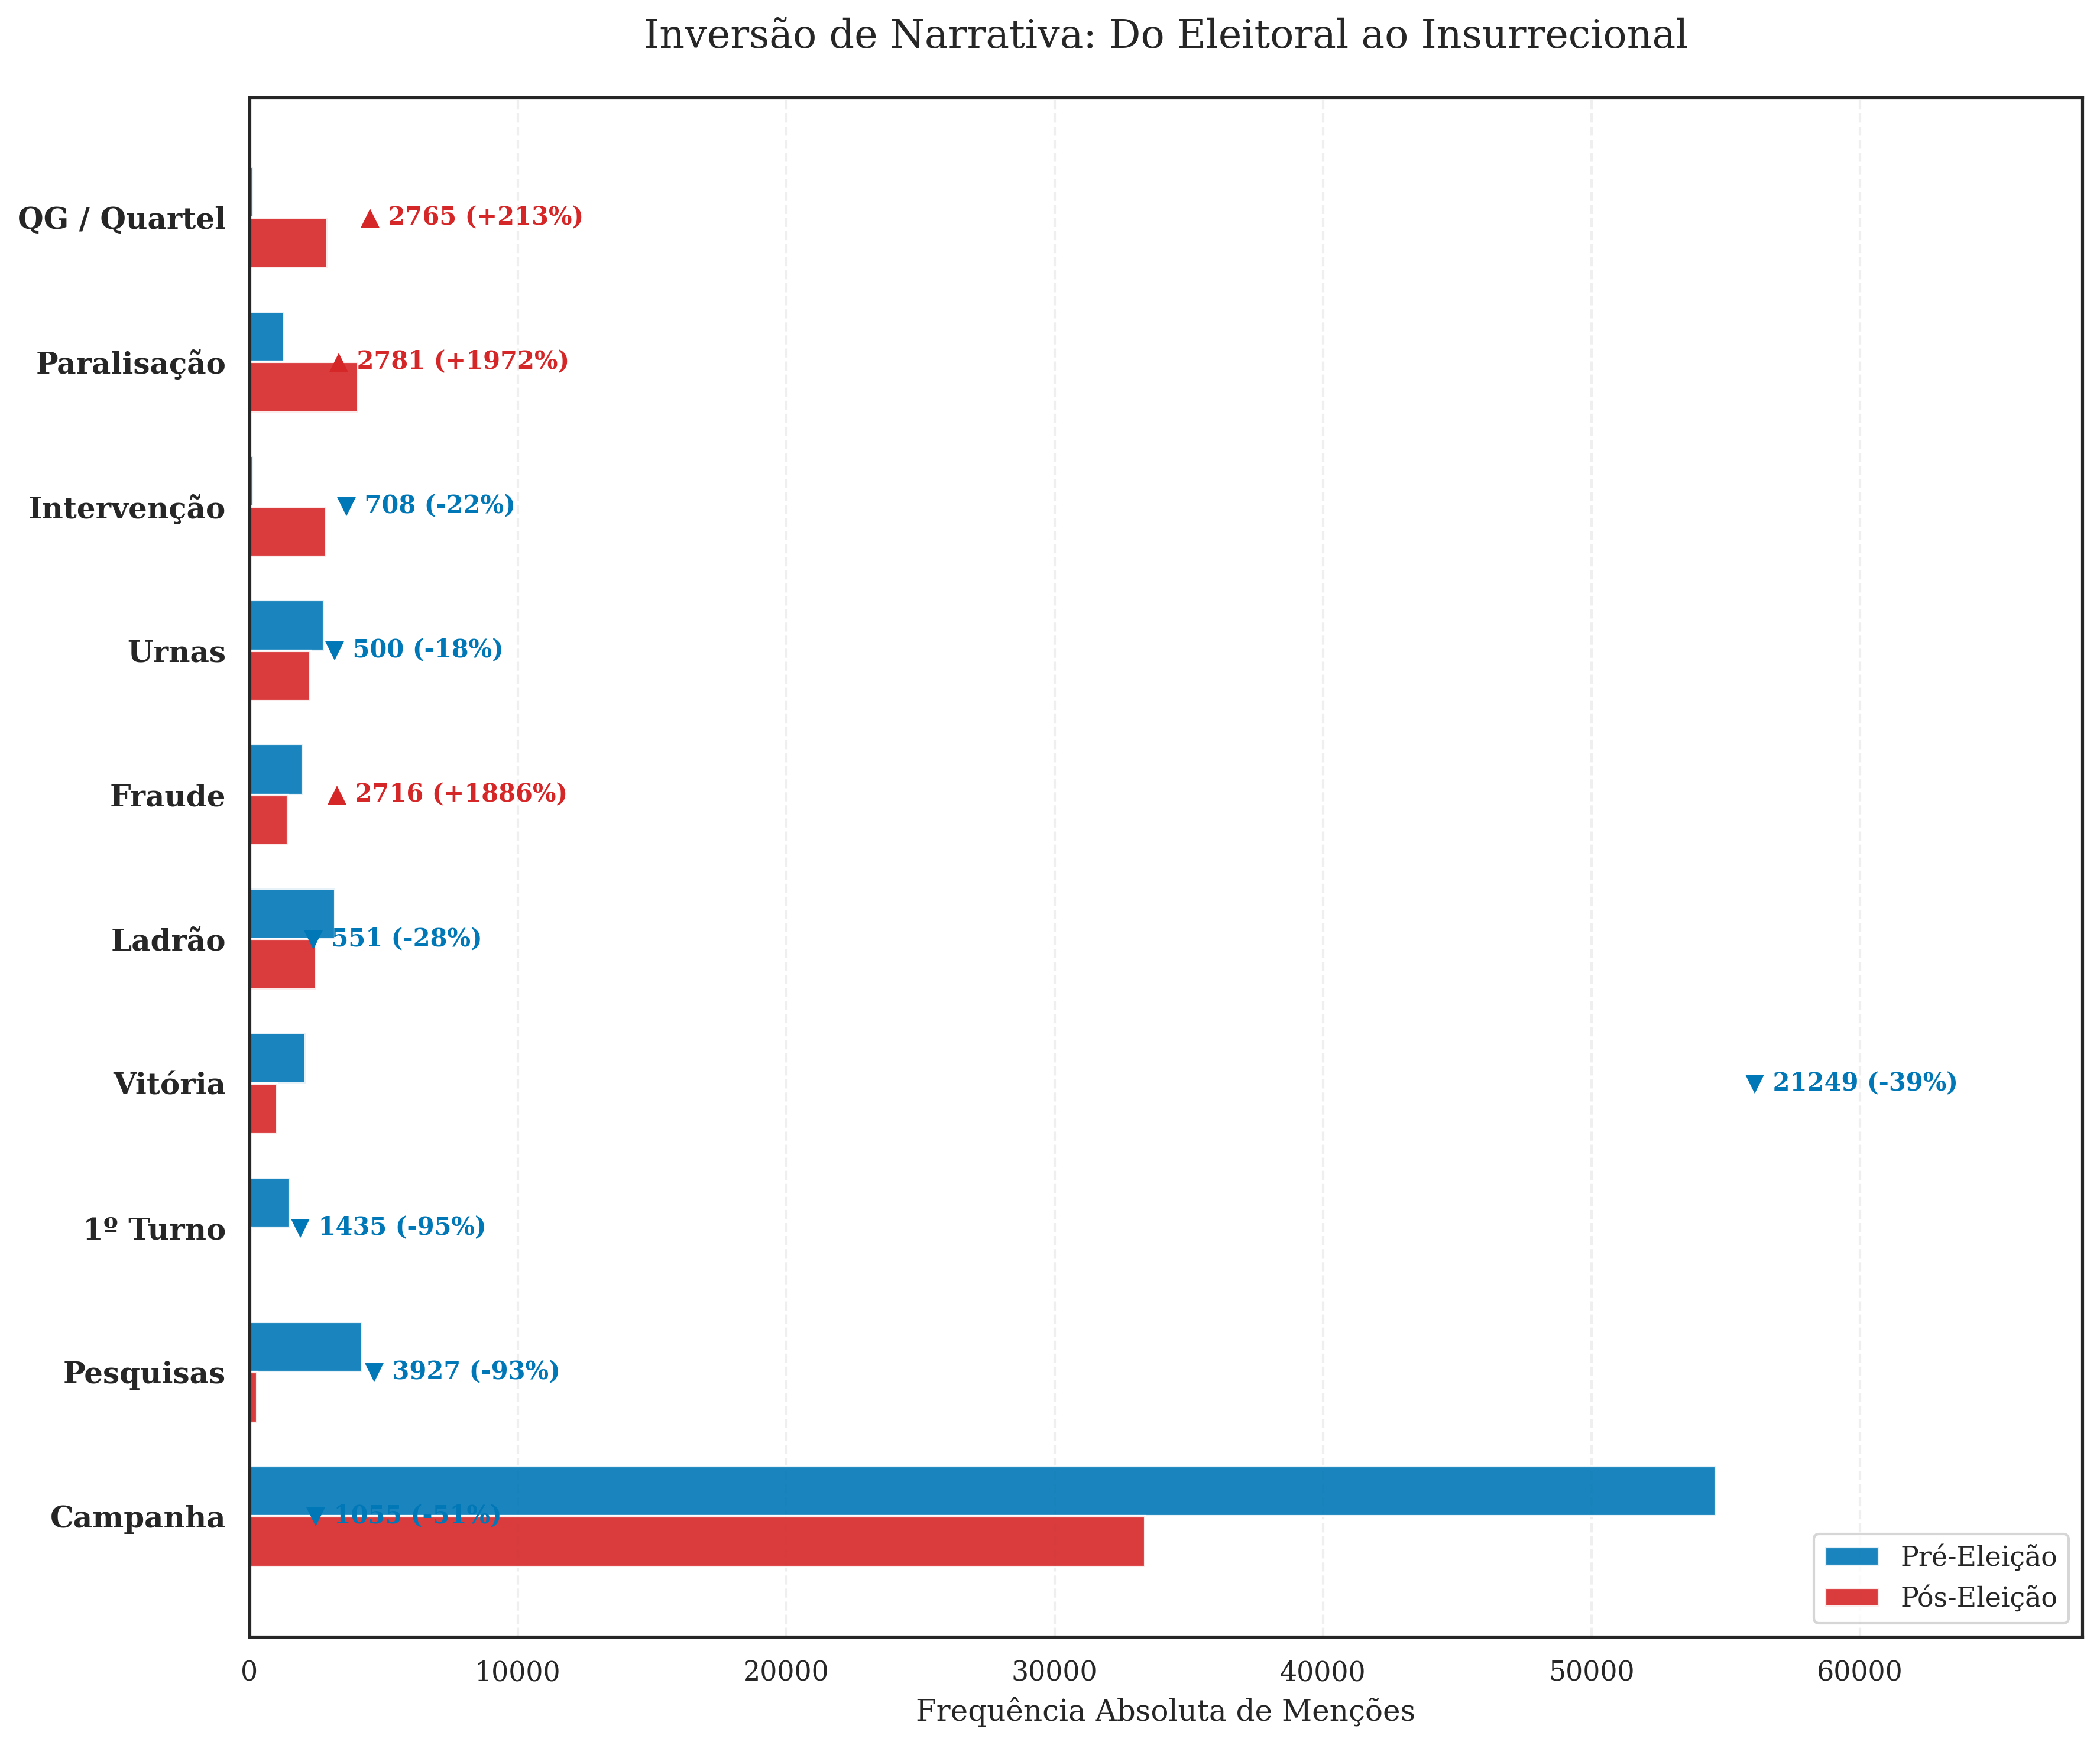

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os

# ================= CONFIGURAÇÃO =================
# Caminhos exatos conforme seu código anterior
ARQUIVO_PRE = 'p1_v3/dataset_zap_1_preprocessado.csv'
ARQUIVO_POS = 'P2/dataset_zap_2_preprocessado.csv'

# Coluna de texto
COLUNA_TEXTO = 'clean_text'

# Lista de Termos para o Artigo (Narrativa Pré vs Pós)
# Você pode adicionar ou remover palavras aqui
TERMOS_ALVO = {
    # GRUPO 1: Termos que devem cair (Foco Eleitoral)
    'Vitória':     ['vitoria', 'vencer', 'eleito'],
    'Pesquisas':   ['pesquisa', 'datafolha', 'ibope', 'ipred'],
    '1º Turno':    ['primeiro turno', '1 turno', '1º turno'],
    'Campanha':    ['campanha', 'candidato', 'lula', 'bolsonaro'],

    # GRUPO 2: Termos que devem subir (Foco Insurrecional)
    'Fraude':      ['fraude', 'roubado', 'inserções', 'radios'],
    'Intervenção': ['intervenção', 'intervencao', 'artigo 142', 'art 142'],
    'Urnas':       ['urna', 'urnas', 'codigo fonte', 'biometria'],
    'Ladrão':      ['ladrao', 'ladrão', 'presidiario', 'ex-presidiario'],
    'QG / Quartel':['quartel', 'qg', 'frente do qg', 'comandante'],
    'Paralisação': ['paralisacao', 'greve', 'bloqueio', 'estrada','brasilia', 'invadir', 'ruas' ]
}
# ================================================

def contar_termos(df, termos_dict):
    """Conta ocorrências de termos (incluindo sinônimos) no DataFrame"""
    contagem = {}
    total_msgs = len(df)
    
    # Converte tudo para string minúscula uma vez só para agilizar
    textos = df[COLUNA_TEXTO].astype(str).str.lower()
    
    for label, lista_sinonimos in termos_dict.items():
        total = 0
        for termo in lista_sinonimos:
            # Usa regex \b para buscar palavra inteira (evita falsos positivos)
            # Ex: 'urna' não pega 'jornal'
            # escape(termo) é segurança, \b é borda de palavra
            padrao = r'\b' + re.escape(termo) + r'\b'
            total += textos.str.count(padrao).sum()
        
        contagem[label] = total
        
    return contagem, total_msgs

def carregar_dados(caminho):
    print(f"🔄 Lendo arquivo: {caminho} ...")
    if not os.path.exists(caminho):
        print(f"❌ Erro: Arquivo não encontrado -> {caminho}")
        return None
    try:
        # Lê apenas a coluna necessária para economizar memória
        df = pd.read_csv(caminho, usecols=[COLUNA_TEXTO], dtype=str)
        df = df.dropna(subset=[COLUNA_TEXTO])
        return df
    except Exception as e:
        print(f"❌ Erro ao ler CSV: {e}")
        return None

# --- 1. PROCESSAMENTO ---
print("=== GERADOR DE GRÁFICO DE NARRATIVAS ===")

df_pre = carregar_dados(ARQUIVO_PRE)
df_pos = carregar_dados(ARQUIVO_POS)

if df_pre is None or df_pos is None:
    print("⚠️ Interrompendo: Verifique os arquivos.")
    exit()

print("📊 Contando palavras-chave (isso pode levar alguns segundos)...")
counts_pre, total_pre = contar_termos(df_pre, TERMOS_ALVO)
counts_pos, total_pos = contar_termos(df_pos, TERMOS_ALVO)

# Monta DataFrame para o gráfico
df_plot = pd.DataFrame({
    'Termo': counts_pre.keys(),
    'Pre': counts_pre.values(),
    'Pos': counts_pos.values()
})

# Calcula variação absoluta para ordenar
df_plot['Diff'] = df_plot['Pos'] - df_plot['Pre']
df_plot = df_plot.sort_values('Diff', ascending=True) # Ordena: Queda -> Aumento

# --- 2. VISUALIZAÇÃO (Estilo Artigo) ---
print("🎨 Gerando imagem...")

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(figsize=(12, 10), dpi=300)

y = np.arange(len(df_plot))
height = 0.35

# Barras Horizontais
rects1 = ax.barh(y + height/2, df_plot['Pre'], height, label='Pré-Eleição', color='#0077b6', alpha=0.9)
rects2 = ax.barh(y - height/2, df_plot['Pos'], height, label='Pós-Eleição', color='#d62728', alpha=0.9)

# Estética
ax.set_yticks(y)
ax.set_yticklabels(df_plot['Termo'], fontsize=12, fontweight='bold')
ax.set_xlabel('Frequência Absoluta de Menções', fontsize=12)
ax.set_title('Inversão de Narrativa: Do Eleitoral ao Insurrecional', fontsize=16, pad=20)
ax.legend(loc='lower right')
ax.grid(axis='x', linestyle='--', alpha=0.3)

# Adicionar valores e setas nas barras
for i, row in df_plot.iterrows():
    val_pre = row['Pre']
    val_pos = row['Pos']
    diff = val_pos - val_pre
    
    # Cálculo percentual seguro
    if val_pre > 0:
        perc = (diff / val_pre) * 100
    else:
        perc = 1000 if val_pos > 0 else 0 # Se era 0 e virou algo, é infinito
    
    # Texto da anotação
    simbolo = "▲" if diff > 0 else "▼"
    cor_texto = '#d62728' if diff > 0 else '#0077b6'
    
    texto_anotacao = f"{simbolo} {abs(diff)} ({perc:+.0f}%)"
    
    # Posiciona o texto um pouco depois da maior barra
    pos_x = max(val_pre, val_pos) * 1.02
    ax.text(pos_x, i, texto_anotacao, va='center', fontsize=10, color=cor_texto, fontweight='bold')

# Ajusta margem direita para caber os textos
ax.set_xlim(0, df_plot[['Pre', 'Pos']].max().max() * 1.25)

plt.tight_layout()
plt.savefig('grafico_narrativa_artigo.png')
print(f"✅ SUCESSO! Imagem salva: grafico_narrativa_artigo.png")
print(f"   Total analisado: {total_pre + total_pos} mensagens.")

In [24]:
import pandas as pd
import re
import os
import numpy as np

# ================= CONFIGURAÇÃO =================
ARQUIVO_PRE = 'p1_v3/dataset_zap_1_preprocessado.csv'
ARQUIVO_POS = 'P2/dataset_zap_2_preprocessado.csv'
COLUNA_TEXTO = 'clean_text'

# Definição dos Termos e suas variações (Sinônimos)
# Estrutura: 'Nome para o Artigo': ['termo1', 'termo2', 'termo3']
TERMOS_ALVO = {
    # GRUPO 1: Termos que devem cair (Foco Eleitoral)
    'Vitória':     ['vitoria', 'vencer', 'eleito'],
    'Pesquisas':   ['pesquisa', 'datafolha', 'ibope', 'ipred'],
    '1º Turno':    ['primeiro turno', '1 turno', '1º turno'],
    'Campanha':    ['campanha', 'candidato', 'lula', 'bolsonaro', 'jair', 'luladrao'],

    # GRUPO 2: Termos que devem subir (Foco Insurrecional)
    'Fraude':      ['fraude', 'roubado', 'inserções', 'radios'],
    'Intervenção': ['intervenção', 'intervencao', 'artigo 142', 'art 142'],
    'Urnas':       ['urna', 'urnas', 'codigo fonte', 'biometria'],
    'Ladrão':      ['ladrao', 'ladrão', 'presidiario', 'ex-presidiario'],
    'QG / Quartel':['quartel', 'qg', 'frente do qg', 'comandante'],
    'Paralisação': ['paralisacao', 'greve', 'bloqueio', 'estrada','brasilia', 'invadir', 'ruas' ]
}

def carregar_dados(caminho):
    print(f"🔄 Lendo: {caminho}...")
    if not os.path.exists(caminho):
        print(f"❌ Erro: Arquivo não encontrado -> {caminho}")
        return pd.Series(dtype=str)
    try:
        # Lê apenas a coluna de texto, converte para string e minúsculo
        df = pd.read_csv(caminho, usecols=[COLUNA_TEXTO], dtype=str)
        return df[COLUNA_TEXTO].dropna().str.lower()
    except Exception as e:
        print(f"❌ Erro leitura: {e}")
        return pd.Series(dtype=str)

def contar_termo_exato(series_texto, termo):
    """Conta quantas vezes um termo específico aparece"""
    if series_texto.empty:
        return 0
    # Regex \b para garantir que é a palavra inteira
    padrao = r'\b' + re.escape(termo) + r'\b'
    return series_texto.str.count(padrao).sum()

# ================= EXECUÇÃO =================
print("=== GERADOR DE CSV DETALHADO (PALAVRA POR PALAVRA) ===")

# 1. Carregar Dados
textos_pre = carregar_dados(ARQUIVO_PRE)
textos_pos = carregar_dados(ARQUIVO_POS)

# 2. Processar Contagem
dados_saida = []

print("📊 Processando varredura detalhada...")

for categoria, lista_palavras in TERMOS_ALVO.items():
    print(f"   > Analisando categoria: {categoria}...")
    
    for palavra in lista_palavras:
        # Conta a palavra específica
        qtd_pre = contar_termo_exato(textos_pre, palavra)
        qtd_pos = contar_termo_exato(textos_pos, palavra)
        
        # Só adiciona se a palavra apareceu pelo menos uma vez no total
        if qtd_pre + qtd_pos == 0:
            continue
            
        # Cálculos
        diff = qtd_pos - qtd_pre
        
        if qtd_pre > 0:
            var_pct = ((qtd_pos - qtd_pre) / qtd_pre) * 100
        else:
            var_pct = 1000 if qtd_pos > 0 else 0 # Marca crescimento infinito
            
        # Formatação para o LaTeX (Cores automáticas)
        # Se subiu muito (>50%), fica vermelho. Se caiu, azul.
        cor = "red" if diff > 0 else "blue"
        latex_str = f"\\textcolor{{{cor}}}{{{var_pct:+.0f}\\%}}"
        
        dados_saida.append({
            'Categoria_Macro': categoria,
            'Termo_Especifico': palavra,
            'Freq_Pre': int(qtd_pre),
            'Freq_Pos': int(qtd_pos),
            'Diferenca_Absoluta': int(diff),
            'Variacao_Percentual': round(var_pct, 1),
            'LaTeX_Variação': latex_str
        })

# 3. Criar DataFrame e Salvar
df_final = pd.DataFrame(dados_saida)

# Ordenar por Categoria e depois pela Diferença (para ver quem mudou mais)
df_final = df_final.sort_values(by=['Categoria_Macro', 'Diferenca_Absoluta'], ascending=[True, False])

nome_arquivo = 'dados_palavras_detalhado.csv'
df_final.to_csv(nome_arquivo, index=False, encoding='utf-8')

print("\n" + "="*50)
print(f"✅ ARQUIVO GERADO: {nome_arquivo}")
print("="*50)
print(df_final[['Termo_Especifico', 'Freq_Pre', 'Freq_Pos', 'LaTeX_Variação']].head(10))
print("...")

=== GERADOR DE CSV DETALHADO (PALAVRA POR PALAVRA) ===
🔄 Lendo: p1_v3/dataset_zap_1_preprocessado.csv...
🔄 Lendo: P2/dataset_zap_2_preprocessado.csv...
📊 Processando varredura detalhada...
   > Analisando categoria: Vitória...
   > Analisando categoria: Pesquisas...
   > Analisando categoria: 1º Turno...
   > Analisando categoria: Campanha...
   > Analisando categoria: Fraude...
   > Analisando categoria: Intervenção...
   > Analisando categoria: Urnas...
   > Analisando categoria: Ladrão...
   > Analisando categoria: QG / Quartel...
   > Analisando categoria: Paralisação...

✅ ARQUIVO GERADO: dados_palavras_detalhado.csv
   Termo_Especifico  Freq_Pre  Freq_Pos           LaTeX_Variação
7          1º turno       413        13  \textcolor{blue}{-97\%}
6    primeiro turno      1096        61  \textcolor{blue}{-94\%}
13         luladrao       270       154  \textcolor{blue}{-43\%}
12             jair      1988       984  \textcolor{blue}{-51\%}
9         candidato      2166       379  \tex

⚠️ Dados não encontrados, gerando exemplo...
🔄 Organizando bolhas...
🎨 Gerando imagem...
✅ SUCESSO! Salvo: bubble_chart_final.png


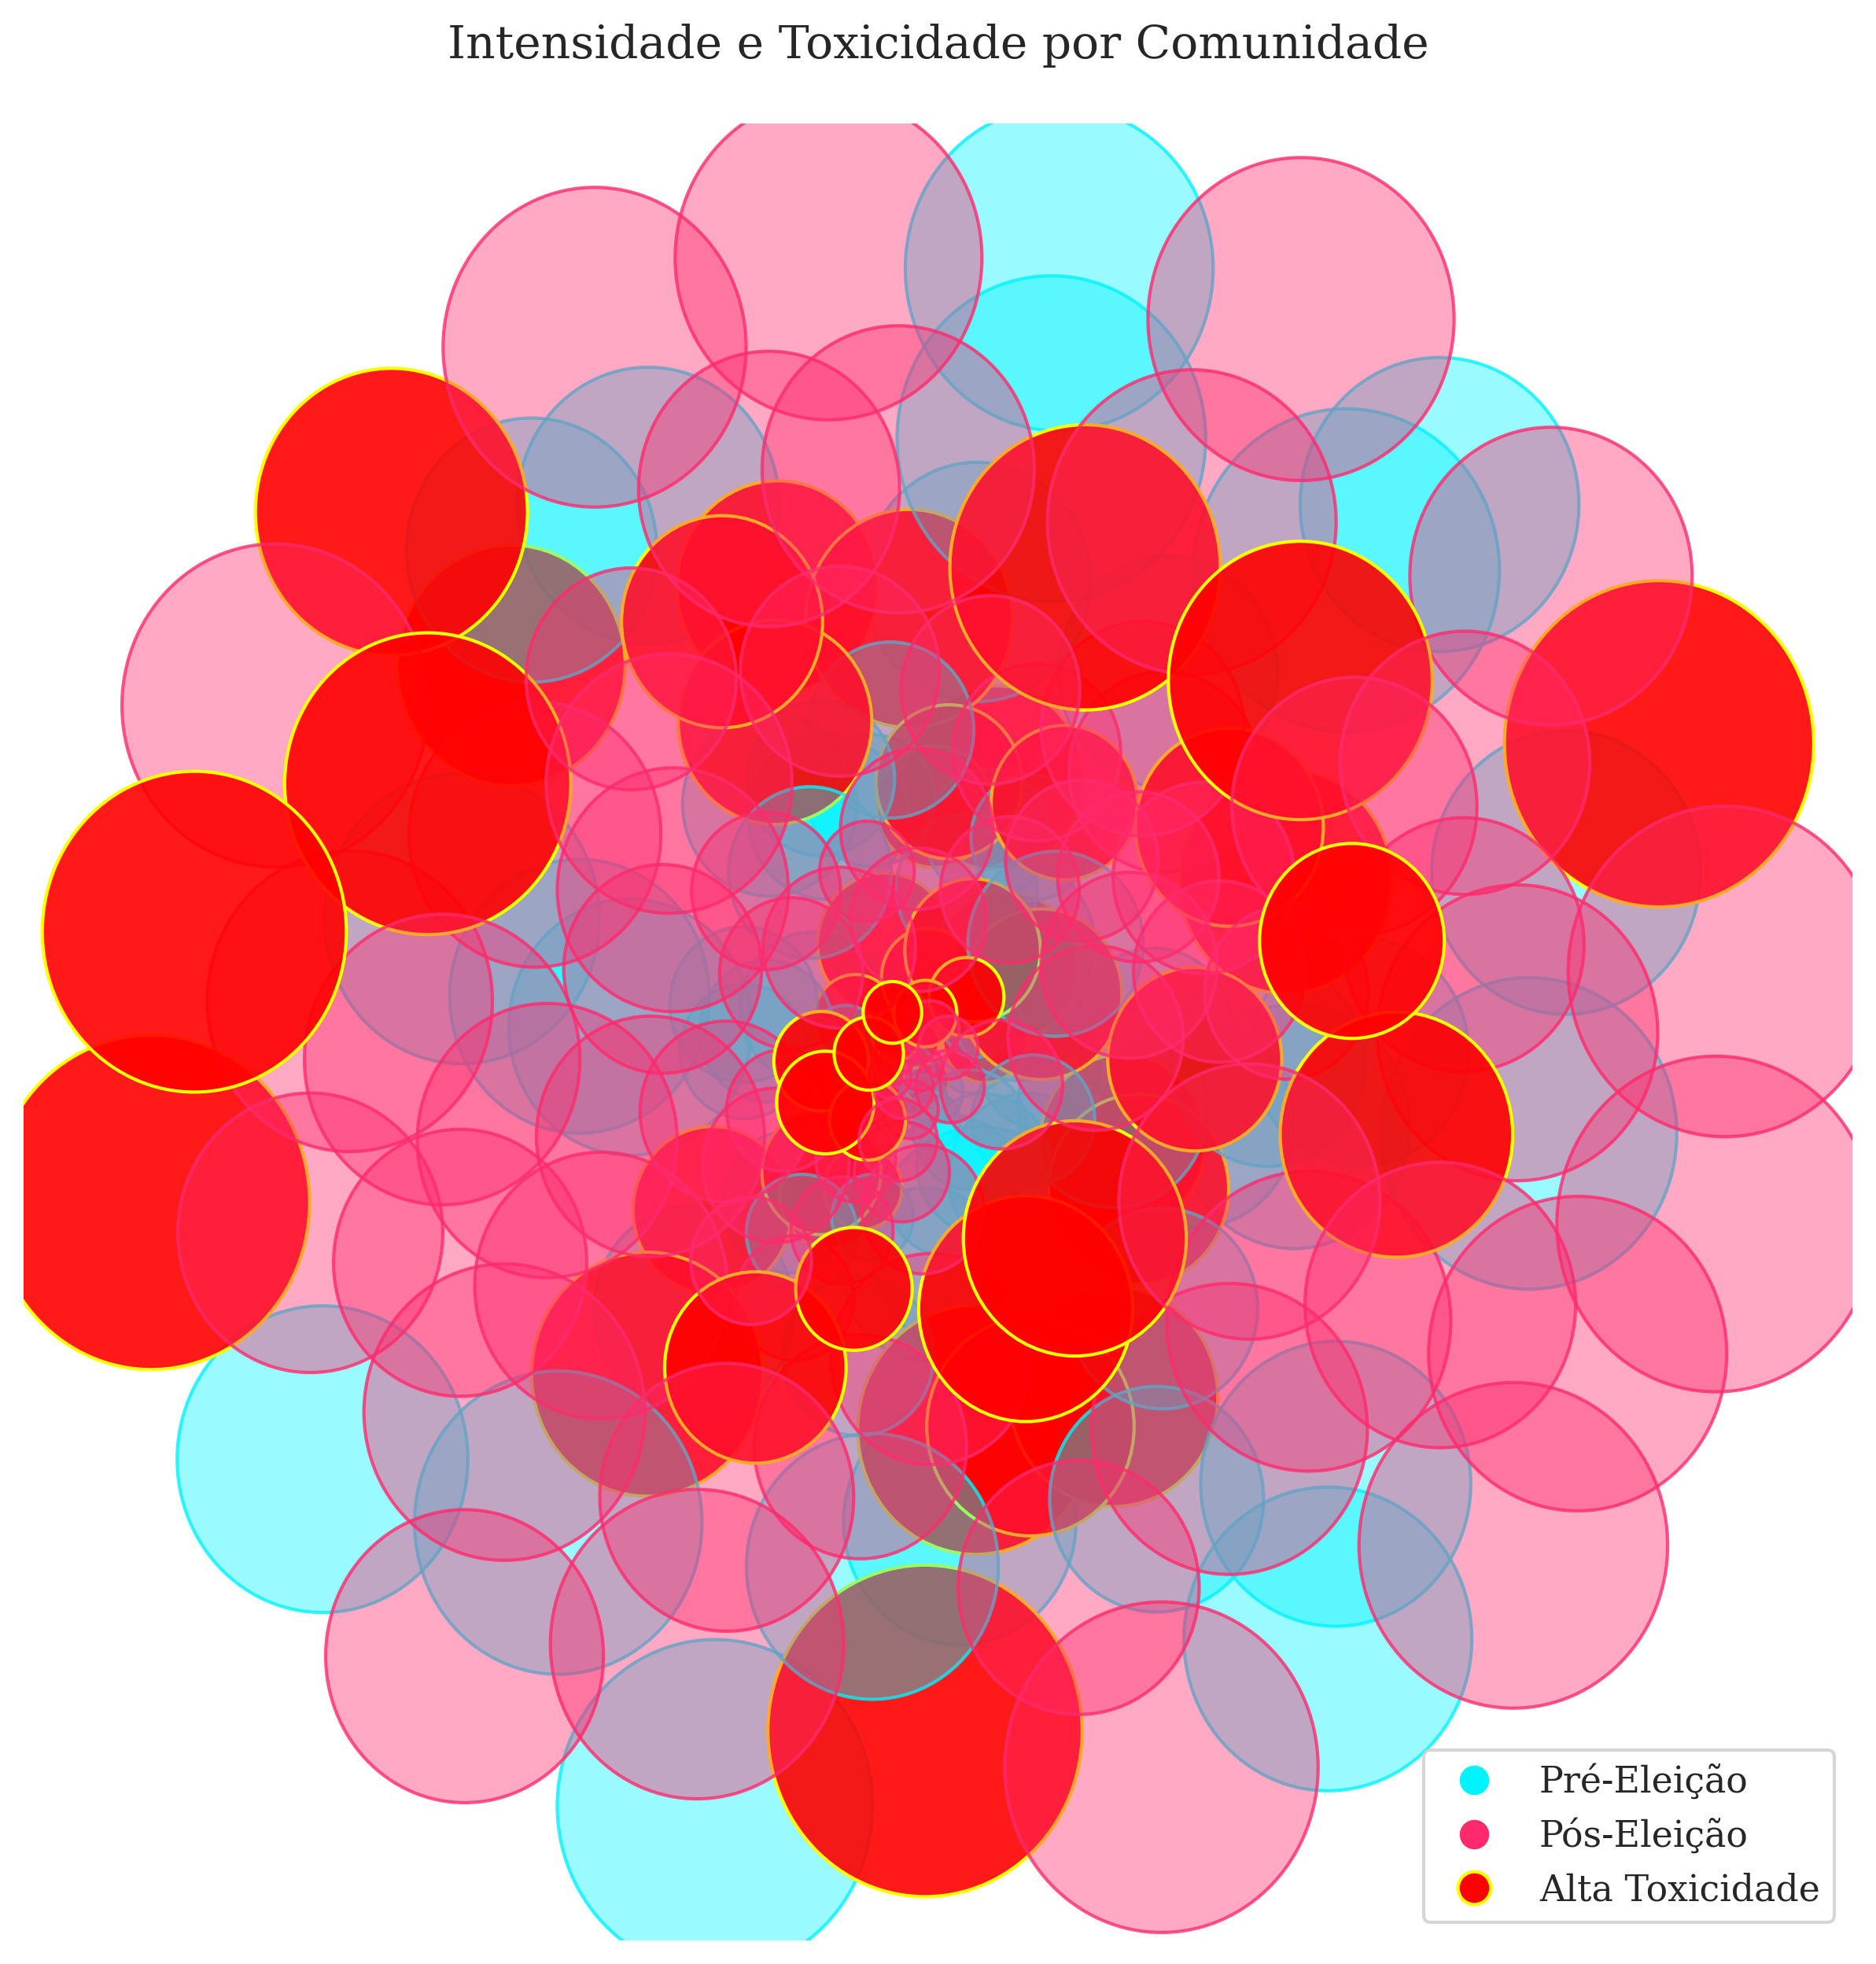

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle  # <--- A LINHA QUE FALTAVA
from matplotlib.colors import to_rgba

# ================= CONFIGURAÇÃO =================
# Arquivos de entrada (Métricas das Comunidades)
ARQUIVO_PRE = 'p1_v3/p1_pre_relatorio_desinformacao_comunidades.csv'
ARQUIVO_POS = 'P2/p2_pos_relatorio_desinformacao_comunidades.csv'

# Cores (Estilo do Site)
COR_PRE = "#00f3ff"      # Ciano Neon
COR_POS = "#ff2a6d"      # Rosa Neon
COR_ALERTA = "#ff0000"   # Vermelho
COR_STROKE_ALERTA = "#ffff00" # Amarelo

# Fundo (BRANCO para Artigo)
COR_FUNDO = 'white' 
COR_TEXTO = 'black'

# ================= 1. CARREGAR DADOS =================
def carregar_dados():
    try:
        df_pre = pd.read_csv(ARQUIVO_PRE)
        df_pos = pd.read_csv(ARQUIVO_POS)
        
        df_pre.columns = [c.lower() for c in df_pre.columns]
        df_pos.columns = [c.lower() for c in df_pos.columns]
        
        df_pre['period'] = 'p1'
        df_pos['period'] = 'p2'
        
        df = pd.concat([df_pre, df_pos])
        df = df[df['count'] > 5].copy()
        
        # Raio visual
        df['radius'] = np.sqrt(df['count'])
        df['radius'] = np.interp(df['radius'], (df['radius'].min(), df['radius'].max()), (2, 35))
        
        return df
    except:
        print("⚠️ Dados não encontrados, gerando exemplo...")
        N = 200
        return pd.DataFrame({
            'period': ['p1']*(N//2) + ['p2']*(N//2),
            'mean': np.random.uniform(0, 1, N),
            'radius': np.random.uniform(3, 25, N),
            'community_id': range(N)
        })

# ================= 2. FÍSICA (PACKING) =================
def pack_circles(df, iterations=200):
    print("🔄 Organizando bolhas...")
    n = len(df)
    radii = df['radius'].values
    
    x = np.random.normal(0, 10, n)
    y = np.random.normal(0, 10, n)
    
    for i in range(iterations):
        x *= 0.95 # Atração ao centro
        y *= 0.95
        
        # Repulsão simplificada
        for j in range(n):
            dx = x - x[j]
            dy = y - y[j]
            dist_sq = dx**2 + dy**2
            min_dist = radii + radii[j] + 0.5
            
            mask = (dist_sq < min_dist**2) & (dist_sq > 0.1)
            if np.any(mask):
                dists = np.sqrt(dist_sq[mask])
                forces = (min_dist[mask] - dists) / dists
                x[mask] += dx[mask] * forces * 0.15
                y[mask] += dy[mask] * forces * 0.15

    df['cx'] = x
    df['cy'] = y
    return df

# ================= 3. DESENHAR =================
df = carregar_dados()
df = pack_circles(df)

print("🎨 Gerando imagem...")
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.set_facecolor(COR_FUNDO)

patches = []
facecolors = []
edgecolors = []

for _, row in df.iterrows():
    # Cria o objeto Circle
    circle = Circle((row['cx'], row['cy']), row['radius'])
    patches.append(circle)
    
    score = row.get('mean', 0)
    period = row.get('period', 'p1')
    
    if score >= 0.7:
        facecolors.append(to_rgba(COR_ALERTA, 0.9))
        edgecolors.append(to_rgba(COR_STROKE_ALERTA, 1.0))
    else:
        c = COR_PRE if period == 'p1' else COR_POS
        facecolors.append(to_rgba(c, 0.4))
        edgecolors.append(to_rgba(c, 0.8))

# Cria coleção otimizada
collection = PatchCollection(patches, match_original=False)
collection.set_facecolor(facecolors)
collection.set_edgecolor(edgecolors)
collection.set_linewidth(1)

ax.add_collection(collection)

ax.set_xlim(df['cx'].min()-20, df['cx'].max()+20)
ax.set_ylim(df['cy'].min()-20, df['cy'].max()+20)
ax.axis('off')

# Legenda Manual
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COR_PRE, label='Pré-Eleição', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COR_POS, label='Pós-Eleição', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COR_ALERTA, markeredgecolor=COR_STROKE_ALERTA, label='Alta Toxicidade', markersize=10)
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True)

plt.title("Intensidade e Toxicidade por Comunidade", fontsize=14, fontfamily='serif', pad=20)
plt.savefig('bubble_chart_final.png', bbox_inches='tight', dpi=300)
print("✅ SUCESSO! Salvo: bubble_chart_final.png")

⚠️ Dados não encontrados, gerando exemplo...
🔄 Organizando layout sem sobreposição...
🎨 Renderizando com números das comunidades...
✅ SUCESSO! Salvo: bubble_chart_numbers.png


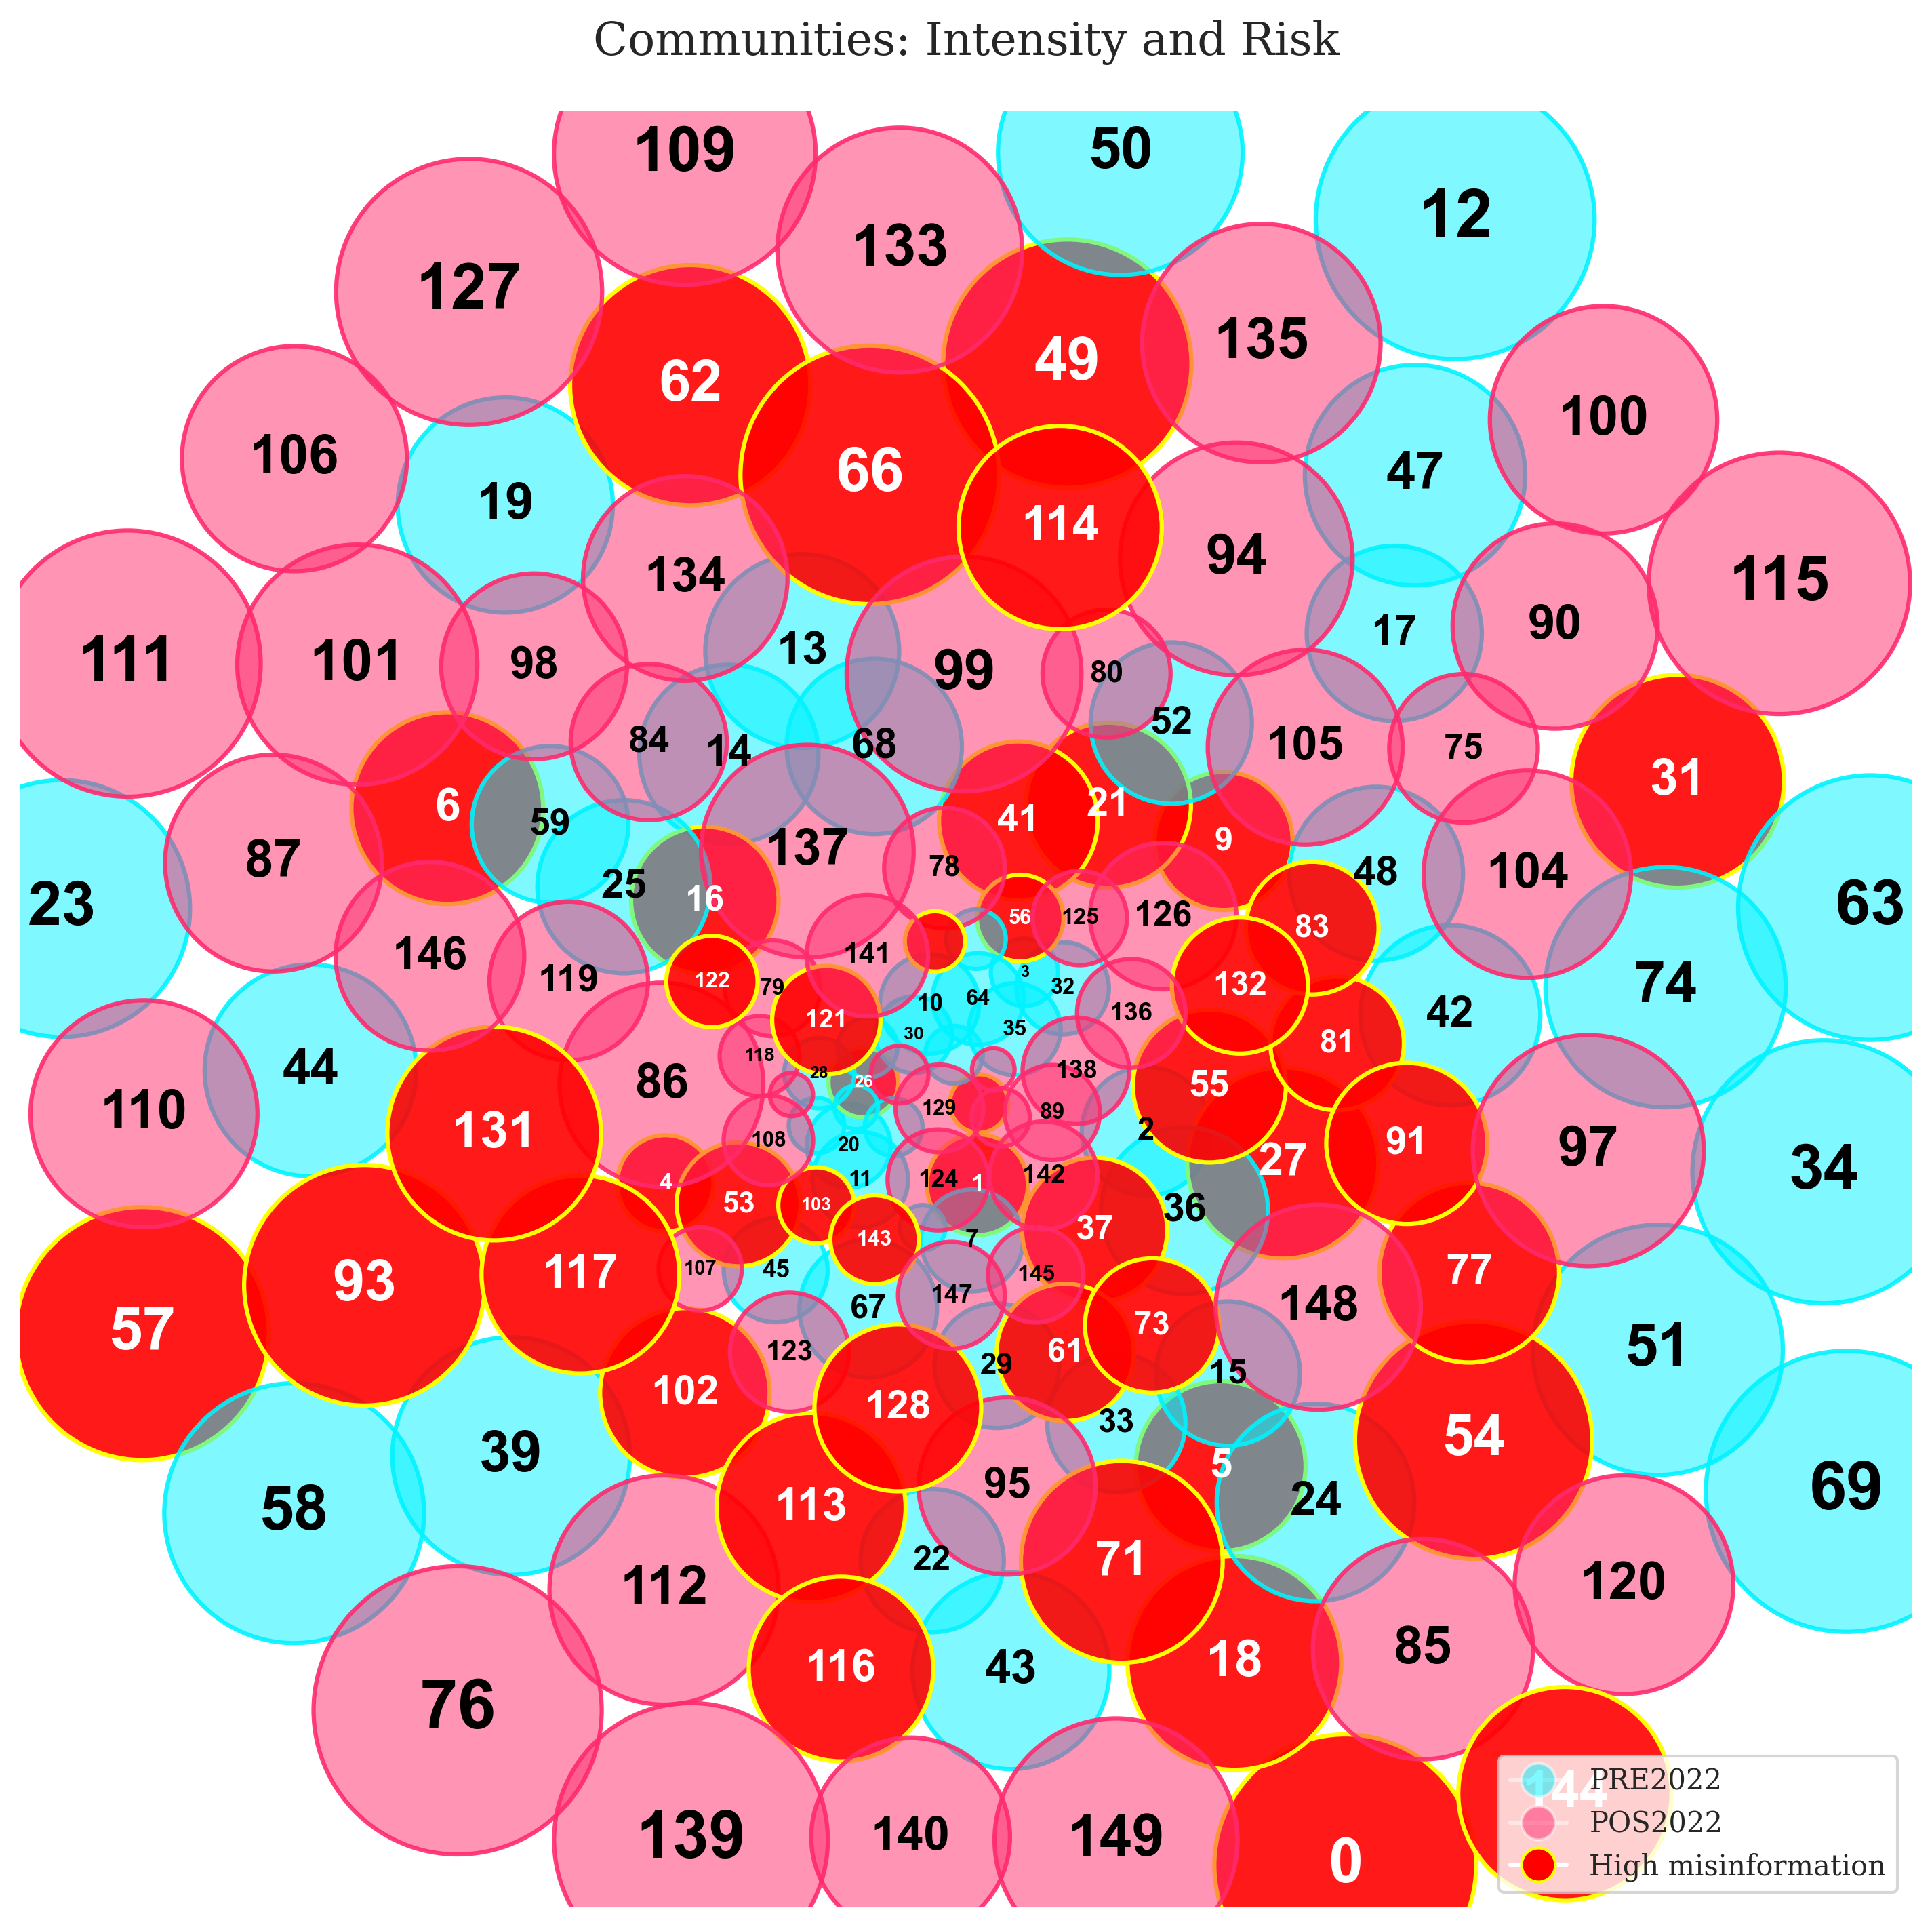

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
from matplotlib.colors import to_rgba

ARQUIVO_PRE = 'p1_v3/p1_pre_relatorio_desinformacao_comunidades.csv'
ARQUIVO_POS = 'P2/p2_pos_relatorio_desinformacao_comunidades.csv'

# Cores
COR_PRE = "#00f3ff"      # Ciano Neon
COR_POS = "#ff2a6d"      # Rosa Neon
COR_ALERTA = "#ff0000"   # Vermelho
COR_STROKE_ALERTA = "#ffff00" # Amarelo

COR_FUNDO = 'white' 

# ================= 1. CARREGAR DADOS =================
def carregar_dados():
    try:
        df_pre = pd.read_csv(ARQUIVO_PRE)
        df_pos = pd.read_csv(ARQUIVO_POS)
        
        df_pre.columns = [c.lower() for c in df_pre.columns]
        df_pos.columns = [c.lower() for c in df_pos.columns]
        
        df_pre['period'] = 'p1'
        df_pos['period'] = 'p2'
        
        df = pd.concat([df_pre, df_pos])
        df = df[df['count'] > 5].copy()
        
        # Ajuste de Raio
        df['radius'] = np.sqrt(df['count'])
        df['radius'] = np.interp(df['radius'], (df['radius'].min(), df['radius'].max()), (3, 40))
        
        return df
    except:
        print("⚠️ Dados não encontrados, gerando exemplo...")
        N = 150
        return pd.DataFrame({
            'period': ['p1']*(N//2) + ['p2']*(N//2),
            'mean': np.random.uniform(0, 1, N),
            'radius': np.random.uniform(5, 35, N),
            'community_id': np.arange(N)
        })

# ================= 2. FÍSICA (PACKING PERFEITO) =================
def pack_circles(df, iterations=300):
    print("🔄 Organizando layout sem sobreposição...")
    n = len(df)
    radii = df['radius'].values
    
    # Inicia no centro
    x = np.random.normal(0, 5, n)
    y = np.random.normal(0, 5, n)
    
    # Loop de Simulação
    for i in range(iterations):
        # Gravidade mais fraca para permitir espalhamento
        x *= 0.99 
        y *= 0.99
        
        # Detecção de Colisão e Repulsão
        for j in range(n):
            dx = x - x[j]
            dy = y - y[j]
            dist_sq = dx**2 + dy**2
            
            # Distância mínima = soma dos raios + margem (padding)
            min_dist = radii + radii[j] + 1.5 
            
            mask = (dist_sq < min_dist**2) & (dist_sq > 0.01)
            
            if np.any(mask):
                dists = np.sqrt(dist_sq[mask])
                # Força proporcional à sobreposição
                forces = (min_dist[mask] - dists) / dists
                
                # Empurra suavemente
                amount = 0.2
                x[mask] += dx[mask] * forces * amount
                y[mask] += dy[mask] * forces * amount
                
                # Ação e Reação (opcional, mas ajuda a estabilizar)
                # x[j] -= np.sum(dx[mask] * forces * amount)
                # y[j] -= np.sum(dy[mask] * forces * amount)

    df['cx'] = x
    df['cy'] = y
    return df

# ================= 3. DESENHAR COM RÓTULOS =================
df = carregar_dados()
df = pack_circles(df)

print("🎨 Renderizando com números das comunidades...")
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
ax.set_facecolor(COR_FUNDO)

patches = []
facecolors = []
edgecolors = []

# Desenha Círculos e Textos
for _, row in df.iterrows():
    # 1. Círculo
    circle = Circle((row['cx'], row['cy']), row['radius'])
    patches.append(circle)
    
    score = row.get('mean', 0)
    period = row.get('period', 'p1')
    comm_id = int(row.get('community_id', 0))
    radius = row['radius']
    
    # Cores
    if score >= 0.7:
        fc = to_rgba(COR_ALERTA, 0.9)
        ec = to_rgba(COR_STROKE_ALERTA, 1.0)
        text_color = 'white'
    else:
        c = COR_PRE if period == 'p1' else COR_POS
        fc = to_rgba(c, 0.5)
        ec = to_rgba(c, 0.9)
        text_color = 'black' # Contraste melhor com cores claras

    facecolors.append(fc)
    edgecolors.append(ec)
    
    # 2. Texto (ID da Comunidade)
    # Só desenha se a bolha for grande o suficiente (> 8px) para caber o número
    if radius > 8:
        ax.text(row['cx'], row['cy'], str(comm_id), 
                color=text_color,
                ha='center', va='center',
                fontsize=radius * 0.7, # Tamanho proporcional ao raio
                fontweight='bold',
                fontfamily='sans-serif')

# Adiciona Coleção de Círculos ao fundo
collection = PatchCollection(patches, match_original=False)
collection.set_facecolor(facecolors)
collection.set_edgecolor(edgecolors)
collection.set_linewidth(1.5)
ax.add_collection(collection)

# Limites e Ajustes
margin = 10
ax.set_xlim(df['cx'].min()-margin, df['cx'].max()+margin)
ax.set_ylim(df['cy'].min()-margin, df['cy'].max()+margin)
ax.axis('off')
ax.set_aspect('equal')

# Título
plt.title("Communities: Intensity and Risk", fontsize=16, fontfamily='serif', pad=20)

# Legenda
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COR_PRE, label='PRE2022', markersize=12, alpha=0.5),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COR_POS, label='POS2022', markersize=12, alpha=0.5),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COR_ALERTA, markeredgecolor=COR_STROKE_ALERTA, label='High misinformation', markersize=12)
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=10)

plt.savefig('bubble_chart_numbers.png', bbox_inches='tight', dpi=300)
print("✅ SUCESSO! Salvo: bubble_chart_numbers.png")

⚠️ Dados não encontrados, gerando exemplo...
🔄 Organizando sem sobreposição...
🎨 Renderizando com cores corrigidas...
✅ SUCESSO! Salvo: bubble_chart_corrigido.png


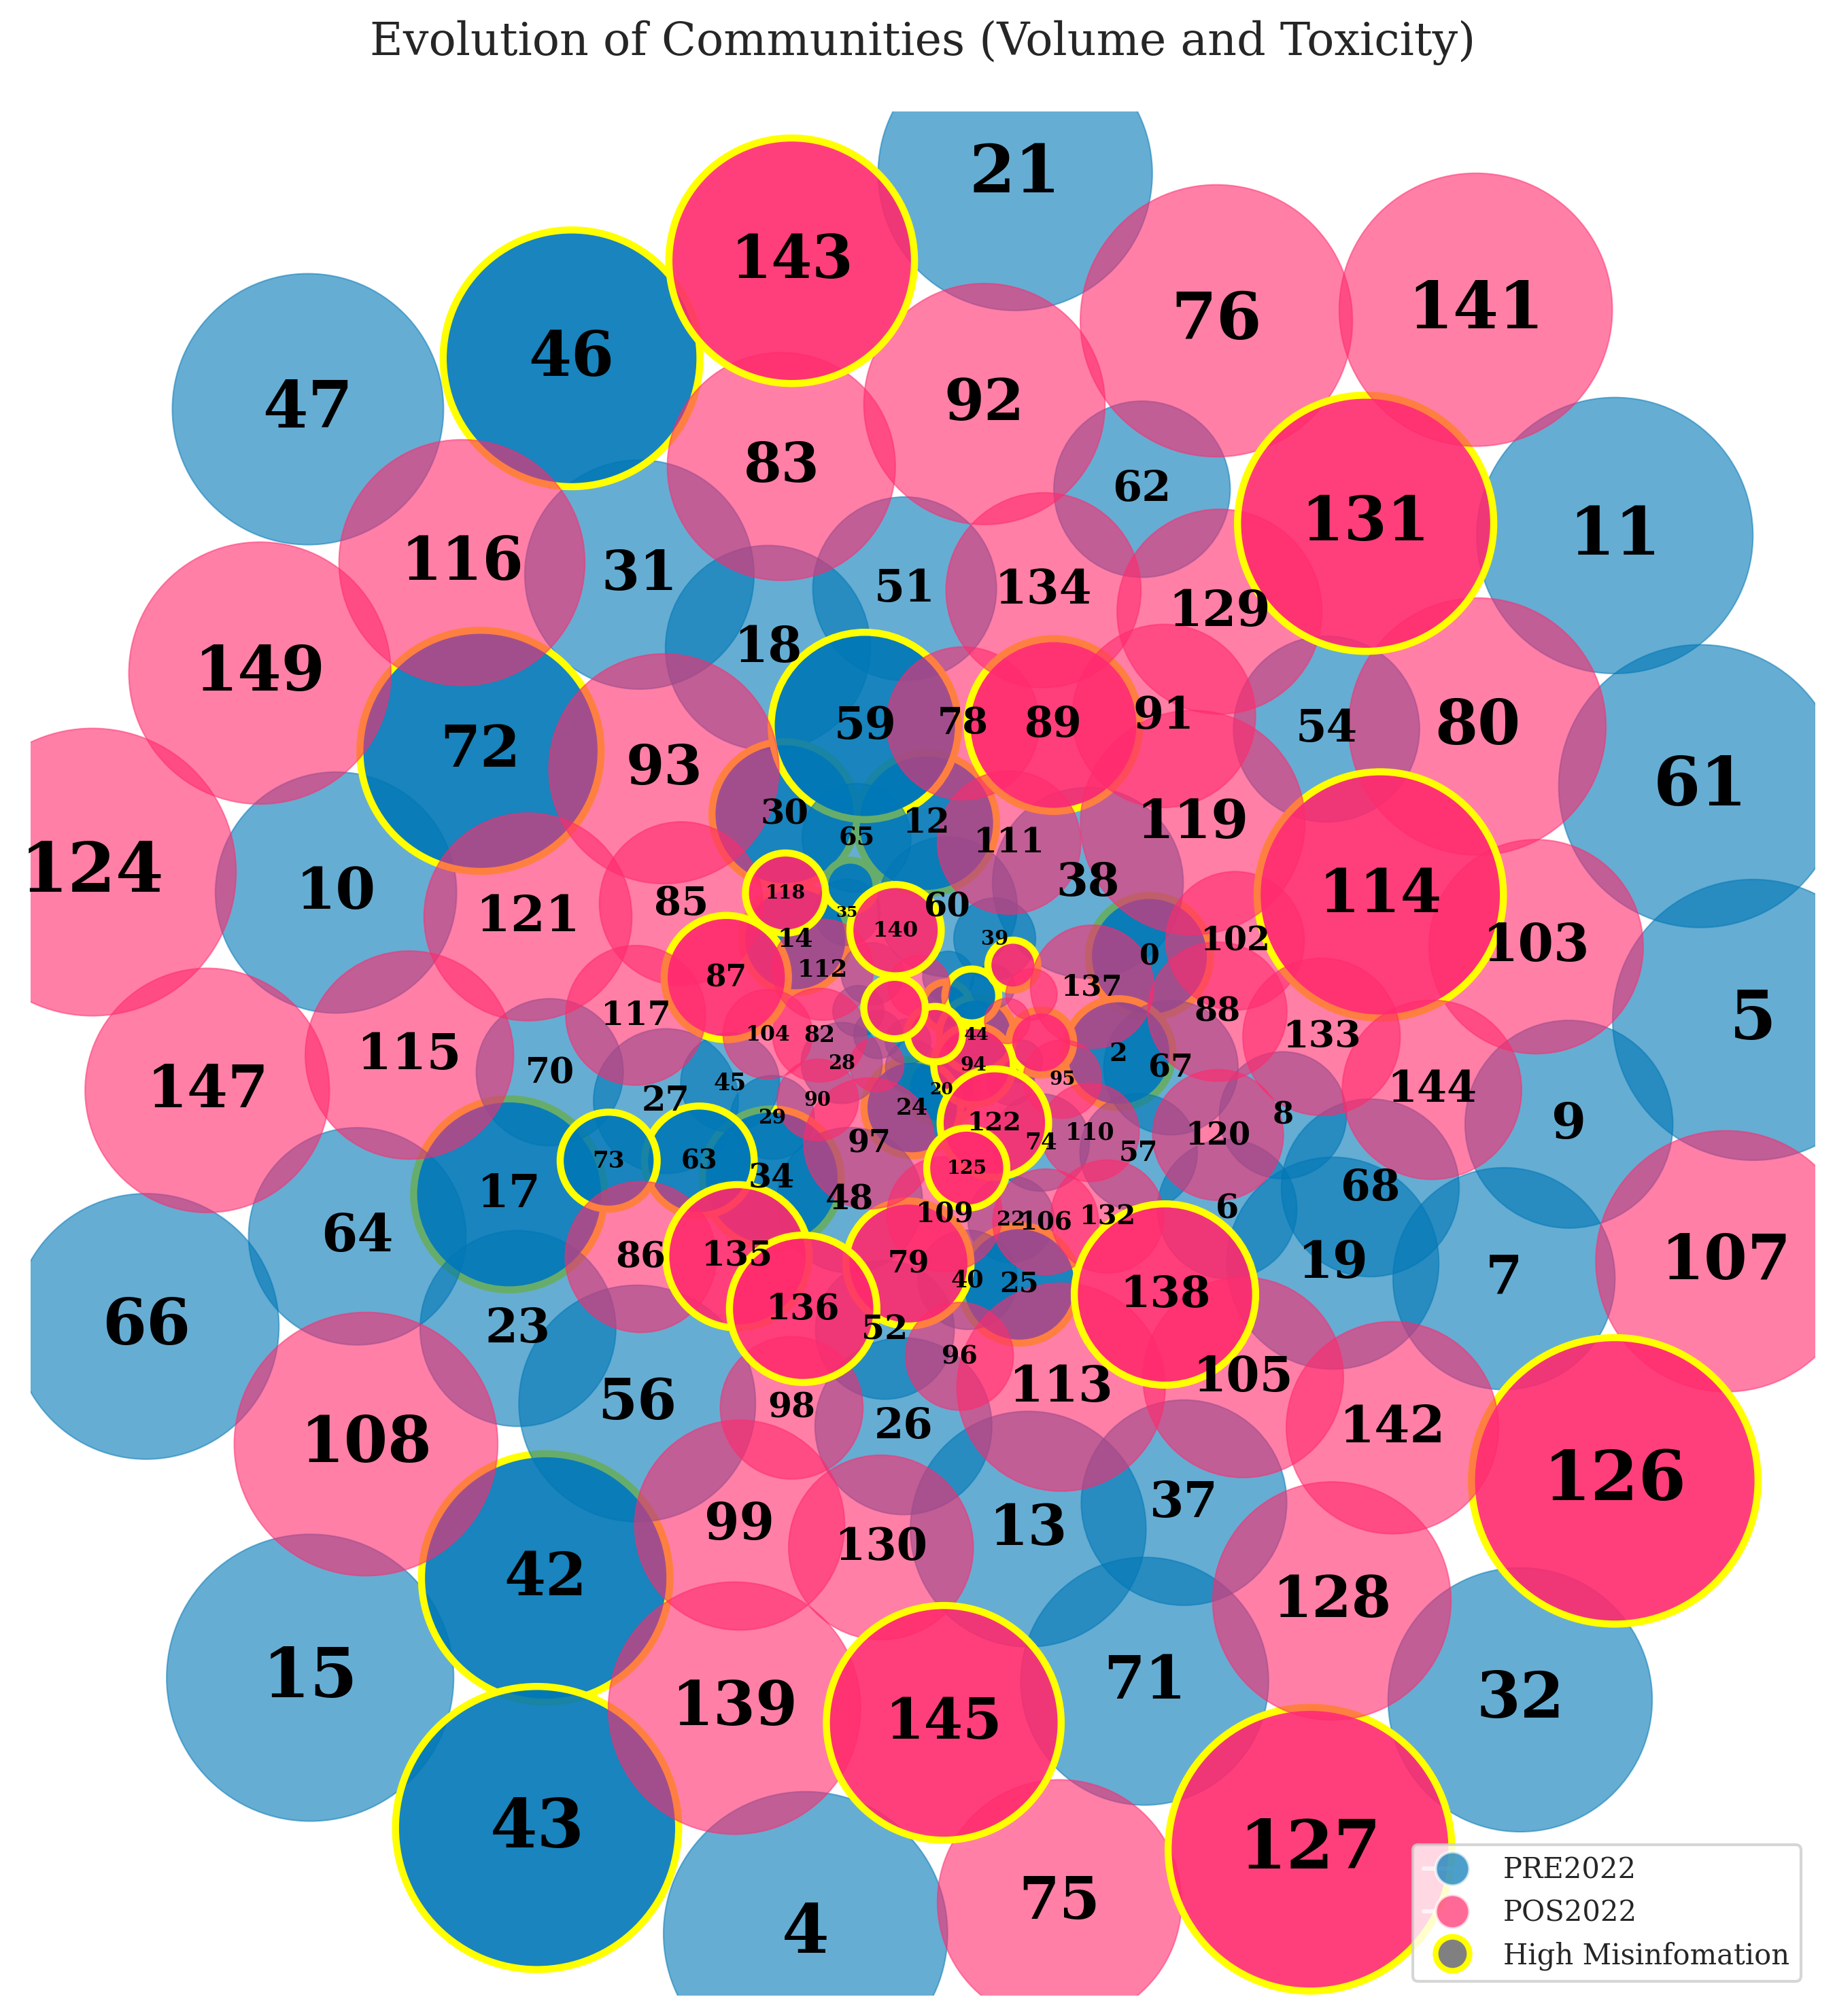

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
from matplotlib.colors import to_rgba

# ================= CONFIGURAÇÃO =================
ARQUIVO_PRE = 'p1_v3/p1_pre_relatorio_desinformacao_comunidades.csv'
ARQUIVO_POS = 'P2/p2_pos_relatorio_desinformacao_comunidades.csv'

# CORES DEFINITIVAS (Sem confusão)
COR_PRE = "#0077b6"      # Azul (Pré)
COR_POS = "#ff2a6d"      # Vermelho/Rosa (Pós)
COR_BORDA_TOXICA = "#ffff00" # Amarelo (Apenas para indicar risco)

COR_FUNDO = 'white'

# ================= 1. CARREGAR DADOS =================
def carregar_dados():
    try:
        df_pre = pd.read_csv(ARQUIVO_PRE)
        df_pos = pd.read_csv(ARQUIVO_POS)
        
        df_pre.columns = [c.lower() for c in df_pre.columns]
        df_pos.columns = [c.lower() for c in df_pos.columns]
        
        df_pre['period'] = 'p1'
        df_pos['period'] = 'p2'
        
        df = pd.concat([df_pre, df_pos])
        df = df[df['count'] > 5].copy()
        
        # Raio visual
        df['radius'] = np.sqrt(df['count'])
        df['radius'] = np.interp(df['radius'], (df['radius'].min(), df['radius'].max()), (3, 40))
        
        return df
    except:
        print("⚠️ Dados não encontrados, gerando exemplo...")
        N = 150
        return pd.DataFrame({
            'period': ['p1']*(N//2) + ['p2']*(N//2),
            'mean': np.random.uniform(0, 1, N),
            'radius': np.random.uniform(5, 35, N),
            'community_id': np.arange(N)
        })

# ================= 2. FÍSICA (PACKING) =================
def pack_circles(df, iterations=300):
    print("🔄 Organizando sem sobreposição...")
    n = len(df)
    radii = df['radius'].values
    
    x = np.random.normal(0, 5, n)
    y = np.random.normal(0, 5, n)
    
    for i in range(iterations):
        x *= 0.99 
        y *= 0.99
        
        for j in range(n):
            dx = x - x[j]
            dy = y - y[j]
            dist_sq = dx**2 + dy**2
            min_dist = radii + radii[j] + 1.0 # Espaçamento de 1px
            
            mask = (dist_sq < min_dist**2) & (dist_sq > 0.01)
            if np.any(mask):
                dists = np.sqrt(dist_sq[mask])
                forces = (min_dist[mask] - dists) / dists
                amount = 0.15
                x[mask] += dx[mask] * forces * amount
                y[mask] += dy[mask] * forces * amount

    df['cx'] = x
    df['cy'] = y
    return df

# ================= 3. DESENHAR =================
df = carregar_dados()
df = pack_circles(df)

print("🎨 Renderizando com cores corrigidas...")
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
ax.set_facecolor(COR_FUNDO)

patches = []
facecolors = []
edgecolors = []
linewidths = []

for _, row in df.iterrows():
    circle = Circle((row['cx'], row['cy']), row['radius'])
    patches.append(circle)
    
    period = row.get('period', 'p1')
    score = row.get('mean', 0)
    
    # REGRA 1: Cor de fundo é SEMPRE baseada no Período
    if period == 'p1':
        cor_base = COR_PRE
    else:
        cor_base = COR_POS
        
    # REGRA 2: Se for tóxico, ganha borda amarela grossa. Se não, borda normal.
    if score >= 0.7:
        ec = to_rgba(COR_BORDA_TOXICA, 1.0) # Borda Amarela
        lw = 2.5 # Borda Grossa
        alpha = 0.9 # Mais opaco para destacar
    else:
        ec = to_rgba(cor_base, 0.5) # Borda da mesma cor suave
        lw = 0.5
        alpha = 0.6 # Mais transparente
        
    facecolors.append(to_rgba(cor_base, alpha))
    edgecolors.append(ec)
    linewidths.append(lw)
    
    # TEXTO (ID da Comunidade)
    if row['radius'] > 8:
        # Texto branco se o fundo for escuro/opaco, preto se for claro
        text_color = 'white' if alpha > 0.8 else 'black'
        # Se tiver borda amarela (tóxico), texto preto pode ler melhor ou branco com sombra
        if score >= 0.7: text_color = 'black'
            
        ax.text(row['cx'], row['cy'], str(int(row.get('community_id', 0))), 
                color=text_color, ha='center', va='center',
                fontsize=row['radius'] * 0.7, fontweight='bold')

# Adiciona Coleção
collection = PatchCollection(patches, match_original=False)
collection.set_facecolor(facecolors)
collection.set_edgecolor(edgecolors)
collection.set_linewidth(linewidths)
ax.add_collection(collection)

# Ajustes Finais
margin = 15
ax.set_xlim(df['cx'].min()-margin, df['cx'].max()+margin)
ax.set_ylim(df['cy'].min()-margin, df['cy'].max()+margin)
ax.axis('off')
ax.set_aspect('equal')

# Título e Legenda Clara
plt.title("Evolution of Communities (Volume and Toxicity)", fontsize=16, fontfamily='serif', pad=20)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COR_PRE, label='PRE2022', markersize=12, alpha=0.7),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COR_POS, label='POS2022', markersize=12, alpha=0.7),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markeredgecolor=COR_BORDA_TOXICA, markeredgewidth=2, label='High Misinfomation', markersize=12)
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=10)

plt.savefig('bubble_chart_corrigido.png', bbox_inches='tight', dpi=300)
print("✅ SUCESSO! Salvo: bubble_chart_corrigido.png")

🌍 Downloading GeoJSON map...
🎨 Rendering map...
✅ Success! Map saved as: map_core_english.png


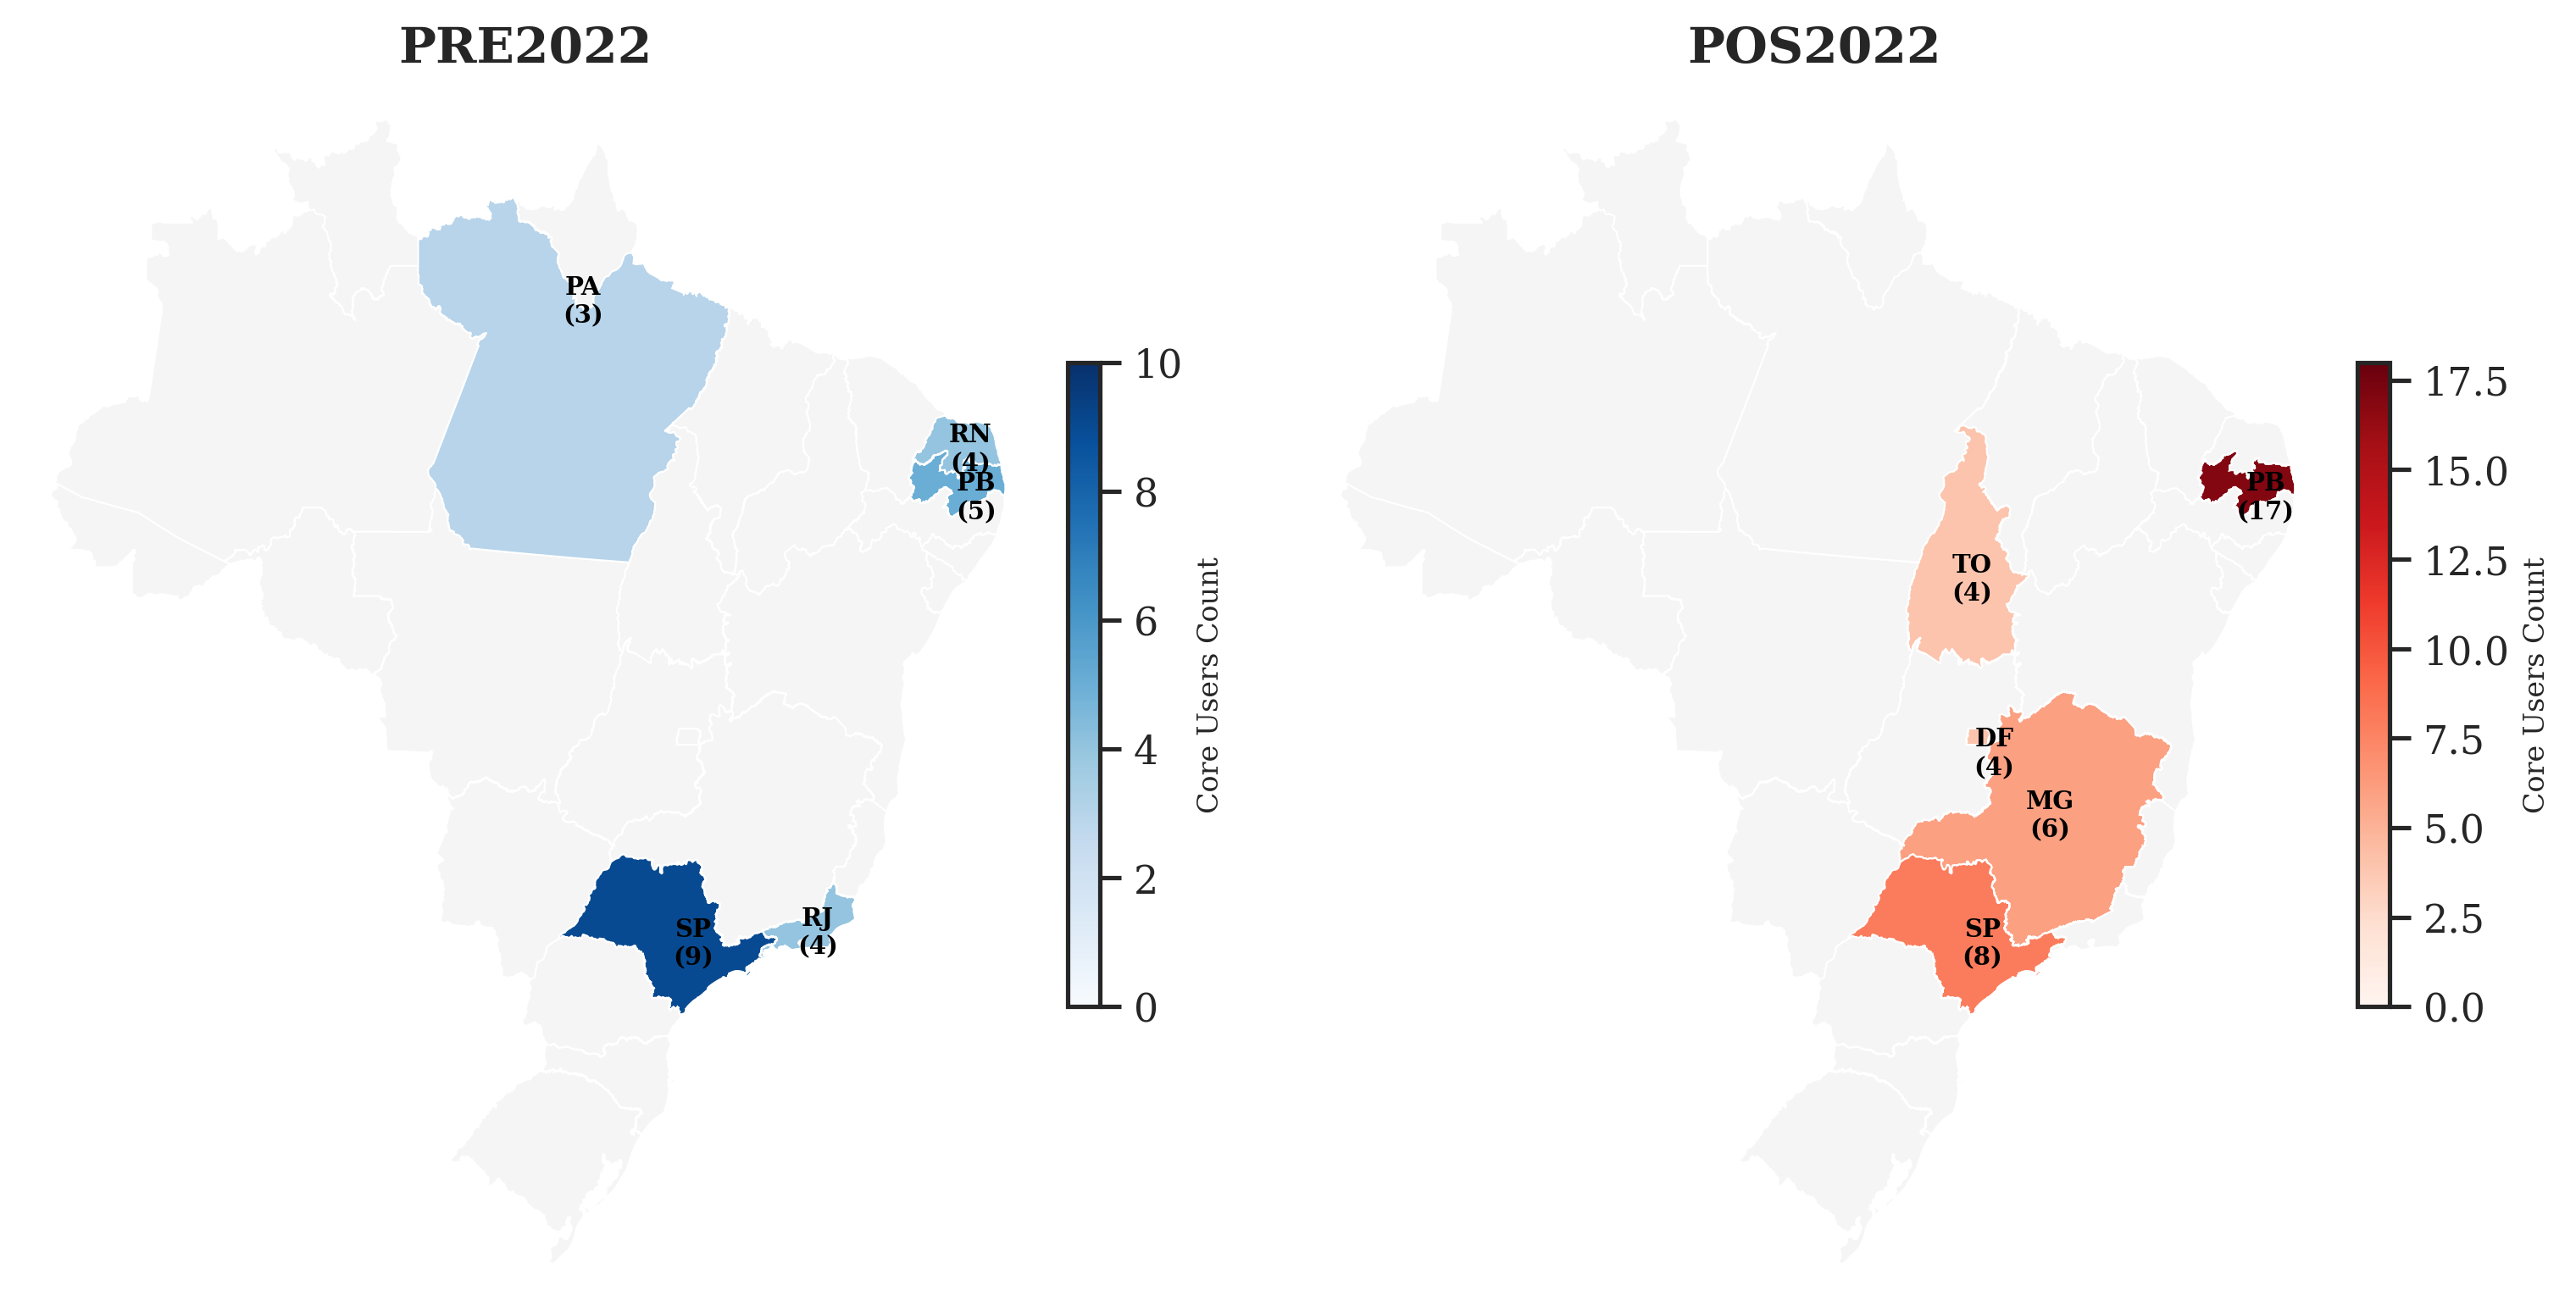

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.path import Path
import matplotlib.colors as mcolors
import requests
import json
import numpy as np

# ================= DATA (From your Table) =================
# PRE: SP leading
data_pre = {'SP': 9, 'PB': 5, 'RJ': 4, 'RN': 4, 'PA': 3}
# POS: PB leading
data_pos = {'PB': 17, 'SP': 8, 'MG': 6, 'DF': 4, 'TO': 4}

# ================= CONFIG =================
URL_GEOJSON = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"

# Colors
BG_COLOR = "#f5f5f5" # Light gray for background states
BORDER_COLOR = "white"

def get_cmap_color(value, max_val, cmap_name):
    """Returns color based on normalized intensity"""
    if value == 0: return BG_COLOR
    norm = plt.Normalize(vmin=0, vmax=max_val)
    cmap = plt.get_cmap(cmap_name)
    return cmap(norm(value))

def parse_polygon(coords):
    """Converts GeoJSON coordinates to Matplotlib Path"""
    # GeoJSON Polygons are lists of rings. First is exterior.
    exterior = coords[0] 
    return Path(exterior)

def plot_state(ax, feature, value, max_val, cmap_name):
    geom = feature['geometry']
    sigla = feature['properties']['sigla']
    geom_type = geom['type']
    coords = geom['coordinates']
    
    color = get_cmap_color(value, max_val, cmap_name)
    
    if geom_type == 'Polygon':
        path = parse_polygon(coords)
        patch = mpatches.PathPatch(path, facecolor=color, edgecolor=BORDER_COLOR, lw=0.5)
        ax.add_patch(patch)
        
    elif geom_type == 'MultiPolygon':
        for poly_coords in coords:
            path = parse_polygon(poly_coords)
            patch = mpatches.PathPatch(path, facecolor=color, edgecolor=BORDER_COLOR, lw=0.5)
            ax.add_patch(patch)

    # Annotation (Label)
    if value > 0:
        # Simple centroid calculation
        all_points = []
        if geom_type == 'Polygon':
            all_points = coords[0]
        else:
            # Get largest polygon (mainland)
            largest = max(coords, key=lambda x: len(x[0]))
            all_points = largest[0]
            
        arr = np.array(all_points)
        cx, cy = np.mean(arr, axis=0)
        
        # Manual adjustments for labels
        if sigla == 'RJ': cx += 0.8
        if sigla == 'PB': cx += 1.0; cy -= 0.5
        if sigla == 'RN': cx += 0.5
        if sigla == 'DF': cx += 0.5; cy -= 0.5
        
        ax.annotate(f"{sigla}\n({value})", (cx, cy), 
                    ha='center', va='center', fontsize=7, fontweight='bold', color='black')

# ================= EXECUTION =================
print("🌍 Downloading GeoJSON map...")
try:
    resp = requests.get(URL_GEOJSON)
    data = resp.json()
    features = data['features']
except Exception as e:
    print(f"Error downloading: {e}")
    exit()

print("🎨 Rendering map...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Set Zoom to Brazil
for ax in [ax1, ax2]:
    ax.set_xlim(-75, -34)
    ax.set_ylim(-34, 6)
    ax.axis('off')

# Scales
max_pre = 10 # Fixed scale for better visualization
max_pos = 18

# Draw Loop
for feat in features:
    sigla = feat['properties']['sigla']
    
    # Map 1 (PRE - Blues)
    val1 = data_pre.get(sigla, 0)
    plot_state(ax1, feat, val1, max_pre, 'Blues')
    
    # Map 2 (POS - Reds)
    val2 = data_pos.get(sigla, 0)
    plot_state(ax2, feat, val2, max_pos, 'Reds')

# Titles
ax1.set_title("PRE2022", fontsize=14, fontweight='bold', pad=10)
ax2.set_title("POS2022", fontsize=14, fontweight='bold', pad=10)

# --- COLORBARS (LEGENDS) ---
# Add colorbar for Pre
sm1 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=max_pre))
sm1.set_array([])
cbar1 = fig.colorbar(sm1, ax=ax1, orientation='vertical', fraction=0.03, pad=0.04)
cbar1.set_label('Core Users Count', fontsize=8)

# Add colorbar for Pos
sm2 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=max_pos))
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', fraction=0.03, pad=0.04)
cbar2.set_label('Core Users Count', fontsize=8)

output_file = 'map_core_english.png'
plt.savefig(output_file, bbox_inches='tight')
print(f"✅ Success! Map saved as: {output_file}")